In [1]:
# 유전 알고리즘을 활용한 머신러닝 입력 최적화 및 대안 제안 메소드
# Part 4. 인플루언서 YouTuber 되기 실습
# Fast Campus / (주)데이원컴퍼니

# **1. 모듈 설치 및 호출**

In [2]:
# !pip install geneticalgorithm

In [3]:
import copy
import math
import datetime
import itertools
import requests
from io import BytesIO
from random import randint

import chardet
import numpy as np
import pandas as pd
import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.utils.fixes import loguniform
from xgboost import XGBRegressor
from geneticalgorithm import geneticalgorithm


pd.set_option('display.max_columns', None) #모든 열을 다 볼수 있게 한다.

# **2. 데이터 로드 및 탐색적 데이터 분석**

In [4]:
# KRvideos.csv 데이터 파일을 Colab에 업로드
# Data link: https://www.kaggle.com/datasnaek/youtube-new
# 여러 나라 data file중 한국 데이터 (KRvideos.csv) 사용

# from google.colab import files, drive
# file_uploaded = files.upload()

In [5]:
# Colab에 데이터 파일을 올려놓은 경우
# drive.mount('./content')
# ! ls /content

In [6]:
filename = 'KRvideos.csv'

with open(filename, 'rb') as f:
    result = chardet.detect(f.readline())
    print('Encoding type:', result['encoding'])

Encoding type: ascii


In [7]:
raw_data = pd.read_csv(filename, engine='python')
raw_data.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [8]:
# KR_category_id.json에서 가져옴
category_id_code = {'1': 'Film & Animation',
                    '2': 'Autos & Vehicles',
                    '10': 'Music',
                    '15': 'Pets & Animals',
                    '17': 'Sports',
                    '18': 'Short Movies',
                    '19': 'Travel & Events',
                    '20': 'Gaming',
                    '21': 'Videoblogging',
                    '22': 'People & Blogs',
                    '23': 'Comedy',
                    '24': 'Entertainment',
                    '25': 'News & Politics',
                    '26': 'Howto & Style',
                    '27': 'Education',
                    '28': 'Science & Technology',
                    '29': 'Nonprofits & Activism',
                    '30': 'Movies',
                    '31': 'Anime/Animation',
                    '32': 'Action/Adventure',
                    '33': 'Classics',
                    '34': 'Comedy',
                    '35': 'Documentary',
                    '36': 'Drama',
                    '37': 'Family',
                    '38': 'Foreign',                    
                    '39': 'Horror',
                    '40': 'Sci-Fi/Fantasy',
                    '41': 'Thriller',
                    '42': 'Shorts',
                    '43': 'Shows',
                    '44': 'Trailers'}

In [9]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34567 entries, 0 to 34566
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                34567 non-null  object
 1   trending_date           34567 non-null  object
 2   title                   34567 non-null  object
 3   channel_title           34567 non-null  object
 4   category_id             34567 non-null  int64 
 5   publish_time            34567 non-null  object
 6   tags                    34567 non-null  object
 7   views                   34567 non-null  int64 
 8   likes                   34567 non-null  int64 
 9   dislikes                34567 non-null  int64 
 10  comment_count           34567 non-null  int64 
 11  thumbnail_link          34567 non-null  object
 12  comments_disabled       34567 non-null  bool  
 13  ratings_disabled        34567 non-null  bool  
 14  video_error_or_removed  34567 non-null  bool  
 15  de

In [10]:
raw_data['description'].isnull().sum()

3163

In [11]:
raw_data.isnull().sum()

video_id                     0
trending_date                0
title                        0
channel_title                0
category_id                  0
publish_time                 0
tags                         0
views                        0
likes                        0
dislikes                     0
comment_count                0
thumbnail_link               0
comments_disabled            0
ratings_disabled             0
video_error_or_removed       0
description               3163
dtype: int64

In [12]:
raw_data['comments_disabled'][raw_data['comments_disabled'] == True].sum()

511

In [13]:
raw_data['ratings_disabled'][raw_data['ratings_disabled'] == True].sum()

1400

In [14]:
raw_data['video_error_or_removed'][raw_data['video_error_or_removed'] == True].sum()

41

In [15]:
# df의 list는 컬럼으로 인식한다
list(raw_data) 

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description']

In [16]:
for i in list(raw_data):
    print(i)
    print(raw_data[i].duplicated().value_counts()) # 중복된수=True, 유니크한수=False
    print(len(raw_data[i].unique()))
    print('\n')

video_id
True     18691
False    15876
Name: video_id, dtype: int64
15876


trending_date
True     34362
False      205
Name: trending_date, dtype: int64
205


title
True     18214
False    16353
Name: title, dtype: int64
16353


channel_title
True     30524
False     4043
Name: channel_title, dtype: int64
4043


category_id
True     34550
False       17
Name: category_id, dtype: int64
17


publish_time
True     18705
False    15862
Name: publish_time, dtype: int64
15862


tags
True     23776
False    10791
Name: tags, dtype: int64
10791


views
False    30690
True      3877
Name: views, dtype: int64
30690


likes
True     25093
False     9474
Name: likes, dtype: int64
9474


dislikes
True     32492
False     2075
Name: dislikes, dtype: int64
2075


comment_count
True     29878
False     4689
Name: comment_count, dtype: int64
4689


thumbnail_link
True     18478
False    16089
Name: thumbnail_link, dtype: int64
16089


comments_disabled
True     34565
False        2
Name: comments_disa

In [17]:
df = raw_data[raw_data['comments_disabled'] != 1]
df = df[df['ratings_disabled'] != 1]
df = df[df['video_error_or_removed'] != 1]
df = df[df['tags'] != '[none]']
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...


In [18]:
print('Before dropna:', len(df))
df = df.dropna()
print('After  dropna:', len(df))
df = df.reset_index(drop=True)

Before dropna: 26078
After  dropna: 24768


#**3. 피쳐 엔지니어링**

In [19]:
r_avg = []
g_avg = []
b_avg = []

for i in tqdm.tqdm(range(len(df))):
    url = df['thumbnail_link'][i]
    res = requests.get(url)
    request_get_img = Image.open(BytesIO(res.content))
    red, green, blue = request_get_img.split()

    r_avg.append(int(np.average(red)))
    g_avg.append(int(np.average(green)))
    b_avg.append(int(np.average(blue)))

df['r_avg'] = r_avg
df['g_avg'] = g_avg
df['b_avg'] = b_avg

100%|██████████████████████████████████████████████████████████████████████████| 24768/24768 [1:29:24<00:00,  4.62it/s]


In [20]:
df.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,hH7wVE8OlQ0,17.14.11,JSA 귀순 북한군 총격 부상,Edward,25,2017-11-13T10:59:16.000Z,"JSA|""귀순""|""북한군""|""총격""|""부상""|""JSA 귀순 북한군 총격 부상""",76533,211,28,113,https://i.ytimg.com/vi/hH7wVE8OlQ0/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중 \n[채널A단독]우리측 ...,193,193,193
2,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
3,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
4,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61


In [21]:
check_table = df[df['r_avg'] == df['g_avg']]
check_table = check_table[check_table['g_avg'] == check_table['b_avg']]
print('len_check_table:', len(check_table))

print('Before removing non-thumbnail images:', len(df))
df_rgb = df[df['r_avg'] != 193]
print('After  removing non-thumbnail images:', len(df_rgb))
df_rgb = df_rgb.reset_index(drop=True)
df_rgb.to_csv('df_color_encode.csv', index_label=False)

len_check_table: 9928
Before removing non-thumbnail images: 24768
After  removing non-thumbnail images: 14957


In [22]:
# df_rgb = pd.read_csv('df_color_encode.csv')
print(df['video_id'].duplicated().value_counts())
df_rgb[df_rgb.duplicated('video_id')].sort_values(by='video_id')

True     13672
False    11096
Name: video_id, dtype: int64


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
2367,#NAME?,17.16.12,ENG 겨울에 하는 속촉촉 겉보송 메이크업 Winter Smooth Moisturi...,lamuqe,26,2017-12-15T09:08:23.000Z,"lamuqe|""lamuqe's magic up""|""라뮤끄""|""라뮤끄의 매직업""|""메...",119281,2979,59,335,https://i.ytimg.com/vi/-Bv81WPrGkU/default.jpg,False,False,False,🌷 instagram @lamuqe_magicup 🌷\n\n안녕하세요! 라뮤끄입니다...,37,31,30
10199,#NAME?,18.20.04,[중국황실마사지 ASMR] 중국 현지인 황실 마사지ㅣMINIYU的中国皇室按摩店。ㅣC...,Miniyu ASMR,22,2018-04-18T11:27:29.000Z,"asmr|""미니유""|""miniyuasmr""|""롤플레이""|""잠""|""불면증""|""role...",111006,3254,100,976,https://i.ytimg.com/vi/-PYI_P4j7D4/default.jpg,False,False,False,* ASMR 이란?\n(Autonomous sensory meridian respo...,101,67,60
13233,#NAME?,18.27.05,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,RT TV,22,2018-05-25T09:20:17.000Z,"bts anpanman reaction|""bts anpanman comeback s...",283730,9602,104,376,https://i.ytimg.com/vi/-qFrHv2XbBY/default.jpg,False,False,False,방탄소년단 - ANPANMAN (BTS - ANPANMAN) │BTS COMEBAC...,95,93,83
13217,#NAME?,18.27.05,총을 못 만지는 남자가 군대에 가서 보여준 기적적인 실화,미들뻔,1,2018-05-26T10:30:47.000Z,"미들뻔|""미드펀""|""미드뻔""|""미들펀""|""뻔펀""|""영화""|""영화 추천""|""영화 소개...",372222,3962,106,1292,https://i.ytimg.com/vi/-ArRPlpU9Tc/default.jpg,False,False,False,"안녕하세요, 미들뻔입니다.오늘 리뷰할 작품은 '핵소 고지(Hacksaw Ridge ...",73,69,55
4005,#NAME?,18.09.01,INFINITE(인피니트) 'Tell Me'(텔미) 무대 칼군무 공개 @Media ...,Vstar,24,2018-01-08T09:00:00.000Z,"Vstar|""성규""|""성종""|""성열""|""엘""|""우현""|""동우""|""인피니트""|""인피니...",107761,5361,38,374,https://i.ytimg.com/vi/-TmXKq_ulMg/default.jpg,False,False,False,"그룹 인피니트(성규, 성종, 성열, 엘, 우현, 동우)가 8일 오후, 서울 용산구 ...",67,58,146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7686,zxjJLN12Ig0,18.09.03,[리플] 달달한 머랭쿠키 맨손으로 직접 만들어보았다! 이번에는 어떻게 망할까? | ...,Ripple_S,23,2018-03-07T10:30:02.000Z,"Ripple|""Ripple_S""|""Replay""|""리플즈""|""리플에스""|""리플레이""...",250100,3592,54,713,https://i.ytimg.com/vi/zxjJLN12Ig0/default.jpg,False,False,False,극한직업 리플PD...\n\n[Contents Awesome!]\n\n리플의 꿀잼 ...,125,129,127
7568,zxpH0ekLUHI,18.07.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",224813,8662,165,1019,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
7498,zxpH0ekLUHI,18.06.03,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,1theK (원더케이),10,2018-03-04T09:00:03.000Z,"Kpop|""1theK""|""원더케이""|""loen""|""로엔""|""뮤비""|""티져""|""MV""...",175110,7640,152,873,https://i.ytimg.com/vi/zxpH0ekLUHI/default.jpg,False,False,False,[MV] Hyungdon & Daejune(형돈이와 대준이) _ The King o...,134,132,129
11347,zy9W8V1ICOw,18.05.05,【꽃핀】 자상무색 한국어 커버 (自傷無色 korean cover),꽃핀,10,2018-05-03T05:38:40.000Z,"꽃핀|""샌드박스""|""Jishou mushoku""|""자상무색""|""自傷無色""|""네코보로...",67169,3751,50,815,https://i.ytimg.com/vi/zy9W8V1ICOw/default.jpg,False,False,False,◕‿◕✿ 매월 마지막 날은 노래 업로드 하는 날~!● 원곡 : @nekobolo【初...,119,89,93


In [23]:
df_rgb[df_rgb['video_id']=='#NAME?']

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
34,#NAME?,17.14.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",78134,3126,28,615,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
118,#NAME?,17.15.11,JSA 귀순 북한군 총격 부상,채널A 뉴스TOP10,43,2017-11-13T11:47:18.000Z,채널 A,85097,223,20,95,https://i.ytimg.com/vi/-yRXK7elKnU/default.jpg,False,False,False,[채널A단독]北 병사 현재 '의식불명'… 혈압 떨어지는 중\n[채널A단독]우리측 초...,76,83,92
158,#NAME?,17.15.11,[영화걸작선] 37회 - 장산범,거의없다,1,2017-11-11T13:56:14.000Z,"영화걸작선|""영화""|""애니""|""demasian""|""거의없다""|""없다""|""걸작선""|""...",84466,3226,30,630,https://i.ytimg.com/vi/-JPy_nBFDtc/default.jpg,False,False,False,"좋은 패 잔뜩 들고 뭐하는거야... 공포영화를 줘, 고구마 말고!!\n잘 나가던 ...",64,65,40
159,#NAME?,17.15.11,Sau Ánh Hào Quang #7 FULL | Cát Phượng: Cái sa...,ĐÔNG TÂY PROMOTION OFFICIAL,24,2017-11-13T15:08:54.000Z,"sau anh hao quang|""sau ánh hào quang""|""sau anh...",1544710,12417,803,2186,https://i.ytimg.com/vi/-k6j6Dkyl1M/default.jpg,False,False,False,"sau anh hao quang, sau ánh hào quang, sau anh ...",97,82,84
207,#NAME?,17.16.11,171115 AAA 레드카펫 워너원 강다니엘 포커스 4K 직캠 / WANNAONE ...,Peach Crush,22,2017-11-15T08:29:30.000Z,"워너원|""강다니엘""|""직캠""|""AAA""|""레드카펫""|""WANNAONE""|""KANGD...",30451,1763,5,118,https://i.ytimg.com/vi/-krZhrUSEUU/default.jpg,False,False,False,B.G.M : Be there - 치즈\n\n출처 명시 및 로고 유지 하에 짤 생성...,101,105,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14729,#NAME?,18.12.06,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",RT TV,22,2018-06-11T06:39:01.000Z,"bts ddaeng|""bts rm suga j hope ddaeng""|""ddaeng...",114672,7056,44,588,https://i.ytimg.com/vi/-VCm09pywpc/default.jpg,False,False,False,"BTS RM, SUGA, J-HOPE - DDAENG (땡) (DISS) REACT...",112,100,92
14790,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14868,#NAME?,18.13.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",96412,572,22,93,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43
14903,#NAME?,18.14.06,미우새 입살림 끝판왕 양세형 레전드 모음 2편!! 《모았캐치 / 미운우리새끼 / 스...,SBS Catch,24,2018-06-12T05:00:01.000Z,"스브스캐치|""미운우리새끼""|""미우새 양세형""|""양세형""|""양세형 레전드""|""미운우리...",150166,691,31,112,https://i.ytimg.com/vi/-Yr3cNO_09o/default.jpg,False,False,False,[스브스캐치] 구독하기▶https://goo.gl/bnT3WD미운우리새끼 양세형이 ...,59,48,43


In [24]:
print('Before removing duplicated video_id:', len(df_rgb))
df_rgb2 = df_rgb.drop_duplicates('video_id')
print('After  removing duplicated video_id:', len(df_rgb2))
df_rgb2 = df_rgb2.reset_index(drop=True)

Before removing duplicated video_id: 14957
After  removing duplicated video_id: 6558


In [25]:
df_rgb2.head(5)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg
0,RxGQe4EeEpA,17.14.11,좋아 by 민서_윤종신_좋니 답가,라푸마코리아,22,2017-11-13T07:07:36.000Z,"라푸마|""윤종신""|""좋니""|""좋아""|""샬레""|""민서""",156130,1422,40,272,https://i.ytimg.com/vi/RxGQe4EeEpA/default.jpg,False,False,False,윤종신 '좋니'의 답가 '좋아' 최초 공개!\n그 여자의 이야기를 지금 만나보세요....,56,41,31
1,9V8bnWUmE9U,17.14.11,나몰라패밀리 운동화 영상 2탄 (빼빼로데이버젼),나몰라패밀리 핫쇼,22,2017-11-11T07:16:08.000Z,"아디다스|""빼빼로""|""핫쇼""|""나몰라패밀리""|""대학로""|""공연""",421409,5112,166,459,https://i.ytimg.com/vi/9V8bnWUmE9U/default.jpg,False,False,False,퍼가실때 꼭 출처 부탁드려요,105,84,86
2,0_8py-t5R80,17.14.11,"이명박 출국 현장, 놓치면 안되는 장면",미디어몽구,25,2017-11-12T11:19:52.000Z,"이명박|""이명박 출국금지""|""이명박 출국현장""|""이명박 바레인""|""이명박 대통령""|...",222850,2093,173,1219,https://i.ytimg.com/vi/0_8py-t5R80/default.jpg,False,False,False,다스는 누구겁니까 듣고 난 후 표정,89,86,86
3,bk55RbxiQdI,17.14.11,김장겸은 물러갔다 MBC 노조 환호와 눈물,NocutV,25,2017-11-13T11:08:59.000Z,"nocutV|""노컷V""|""CBS""|""mbc""|""김장겸""|""해임""|""허일후""",84466,1094,109,450,https://i.ytimg.com/vi/bk55RbxiQdI/default.jpg,False,False,False,김장겸 MBC 사장이 결국 해임됐다.\n\nMBC 대주주인 방송문화진흥회는 13일 ...,81,77,61
4,AmP0ryzDmbY,17.14.11,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 깜놀,하우스,25,2017-11-12T10:17:48.000Z,"김정숙|""김정숙 여사""|""김정숙 문재인""|""문재인 대통령""|""문재인""|""문재인 인도...",188707,545,311,357,https://i.ytimg.com/vi/AmP0ryzDmbY/default.jpg,False,False,False,김정숙 여사는 왜 갑자기 문재인 대통령 주머니에 손을 넣었나? 인도네시아 대통령도 ...,117,103,100


In [26]:
df_rgb2['publish_time2'] = df_rgb2['publish_time'].apply(lambda x: x.split('T')[0])
df_rgb2['publish_date'] = df_rgb2['publish_time2'].astype('datetime64[ns]')
df_rgb2['publish_date']

0      2017-11-13
1      2017-11-11
2      2017-11-12
3      2017-11-13
4      2017-11-12
          ...    
6553   2018-06-11
6554   2018-06-13
6555   2018-06-13
6556   2018-06-13
6557   2018-06-13
Name: publish_date, Length: 6558, dtype: datetime64[ns]

In [27]:
df_rgb2['trending_date'] = pd.to_datetime(df_rgb2['trending_date'], format="%y.%d.%m")
df_rgb2['trending_date']

0      2017-11-14
1      2017-11-14
2      2017-11-14
3      2017-11-14
4      2017-11-14
          ...    
6553   2018-06-14
6554   2018-06-14
6555   2018-06-14
6556   2018-06-14
6557   2018-06-14
Name: trending_date, Length: 6558, dtype: datetime64[ns]

In [28]:
df_rgb2['elapsed_day'] = df_rgb2['trending_date'] - df_rgb2['publish_date'] + datetime.timedelta(days=1)
df_rgb2['elapsed_day'] = df_rgb2['elapsed_day'].dt.days
df_rgb2['elapsed_day']

0       2
1       4
2       3
3       2
4       3
       ..
6553    4
6554    2
6555    2
6556    2
6557    2
Name: elapsed_day, Length: 6558, dtype: int64

In [29]:
df_rgb2['total_number_of_sign'] = df_rgb2['likes'] + df_rgb2['dislikes']

df_rgb2['number_of_tag'] = df_rgb2['tags'].apply(lambda x: len(x.split('|')) if x != '[none]' else 0)

df_rgb2['positive_ratio'] = df_rgb2['likes'] / df_rgb2['dislikes']

In [30]:
positive_ratio_max = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], 0).max() #의미파악

In [31]:
df_rgb2['positive_ratio'] = df_rgb2['positive_ratio'].replace([np.inf, -np.inf], positive_ratio_max*1.5)

df_rgb2['sign_per_day'] = df_rgb2['total_number_of_sign'] / df_rgb2['elapsed_day']

df_rgb2['positive_ratio_per_day'] = df_rgb2['positive_ratio'] / df_rgb2['elapsed_day']

df_rgb2['comment_per_day'] = df_rgb2['comment_count'] / df_rgb2['elapsed_day']

df_rgb2['total_sign_comment_ratio'] = df_rgb2['total_number_of_sign'] / df_rgb2['comment_count']
total_sign_comment_ratio_max = df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], 0).max()
df_rgb2['total_sign_comment_ratio'] = \
    df_rgb2['total_sign_comment_ratio'].replace([np.inf, -np.inf], total_sign_comment_ratio_max*1.5)

df_rgb2['description_length'] = df_rgb2['description'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

df_rgb2['title_length'] = df_rgb2['title'].apply(lambda x: len(str(x) if pd.isnull(x) is False else 0))

In [32]:
df_rgb2['channel_title'].value_counts()

TV Derana       103
JTBC News        90
황장수의 뉴스브리핑o      85
tbs 시민의 방송       83
o 황장수의 뉴스브리핑     76
               ... 
BRUH SAVAGE       1
후니띠 · HooNi       1
KIMDAX킴닥스         1
LampG4H2          1
작약꽃TV             1
Name: channel_title, Length: 1478, dtype: int64

In [33]:
# EA사용: mean_encode_channel 시리즈의 인덱스 숫자 입력
mean_encode_channel = df_rgb2.groupby('channel_title')['views'].mean()
print((mean_encode_channel.dtype))
print(mean_encode_channel)
print(len(mean_encode_channel))
# series.map(딕셔너리)
df_rgb2.loc[:, 'channel_title_mean_enc'] = df_rgb2['channel_title'].map(mean_encode_channel)
df_rgb2['channel_title_mean_enc']

float64
channel_title
!t Live                   64896.666667
& 홍대 쏭카페창현 거리노래방         150317.500000
(MUTUBE)와꾸대장봉준            72740.000000
* eundaromi              129207.500000
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道    799644.000000
                             ...      
흔한남매                     104829.000000
히스토리                     230128.000000
히죽HIZUK                   77737.000000
히히튜브                      29389.000000
힙합버스                      99130.500000
Name: views, Length: 1478, dtype: float64
1478


0       125208.000000
1       421409.000000
2       258691.285714
3       184936.645161
4       178386.071429
            ...      
6553     15136.500000
6554     41945.444444
6555     31731.500000
6556     23404.000000
6557    140520.189655
Name: channel_title_mean_enc, Length: 6558, dtype: float64

In [34]:
df_rgb2['category_id'].value_counts()

24    1854
25    1233
22     869
23     506
10     475
20     443
1      348
15     193
17     176
26     171
27      88
43      69
29      67
2       25
28      23
19      18
Name: category_id, dtype: int64

In [35]:
# EA에 사용됨. music 카테고리는 2번임. 
mean_encode_category = df_rgb2.groupby('category_id')['views'].mean()
print(mean_encode_category)

df_rgb2.loc[:, 'category_id_mean_enc'] = df_rgb2['category_id'].map(mean_encode_category)
df_rgb2['category_id_mean_enc']

category_id
1     3.975242e+05
2     9.113464e+04
10    1.553969e+06
15    1.191287e+05
17    7.371396e+05
19    2.021387e+05
20    1.985810e+05
22    1.481176e+05
23    2.772646e+05
24    4.091292e+05
25    1.309392e+05
26    3.624022e+05
27    9.829427e+04
28    1.678646e+06
29    2.332710e+04
43    7.884158e+04
Name: views, dtype: float64


0       148117.575374
1       148117.575374
2       130939.165450
3       130939.165450
4       130939.165450
            ...      
6553    737139.551136
6554    148117.575374
6555    409129.173679
6556    397524.198276
6557    130939.165450
Name: category_id_mean_enc, Length: 6558, dtype: float64

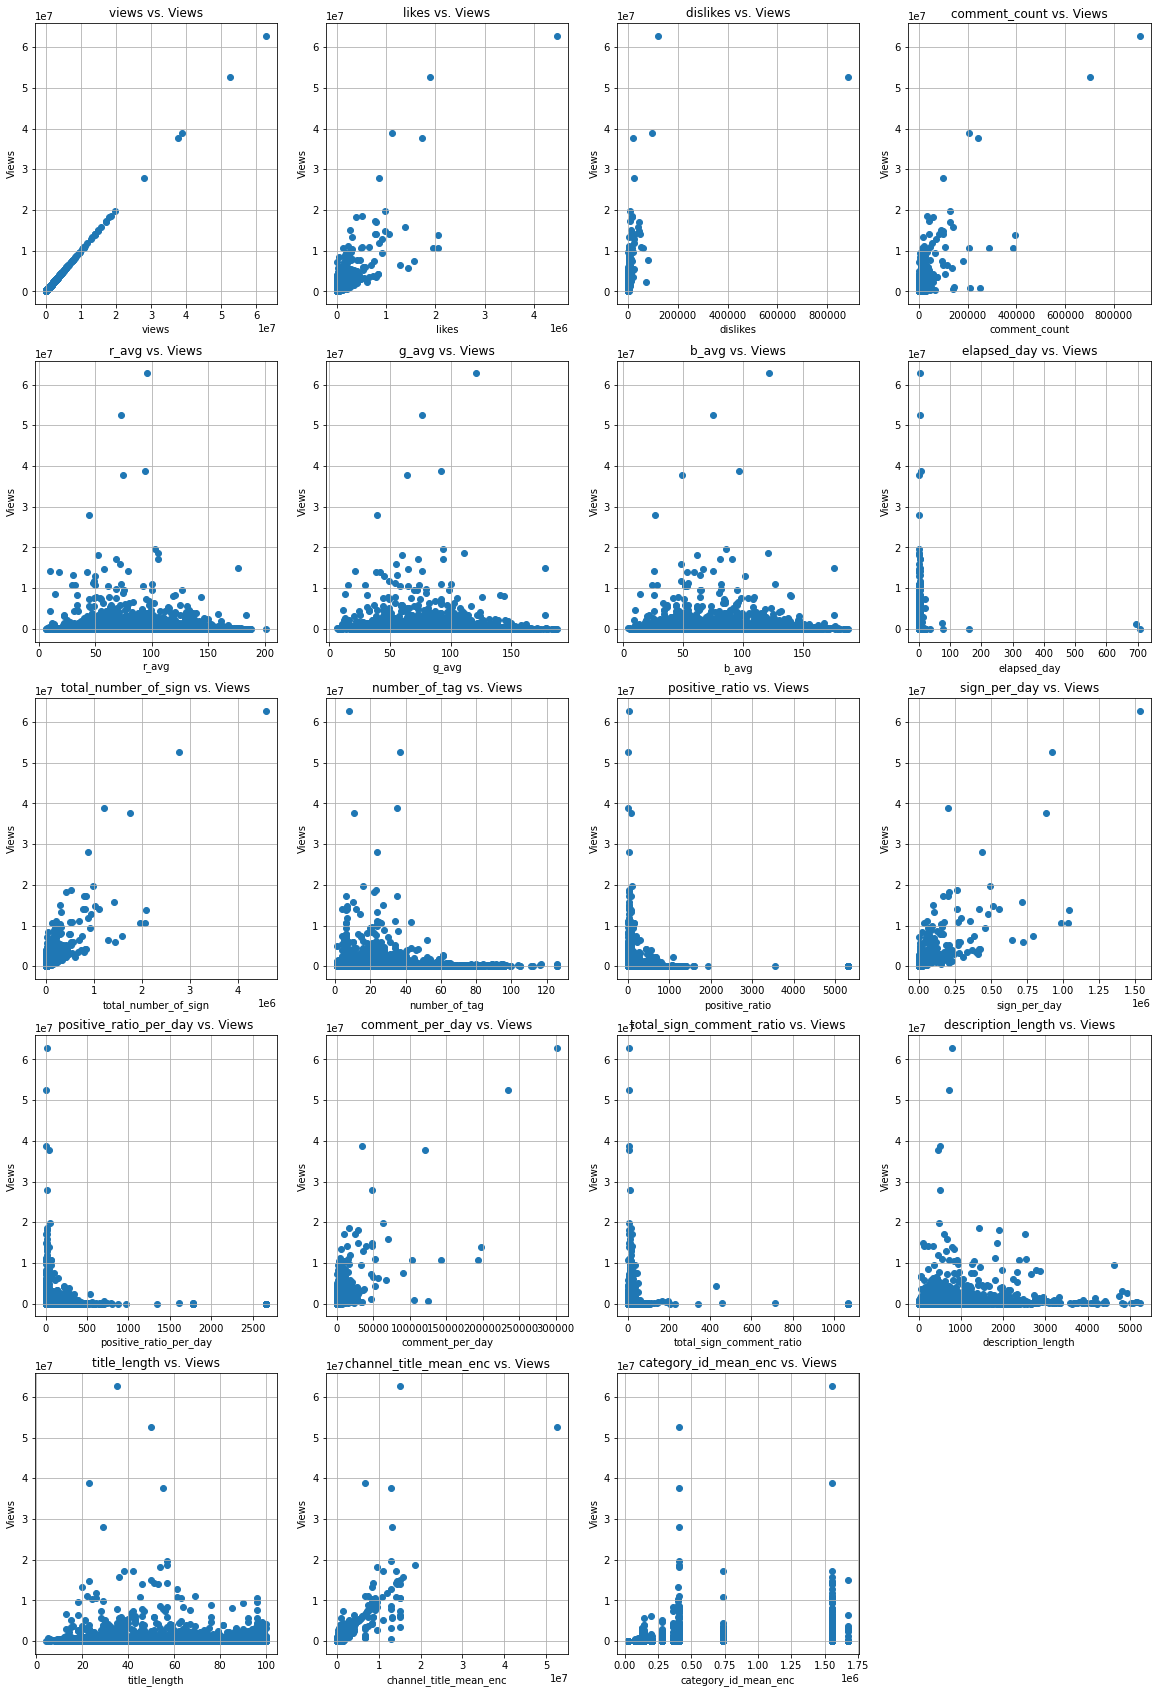

In [36]:
plt.figure(figsize=(20, 30))

for i in range(1, len(df_rgb2.describe().columns)):
    plt.subplot(5, 4, i)
    title = str(df_rgb2.describe().columns[i]) + ' vs. Views'
    plt.title(title)
    plt.xlabel(df_rgb2.describe().columns[i])
    plt.ylabel('Views')
    plt.grid()
    plt.scatter(df_rgb2[df_rgb2.describe().columns[i]], df_rgb2['views'])    

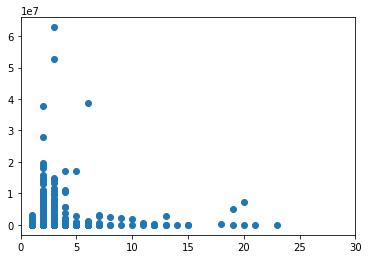

In [37]:
# 상관관계이지 인과관계는 아니다
plt.xlim(0,30)
plt.scatter(df_rgb2['elapsed_day'],df_rgb2['views'])

In [38]:
list(df_rgb2)

['video_id',
 'trending_date',
 'title',
 'channel_title',
 'category_id',
 'publish_time',
 'tags',
 'views',
 'likes',
 'dislikes',
 'comment_count',
 'thumbnail_link',
 'comments_disabled',
 'ratings_disabled',
 'video_error_or_removed',
 'description',
 'r_avg',
 'g_avg',
 'b_avg',
 'publish_time2',
 'publish_date',
 'elapsed_day',
 'total_number_of_sign',
 'number_of_tag',
 'positive_ratio',
 'sign_per_day',
 'positive_ratio_per_day',
 'comment_per_day',
 'total_sign_comment_ratio',
 'description_length',
 'title_length',
 'channel_title_mean_enc',
 'category_id_mean_enc']

#### 다중공산성 체크 

                             likes  dislikes  comment_count  r_avg  g_avg  \
likes                     1.000000       NaN            NaN    NaN    NaN   
dislikes                       NaN       1.0            NaN    NaN    NaN   
comment_count                  NaN       NaN       1.000000    NaN    NaN   
r_avg                          NaN       NaN            NaN    1.0    NaN   
g_avg                          NaN       NaN            NaN    NaN    1.0   
b_avg                          NaN       NaN            NaN    NaN    NaN   
elapsed_day                    NaN       NaN            NaN    NaN    NaN   
number_of_tag                  NaN       NaN            NaN    NaN    NaN   
positive_ratio                 NaN       NaN            NaN    NaN    NaN   
sign_per_day              0.976338       NaN            NaN    NaN    NaN   
positive_ratio_per_day         NaN       NaN            NaN    NaN    NaN   
comment_per_day                NaN       NaN       0.973708    NaN    NaN   

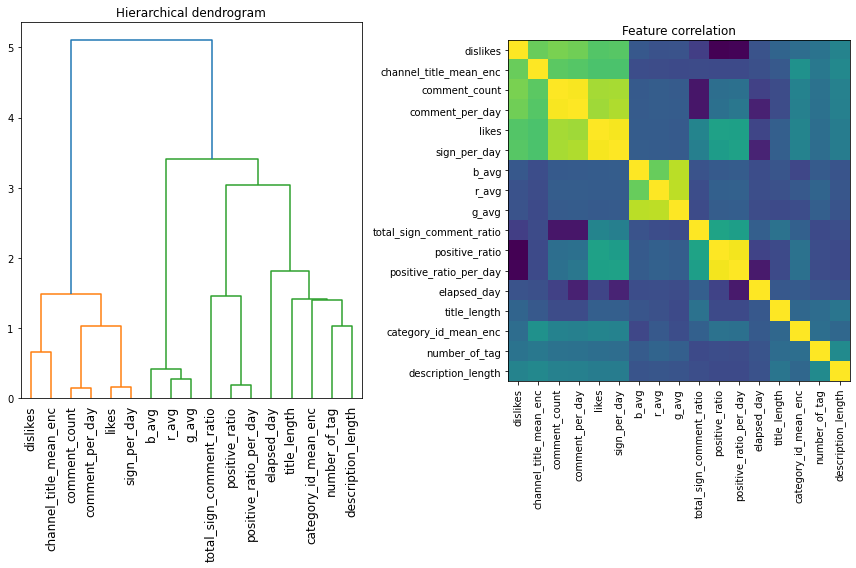

In [39]:
features = ['likes', 'dislikes', 'comment_count', 'r_avg', 'g_avg', 'b_avg', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'sign_per_day', 'positive_ratio_per_day', 'comment_per_day',
            'total_sign_comment_ratio', 'description_length', 'title_length', 'channel_title_mean_enc',
            'category_id_mean_enc']

x_input = df_rgb2[features]
cor_table = x_input.corr()

print(cor_table[cor_table > 0.9])

# correlation그림 그리는 것 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

                        likes  dislikes  comment_count  elapsed_day  \
likes                     1.0       NaN            NaN          NaN   
dislikes                  NaN       1.0            NaN          NaN   
comment_count             NaN       NaN            1.0          NaN   
elapsed_day               NaN       NaN            NaN          1.0   
number_of_tag             NaN       NaN            NaN          NaN   
positive_ratio            NaN       NaN            NaN          NaN   
description_length        NaN       NaN            NaN          NaN   
title_length              NaN       NaN            NaN          NaN   
r_avg                     NaN       NaN            NaN          NaN   
g_avg                     NaN       NaN            NaN          NaN   
b_avg                     NaN       NaN            NaN          NaN   
channel_title_mean_enc    NaN       NaN            NaN          NaN   
category_id_mean_enc      NaN       NaN            NaN          NaN   

     

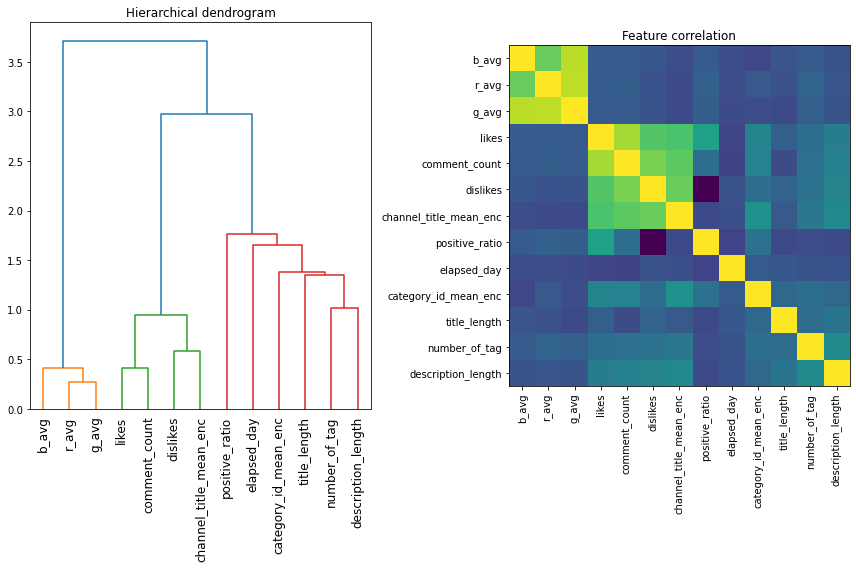

In [40]:
# 필요한 피쳐들만 남겼다
features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag',
            'positive_ratio', 'description_length', 'title_length',
            'r_avg', 'g_avg', 'b_avg',  
            'channel_title_mean_enc', 'category_id_mean_enc']            

x_input = df_rgb2[features]
cor_table = x_input.corr()
print(cor_table[cor_table > 0.9])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.set_title('Hierarchical dendrogram')
corr = spearmanr(x_input).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=features, ax=ax1, leaf_rotation=90)

dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_title('Feature correlation')
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])

fig.tight_layout()

In [41]:
y_output = df_rgb2['views']

x_train, x_test, y_train, y_test = train_test_split(x_input, y_output, random_state=42)

In [42]:
y_output #views숫자 

0       156130
1       421409
2       222850
3        84466
4       188707
         ...  
6553     16026
6554     68002
6555     13175
6556     23404
6557     20923
Name: views, Length: 6558, dtype: int64

#**4. 데이터 스케일링**

In [43]:
scaler = MinMaxScaler() # 각열에 대해서 따로따로 0-1사이로 정렬.
# fit한 정보가 scaler에 들어감.
x_train_scaled = scaler.fit_transform(x_train) # 한번에 처리됨. fit=0-1로 바꿀수있는 파라미터 아는것, transform=바꿔주는 것
x_test_scaled = scaler.transform(x_test) #fit한정보 이용해서 transform만 한다. 

#**5. 모델 생성 및 최적화**

In [44]:
model_name = []
train_perf = []
test_perf = []

Fitting 5 folds for each of 1900 candidates, totalling 9500 fits
Best_estimator: ElasticNet(alpha=0.002700000000000001, l1_ratio=0.9, max_iter=100000000,
           random_state=42, tol=0.1)
Best_params: {'alpha': 0.002700000000000001, 'l1_ratio': 0.9, 'tol': 0.1}
Best_score: 0.7275762237612713
Train score: 0.7335034282763583
Test  score: 0.5717640114921283


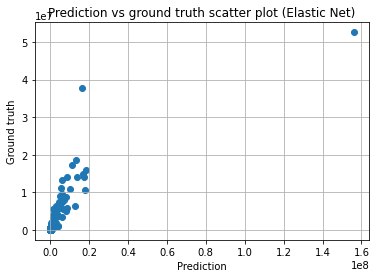

In [45]:
en_model = ElasticNet(max_iter=100000000, random_state=42) #선형모델은 계산부담 없다 많이 돌려도 괜찮다

# 파라미터 미리 준비해옴.
en_param = {'l1_ratio': np.arange(0.9, 0.995, 0.005),
            'alpha': np.arange(0.0008, 0.0028, 0.0001),
            'tol': [1e-2, 3.16e-2, 1e-1, 3.16e-1, 1e0]}

#Grid Search:순차탐색
# n_jobs: 모든 코어를 쓰겠다
clf = GridSearchCV(estimator=en_model, param_grid=en_param, n_jobs=-1, verbose=3) 
clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)

train_score = r2_score(y_train_pred, y_train) 
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Elastic Net')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Elastic Net)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [46]:
# best_parameter로 고정한 모델
en_model = ElasticNet(alpha=0.0027, l1_ratio=0.96, tol=0.1, max_iter=100000000, random_state=42)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best_estimator: RandomForestRegressor(max_depth=30, min_samples_split=3, n_estimators=96,
                      n_jobs=-1, random_state=42)
Best_params: {'max_depth': 30, 'min_samples_split': 3, 'n_estimators': 96}
Best_score: 0.7965402943428193
Train score: 0.938119725937386
Test  score: 0.7656353646719458


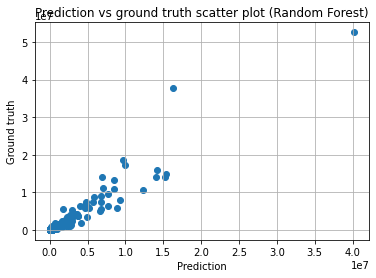

In [47]:
# RandomForest: DecisionTree가 불순도를 가장 줄일 수 있는 방향으로 진행
rf_model = RandomForestRegressor(n_jobs=-1, random_state=42)
# 파라미터 종류확인
# n_estimators: 트리갯수
# max_depth: 트리의 깊이(너무 크면 오버피팅)
# min_samples_split: 나눌때 최소한 이 갯수이상은 있어야 나눌 수 있음
rf_param = {'n_estimators': range(76, 136, 20),
            'max_depth': range(30, 42, 4),
            'min_samples_split': range(2, 5, 1)}

clf = GridSearchCV(estimator=rf_model, param_grid=rf_param, n_jobs=-1, verbose=2)

clf.fit(x_train_scaled, y_train)
y_train_pred = clf.predict(x_train_scaled)
y_test_pred = clf.predict(x_test_scaled)

print('Best_estimator:', clf.best_estimator_)
print('Best_params:', clf.best_params_)
print('Best_score:', clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Random Forest')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (Random Forest)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [48]:
# best_parameter로 고정한 모델
rf_model = RandomForestRegressor(n_estimators=96, max_depth=34, min_samples_split=3, n_jobs=-1, random_state=42)

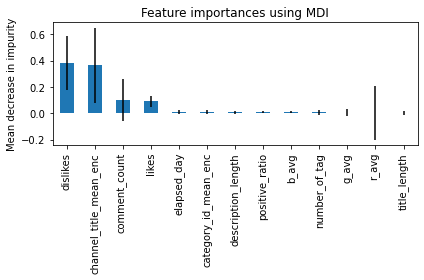

In [49]:
# rf의 피쳐중요도
rf_model.fit(x_train_scaled, y_train)

feature_names = ['feature {i}' for i in range(x_train_scaled.shape[1])]

#피쳐의 중요도가 target예측의 방향성을 알려주지는 않는다
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=features)
forest_importances = forest_importances.sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

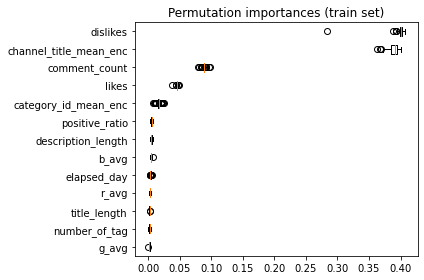

In [50]:
# permutation importance는 피처를 랜덤하게 바꿨을 때 성과로 분석
# n_repeats: 많아질 수록 좋아진다.(배깅) 
result = permutation_importance(rf_model, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best_estimator: MLPRegressor(alpha=0.00011387059213756816, early_stopping=True,
             hidden_layer_sizes=(28, 29, 26, 31), learning_rate='adaptive',
             max_iter=2000000, random_state=42, verbose=0)
Best_params: {'alpha': 0.00011387059213756816, 'hidden_layer_sizes': (28, 29, 26, 31)}
Best_score: 0.7057387150117531
Train score: 0.6987896366721712
Test  score: 0.6846340389129408


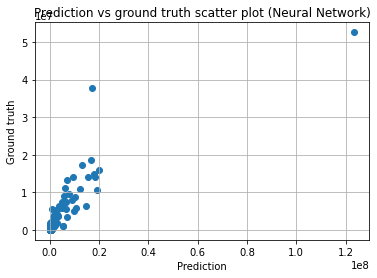

In [51]:
mlp_model = MLPRegressor(learning_rate='adaptive', max_iter=2000000, verbose=0,
                         early_stopping=True, random_state=42)

# itertools.product부분: 24~32사이 숫자를 이용해서 4개의 숫자를 뽑아서 tuple로 만들겠다.
# alpha:규제
# hidden layer와 node수의 관계: 1 hidden layer수=20개 노드수 
mlp_param = {'hidden_layer_sizes': [x for x in itertools.product((range(24, 32)), repeat=4)],
             'alpha': loguniform(1e-4, 1e-3)}

# n_iter:3개보다 크게 돌리자
rand_clf = RandomizedSearchCV(estimator=mlp_model, param_distributions=mlp_param, n_iter=10, n_jobs=-1,
                              cv=3, verbose=2, random_state=42)

rand_clf.fit(x_train_scaled, y_train)

y_train_pred = rand_clf.predict(x_train_scaled)
y_test_pred = rand_clf.predict(x_test_scaled)

print('Best_estimator:', rand_clf.best_estimator_)
print('Best_params:', rand_clf.best_params_)
print('Best_score:', rand_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('Neural Network')
train_perf.append(train_score)
test_perf.append(test_score)
plt.title('Prediction vs ground truth scatter plot (Neural Network)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [52]:
# best_parameter로 고정한 모델
mlp_model = MLPRegressor(hidden_layer_sizes=(24, 27, 28, 31), alpha=2.715e-4, learning_rate='adaptive',
                         max_iter=2000000, verbose=0, early_stopping=True, random_state=42)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best_estimator: XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=120, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0.1, reg_lambda=0.1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)
Best_params: {'max_depth': 2, 'n_estimators': 120, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Best_score: 0.7719576984387961
Train score: 0.9922683770622531
Test  score: 0.8017477716708146


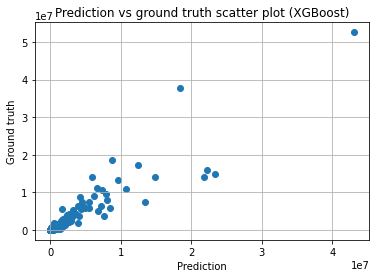

In [53]:
# XGBoost
xgb_model = XGBRegressor(n_jobs=-1, random_state=42)

# rf와 비슷
# 부스팅알고리즘(reg_) 체크
xgb_param = {'n_estimators': range(80, 140, 20),
             'max_depth': range(2, 5, 1),
             'reg_alpha': [1e-2, 3.16e-2, 1e-1],
             'reg_lambda': [0.1, 0.316, 1]}

xgb_clf = GridSearchCV(estimator=xgb_model, param_grid=xgb_param, n_jobs=-1, verbose=2, cv=3)

xgb_clf.fit(x_train_scaled, y_train)
y_train_pred = xgb_clf.predict(x_train_scaled)
y_test_pred = xgb_clf.predict(x_test_scaled)

print('Best_estimator:', xgb_clf.best_estimator_)
print('Best_params:', xgb_clf.best_params_)
print('Best_score:', xgb_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('XGBoost')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (XGBoost)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [54]:
# best_parameter로 고정한 모델
xgb_model = XGBRegressor(max_depth=4, n_estimators=120, reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, random_state=42)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best_estimator: SVR(C=31600000.0, gamma=0.1)
Best_params: {'C': 31600000.0, 'gamma': 0.1}
Best_score: 0.7589470912496413
Train score: 0.4757299501531632
Test  score: -0.40204085363753483


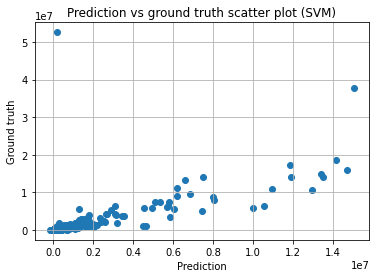

In [55]:
# SVM 
svr_model = SVR()

# 두파라미터: overfit제어가능
# C는 1e8이 맥스임 
svr_param = {'C': [3.16e7, 1e8],
             'gamma': [0.1, 0.316]}

svr_clf = GridSearchCV(estimator=svr_model, param_grid=svr_param, n_jobs=-1, verbose=3, cv=3)

svr_clf.fit(x_train_scaled, y_train)
y_train_pred = svr_clf.predict(x_train_scaled)
y_test_pred = svr_clf.predict(x_test_scaled)

print('Best_estimator:', svr_clf.best_estimator_)
print('Best_params:', svr_clf.best_params_)
print('Best_score:', svr_clf.best_score_)
train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

model_name.append('SVM')
train_perf.append(train_score)
test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (SVM)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

In [56]:
# best_parameter로 고정한 모델
svr_model = SVR(C=1e8, gamma=0.1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best_estimator: KNeighborsRegressor(leaf_size=1, n_jobs=-1, weights='distance')
Best_params: {'leaf_size': 1, 'n_neighbors': 5, 'weights': 'distance'}
Best_score: 0.6003613583437778
Train score: 0.4757299501531632
Test  score: -0.40204085363753483


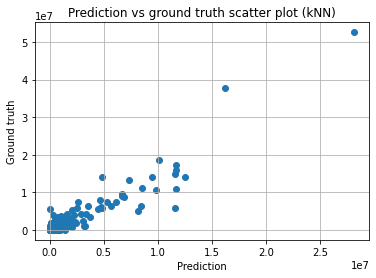

In [57]:
# KNeighborsRegressor: 인접한 데이터들을 기반으로 가격을 예측한다. 
# https://rebro.kr/184
# 범위 밖의 영역은 어떤 예측 체크
knn_model = KNeighborsRegressor(n_jobs=-1)

# n_neighbors: 이웃을 몇개로 할 것인지
# weights: 거리가 멀어진 point에 대해서는 웨이트를 낮게 주고
# leaf_size: 
knn_param = {'n_neighbors': range(1, 6, 1),
             'weights': ['uniform', 'distance'],
             'leaf_size': range(1, 5, 1)}

knn_clf = GridSearchCV(estimator=knn_model, param_grid=knn_param, n_jobs=-1, verbose=3)

knn_clf.fit(x_train_scaled, y_train)
y_train_pred = knn_clf.predict(x_train_scaled)
y_test_pred = knn_clf.predict(x_test_scaled)

print('Best_estimator:', knn_clf.best_estimator_)
print('Best_params:', knn_clf.best_params_)
print('Best_score:', knn_clf.best_score_)
# train_score = r2_score(y_train_pred, y_train)
print('Train score:', train_score)
# test_score = r2_score(y_test_pred, y_test)
print('Test  score:', test_score)

# model_name.append('KN')
# train_perf.append(train_score)
# test_perf.append(test_score)

plt.title('Prediction vs ground truth scatter plot (kNN)')
plt.xlabel('Prediction')
plt.ylabel('Ground truth')
plt.grid()
plt.scatter(y_test_pred, y_test)

- 위의 모델들 비교

['Elastic Net', 'Random Forest', 'Neural Network', 'XGBoost', 'SVM']
[0.7335034282763583, 0.938119725937386, 0.6987896366721712, 0.9922683770622531, 0.4757299501531632]


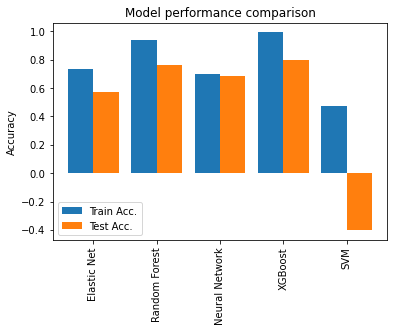

In [58]:
plt.title('Model performance comparison')
plt.xticks(rotation=90)
plt.ylabel('Accuracy')
print(model_name)
print(train_perf)
x = np.arange(len(model_name))
plt.xticks(x, model_name)
plt.bar(x - 0.2, train_perf, width=0.4, label='Train Acc.')
plt.bar(x + 0.2, test_perf, width=0.4, label='Test Acc.')
plt.legend()

#**6. 모델 앙상블**

1 Ensemble train score: 0.998935623347123
1 Ensemble test  score: 0.8133059060463537
2 Ensemble train score: 0.9859270082999271
2 Ensemble test  score: 0.794830540400796
3 Ensemble train score: 0.9430097247517739
3 Ensemble test  score: 0.5878487309320353
4 Ensemble train score: 0.9181206517707368
4 Ensemble test  score: 0.8754461328285247
5 Ensemble train score: 0.8965498575776579
5 Ensemble test  score: 0.8434584529310978


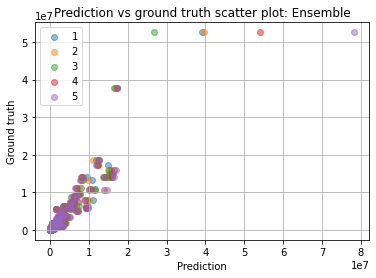

In [59]:
# 반드시 앙상블로 사용하자: 일반화 (익스트림앙상블 10000개)
# sklearn voting classifier
ensemble_list = [('xgb', xgb_model),
                 ('rf', rf_model),
                 ('svm', svr_model),
                 ('mlp', mlp_model),
                 ('en', en_model)]

voting_est = []

for idx, target_model in enumerate(ensemble_list):
    voting_est.append(target_model)

    voting_clf = VotingRegressor(estimators=voting_est, n_jobs=-1)
    voting_clf.fit(x_train_scaled, y_train)
    y_train_pred = voting_clf.predict(x_train_scaled)
    y_test_pred = voting_clf.predict(x_test_scaled)
    print(idx + 1, 'Ensemble train score:', r2_score(y_train_pred, y_train))
    print(idx + 1, 'Ensemble test  score:', r2_score(y_test_pred, y_test))

    plt.scatter(y_test_pred, y_test, label=str(idx + 1), alpha=0.5) #alpha:투명도
    title = 'Prediction vs ground truth scatter plot: Ensemble'     
    plt.title(title)
    plt.xlabel('Prediction')
    plt.ylabel('Ground truth')
    plt.grid()
    plt.legend()

In [60]:
voting_clf = VotingRegressor(estimators=[('xgb', xgb_model), ('rf', rf_model), ('svm', svr_model)],
                             n_jobs=-1)
voting_clf.fit(x_train_scaled, y_train)

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=120, n_jobs=-1,
                                          num_parallel_tree=None,
                                          pr

#**7. 특성(피쳐) 중요도 분석**
- 최종 모델에 대한 피쳐중요도 분석

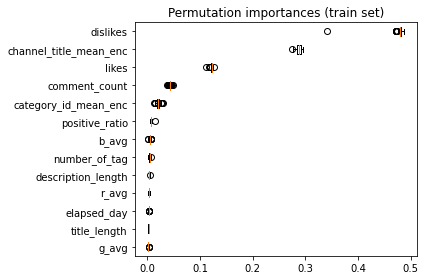

In [61]:
# 피쳐중요도 최종분석
result = permutation_importance(voting_clf, x_train_scaled, y_train, n_repeats=100, n_jobs=-1, random_state=42)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=x_train.columns[sorted_idx])
ax.set_title("Permutation importances (train set)")
fig.tight_layout()

#### 분석에 쓸 최종 모델만들기
- 이전 단계에서는 train데이터를 활용해서 모델을 학습시키고 test데이터로 확인을 하였다 
- 이번 단계에서는 최종모델을 훈련하여 test에 쓸 최종 모델을 만든다. 

In [62]:
x_total = np.concatenate((x_train, x_test), axis=0)
y_total = np.concatenate((y_train, y_test), axis=0)

x_total_scaled = scaler.transform(x_total)# 이전 scaler를 사용 확인

voting_clf.fit(x_total_scaled, y_total) # 학습완료

VotingRegressor(estimators=[('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_delta_step=None, max_depth=4,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          n_estimators=120, n_jobs=-1,
                                          num_parallel_tree=None,
                                          pr

#**8. 유전 알고리즘 - 최적 피쳐 탐색: 일반 YouTuber**
- 먼저 일반youtuber 분석함

In [63]:
# views의 통계량 분석
# 일반유튜버는 50%레벨로 보고
# 상단으로 갈수록 views수가 크게 늘어난다
df_rgb2['views'].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])

count    6.558000e+03
mean     3.702816e+05
std      1.662346e+06
min      2.623000e+03
50%      9.915450e+04
75%      2.330775e+05
90%      5.680616e+05
95%      1.155140e+06
99%      5.188478e+06
max      6.279639e+07
Name: views, dtype: float64

In [64]:
# 참고사항 
# features = ['likes', 'dislikes', 'comment_count', 'elapsed_day', 'number_of_tag', 'positive_ratio',
#             'description_length', 'title_length', 'r_avg', 'g_avg', 'b_avg', 'channel_title_mean_enc',
#             'category_id_mean_enc']

# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'


# 유전알고리즘에 의해서 만들어진 x_input이 여기에 쓰인다. 
def input_conversion(x_input):
    conversion = [int(x_input[0]),
                  int(x_input[1]),
                  int(x_input[2]),
                  int(x_input[3]),
                  int(x_input[4]),
                  x_input[0] / x_input[1],
                  int(x_input[5]),
                  int(x_input[6]),
                  int(x_input[7]),
                  int(x_input[8]),
                  int(x_input[9]),
                  mean_encode_channel.iloc[int(x_input[10])],
                  mean_encode_category.iloc[int(x_input[11])]]

    return conversion

In [65]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

# variable들의 바운드 
# [최소값, 최대값]
# 찾고자하는 범위를 조금 안쪽으로 세팅해도 됨. 지금은 1로 보정하였으나 범위끝쪽은 설명력 떨어짐
varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]], 
                     [2, 2]]) # music카테고리사용 아니면 위의 코드로 전체를 사용함

In [66]:
# 유전알고리즘이 사용할 object함수 
# target_model: 유전알고리즘을 머신러닝알고리즘에 연결해서 사용함 
# 일반유튜브를 상대로 한 것이라 median이라고 씀 
def object_function_median(x_input, target_model=voting_clf):
    # 모델이 사용할 수 있는 형식으로 바꿈 
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)
    
    # 스케일링: fit해서 파라미터저장하였음. 
    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled) #추론

    # 유전알고리즘에 따라서 목표값을 탐색하는 것임. 
    # 목표: views가 10만(median)에 해당하는 컨디션은 무엇이 있는지? 
    target = df_rgb2['views'].median()
    print('Predicted views:', int(prediction), 'Difference from target:', int(prediction - target))

    # Target에 가까이 가기 위해서 loss함수처럼 짜준다 
    # prediction과 target차이가 커지면 차이를 줄이려고 유전알고리즘이 작동 
    # return abs(int(prediction) - target) # target값근처에서는 차이가 별로 안나서 효율이 안나서 절대값대신 로그씀
    return math.log(abs(target - int(prediction))) # 작은 값을 맞출때 그 gain이 크도록 log를 쓴다 

In [67]:
# 유전알고리즘 파라미터 정의
# parents_portion: 다음세대에 부모세대의 비중 30% 
# crossover_probability: 크로스오버 교차연산을 얼마나 하겠다
# crossover_type: uniform 부분해 집합을 랜덤하게 섞겠다 
# mutation_probability: 다음세대에 변이비중 10%로 가져가겠다 
# elit_ratio: 이전세대에 가장 뛰어난 비중만큼 이번세대에 그대로 가져간다 
# population_size: 초기 generation된 해값들
# max_num_iteration: 전체 몇번 진화를 할 것이냐 
# max_iteration_without_improv: 몇번동안 개선이 없으면 정지하겠느냐 

algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Predicted views: 29404317 Difference from target: 29305163
Predicted views: 37430805 Difference from target: 37331651
Predicted views: 33033498 Difference from target: 32934343
Predicted views: 21514067 Difference from target: 21414912
Predicted views: 34423664 Difference from target: 34324509
Predicted views: 20080298 Difference from target: 19981143
Predicted views: 30358762 Difference from target: 30259607
Predicted views: 29489018 Difference from target: 29389864
Predicted views: 31728470 Difference from target: 31629316
Predicted views: 31818970 Difference from target: 31719815
Predicted views: 22026783 Difference from target: 21927628
Predicted views: 21724312 Difference from target: 21625158
Predicted views: 17515730 Difference from target: 17416576
Predicted views: 23679111 Difference from target: 23579957
Predicted views: 37032463 Difference from target: 36933308
Predicted views: 29253335 Difference from target: 29154180
Predicted views: 33181857 Difference from target: 330827

Predicted views: 40689288 Difference from target: 40590133
Predicted views: 22291820 Difference from target: 22192666
Predicted views: 21662841 Difference from target: 21563686
Predicted views: 19403040 Difference from target: 19303885
Predicted views: 34381529 Difference from target: 34282375
Predicted views: 24174716 Difference from target: 24075562
Predicted views: 36191269 Difference from target: 36092115
Predicted views: 34313852 Difference from target: 34214698
Predicted views: 20247192 Difference from target: 20148038
Predicted views: 26573098 Difference from target: 26473944
Predicted views: 28009039 Difference from target: 27909885
Predicted views: 15638057 Difference from target: 15538902
Predicted views: 12216857 Difference from target: 12117703
Predicted views: 27566119 Difference from target: 27466964
Predicted views: 21420370 Difference from target: 21321215
Predicted views: 35581901 Difference from target: 35482746
Predicted views: 26267230 Difference from target: 261680

Predicted views: 17186930 Difference from target: 17087776
Predicted views: 21935419 Difference from target: 21836265
Predicted views: 34213501 Difference from target: 34114346
Predicted views: 6998763 Difference from target: 6899609
Predicted views: 36045821 Difference from target: 35946667
Predicted views: 11490835 Difference from target: 11391680
Predicted views: 34702800 Difference from target: 34603646
Predicted views: 22092653 Difference from target: 21993498
Predicted views: 32512525 Difference from target: 32413371
Predicted views: 17010809 Difference from target: 16911655
Predicted views: 38696940 Difference from target: 38597786
Predicted views: 12861371 Difference from target: 12762217
Predicted views: 26921447 Difference from target: 26822293
Predicted views: 12011724 Difference from target: 11912570
Predicted views: 22230406 Difference from target: 22131251
Predicted views: 12042968 Difference from target: 11943813
Predicted views: 30444230 Difference from target: 30345075

Predicted views: 24962972 Difference from target: 24863818
Predicted views: 3423039 Difference from target: 3323884
Predicted views: 12408113 Difference from target: 12308958
Predicted views: 27227406 Difference from target: 27128251
Predicted views: 10927673 Difference from target: 10828518
Predicted views: 5541585 Difference from target: 5442430
Predicted views: 4024075 Difference from target: 3924920
Predicted views: 12082736 Difference from target: 11983581
Predicted views: 21690383 Difference from target: 21591229
Predicted views: 21974085 Difference from target: 21874931
Predicted views: 30698626 Difference from target: 30599472
Predicted views: 3275475 Difference from target: 3176321
Predicted views: 11808841 Difference from target: 11709687
Predicted views: 19329125 Difference from target: 19229970
Predicted views: 15098760 Difference from target: 14999605
Predicted views: 28438921 Difference from target: 28339766
Predicted views: 7060867 Difference from target: 6961713
Predict

Predicted views: 3346202 Difference from target: 3247048
Predicted views: 8776099 Difference from target: 8676944
Predicted views: 5637508 Difference from target: 5538353
Predicted views: 25698473 Difference from target: 25599318
Predicted views: 3861562 Difference from target: 3762407
Predicted views: 13917959 Difference from target: 13818804
Predicted views: 17450678 Difference from target: 17351524
Predicted views: 8100919 Difference from target: 8001765
Predicted views: 36502845 Difference from target: 36403690
Predicted views: 3563133 Difference from target: 3463979
Predicted views: 10378263 Difference from target: 10279108
Predicted views: 24737544 Difference from target: 24638390
Predicted views: 12109722 Difference from target: 12010567
Predicted views: 3185759 Difference from target: 3086605
Predicted views: 3506501 Difference from target: 3407346
Predicted views: 5651568 Difference from target: 5552414
Predicted views: 8783582 Difference from target: 8684427
Predicted views: 

Predicted views: 27422763 Difference from target: 27323609
Predicted views: 5898244 Difference from target: 5799090
Predicted views: 4901704 Difference from target: 4802550
Predicted views: 40693641 Difference from target: 40594487
Predicted views: 2993326 Difference from target: 2894171
Predicted views: 6328652 Difference from target: 6229497
Predicted views: 27532500 Difference from target: 27433346
Predicted views: 28353011 Difference from target: 28253857
Predicted views: 13936070 Difference from target: 13836916
Predicted views: 13206925 Difference from target: 13107771
Predicted views: 3081577 Difference from target: 2982423
Predicted views: 26877367 Difference from target: 26778212
Predicted views: 5228732 Difference from target: 5129577
Predicted views: 12062721 Difference from target: 11963567
Predicted views: 3943718 Difference from target: 3844564
Predicted views: 17837471 Difference from target: 17738316
Predicted views: 5991973 Difference from target: 5892818
Predicted vie

Predicted views: 3936263 Difference from target: 3837108
Predicted views: 6989481 Difference from target: 6890327
Predicted views: 6521424 Difference from target: 6422270
Predicted views: 4156958 Difference from target: 4057804
Predicted views: 3910085 Difference from target: 3810930
Predicted views: 4916086 Difference from target: 4816932
Predicted views: 12865822 Difference from target: 12766668
Predicted views: 3445676 Difference from target: 3346521
Predicted views: 4114896 Difference from target: 4015741
Predicted views: 3949183 Difference from target: 3850028
Predicted views: 6030875 Difference from target: 5931721
Predicted views: 10675287 Difference from target: 10576132
Predicted views: 17364005 Difference from target: 17264851
Predicted views: 3596023 Difference from target: 3496869
Predicted views: 7388303 Difference from target: 7289149
Predicted views: 6841305 Difference from target: 6742151
Predicted views: 12412937 Difference from target: 12313782
Predicted views: 135327

Predicted views: 2459180 Difference from target: 2360026
Predicted views: 19144852 Difference from target: 19045698
Predicted views: 14107079 Difference from target: 14007924
Predicted views: 5912267 Difference from target: 5813113
Predicted views: 8684739 Difference from target: 8585584
Predicted views: 7139892 Difference from target: 7040738
Predicted views: 7903794 Difference from target: 7804640
Predicted views: 18523002 Difference from target: 18423848
Predicted views: 9168227 Difference from target: 9069072
Predicted views: 2449779 Difference from target: 2350624
Predicted views: 4242287 Difference from target: 4143133
Predicted views: 8751717 Difference from target: 8652562
Predicted views: 9074925 Difference from target: 8975771
Predicted views: 7148831 Difference from target: 7049676
Predicted views: 2527782 Difference from target: 2428627
Predicted views: 8053276 Difference from target: 7954121
Predicted views: 8053276 Difference from target: 7954121
Predicted views: 10358056

Predicted views: 8181459 Difference from target: 8082305
Predicted views: 6611063 Difference from target: 6511909
Predicted views: 3042698 Difference from target: 2943544
Predicted views: 3984413 Difference from target: 3885259
Predicted views: 13019795 Difference from target: 12920640
Predicted views: 5439911 Difference from target: 5340756
Predicted views: 12138946 Difference from target: 12039792
Predicted views: 6999903 Difference from target: 6900749
Predicted views: 17423896 Difference from target: 17324742
Predicted views: 6402332 Difference from target: 6303178
Predicted views: 5528805 Difference from target: 5429650
Predicted views: 6387109 Difference from target: 6287955
Predicted views: 6319698 Difference from target: 6220543
Predicted views: 3390926 Difference from target: 3291772
Predicted views: 7972907 Difference from target: 7873753
Predicted views: 4166094 Difference from target: 4066939
Predicted views: 12378836 Difference from target: 12279681
Predicted views: 389154

Predicted views: 7830762 Difference from target: 7731607
Predicted views: 3785497 Difference from target: 3686343
Predicted views: 5566248 Difference from target: 5467093
Predicted views: 16495330 Difference from target: 16396176
Predicted views: 6348353 Difference from target: 6249198
Predicted views: 3052006 Difference from target: 2952852
Predicted views: 6360510 Difference from target: 6261355
Predicted views: 6220196 Difference from target: 6121042
Predicted views: 6934689 Difference from target: 6835534
Predicted views: 3362929 Difference from target: 3263774
Predicted views: 18220385 Difference from target: 18121231
Predicted views: 6009357 Difference from target: 5910203
Predicted views: 2537932 Difference from target: 2438777
Predicted views: 12515105 Difference from target: 12415951
Predicted views: 3237196 Difference from target: 3138041
Predicted views: 7580982 Difference from target: 7481828
Predicted views: 3374277 Difference from target: 3275123
Predicted views: 2363828 

Predicted views: 3281582 Difference from target: 3182428
Predicted views: 6304459 Difference from target: 6205304
Predicted views: 2577287 Difference from target: 2478132
Predicted views: 6534799 Difference from target: 6435644
Predicted views: 5225238 Difference from target: 5126083
Predicted views: 2985752 Difference from target: 2886597
Predicted views: 2697164 Difference from target: 2598009
Predicted views: 3157232 Difference from target: 3058078
Predicted views: 2767879 Difference from target: 2668724
Predicted views: 8844794 Difference from target: 8745639
Predicted views: 2635518 Difference from target: 2536363
Predicted views: 2628986 Difference from target: 2529832
Predicted views: 3849202 Difference from target: 3750047
Predicted views: 3820622 Difference from target: 3721467
Predicted views: 2822163 Difference from target: 2723009
Predicted views: 6326007 Difference from target: 6226852
Predicted views: 5000761 Difference from target: 4901607
Predicted views: 3076645 Differ

Predicted views: 4887629 Difference from target: 4788475
Predicted views: 2910550 Difference from target: 2811395
Predicted views: 2414750 Difference from target: 2315596
Predicted views: 2930005 Difference from target: 2830850
Predicted views: 2407050 Difference from target: 2307895
Predicted views: 28033357 Difference from target: 27934203
Predicted views: 2434494 Difference from target: 2335339
Predicted views: 4915234 Difference from target: 4816079
Predicted views: 5110968 Difference from target: 5011814
Predicted views: 2585051 Difference from target: 2485897
Predicted views: 5886156 Difference from target: 5787002
Predicted views: 3286005 Difference from target: 3186851
Predicted views: 22928828 Difference from target: 22829674
Predicted views: 2427541 Difference from target: 2328386
Predicted views: 2326436 Difference from target: 2227281
Predicted views: 4969879 Difference from target: 4870725
Predicted views: 8296740 Difference from target: 8197585
Predicted views: 2521846 Di

Predicted views: 4664310 Difference from target: 4565155
Predicted views: 24782113 Difference from target: 24682959
Predicted views: 2794686 Difference from target: 2695531
Predicted views: 5159293 Difference from target: 5060138
Predicted views: 3077811 Difference from target: 2978656
Predicted views: 2931656 Difference from target: 2832502
Predicted views: 8644897 Difference from target: 8545742
Predicted views: 4891403 Difference from target: 4792249
Predicted views: 9220587 Difference from target: 9121433
Predicted views: 22328675 Difference from target: 22229520
Predicted views: 4866018 Difference from target: 4766864
Predicted views: 23493321 Difference from target: 23394166
Predicted views: 4864160 Difference from target: 4765006
Predicted views: 2896704 Difference from target: 2797550
Predicted views: 2690343 Difference from target: 2591189
Predicted views: 3208241 Difference from target: 3109087
Predicted views: 2975680 Difference from target: 2876526
Predicted views: 2092676 

Predicted views: 2627130 Difference from target: 2527975
Predicted views: 8203347 Difference from target: 8104192
Predicted views: 1616498 Difference from target: 1517344
Predicted views: 19242068 Difference from target: 19142914
Predicted views: 5098975 Difference from target: 4999821
Predicted views: 3351283 Difference from target: 3252128
Predicted views: 3061090 Difference from target: 2961936
Predicted views: 5204229 Difference from target: 5105074
Predicted views: 2265499 Difference from target: 2166345
Predicted views: 2766067 Difference from target: 2666913
Predicted views: 2648054 Difference from target: 2548899
Predicted views: 8224169 Difference from target: 8125014
Predicted views: 2682658 Difference from target: 2583503
Predicted views: 2737878 Difference from target: 2638723
Predicted views: 5429355 Difference from target: 5330200
Predicted views: 1596061 Difference from target: 1496907
Predicted views: 2711371 Difference from target: 2612217
||||_________________________

Predicted views: 6538595 Difference from target: 6439441
Predicted views: 23330624 Difference from target: 23231469
Predicted views: 8040857 Difference from target: 7941702
Predicted views: 6005661 Difference from target: 5906506
Predicted views: 2464214 Difference from target: 2365060
Predicted views: 2816820 Difference from target: 2717665
Predicted views: 5422857 Difference from target: 5323703
Predicted views: 6022711 Difference from target: 5923557
Predicted views: 5332552 Difference from target: 5233398
Predicted views: 2910098 Difference from target: 2810944
Predicted views: 2177858 Difference from target: 2078704
Predicted views: 6443691 Difference from target: 6344537
Predicted views: 6143213 Difference from target: 6044058
Predicted views: 16633190 Difference from target: 16534035
|||||_____________________________________________ 9.3% GA is running...Predicted views: 1360415 Difference from target: 1261260
Predicted views: 3768881 Difference from target: 3669727
Predicted vi

Predicted views: 6413793 Difference from target: 6314638
Predicted views: 2619456 Difference from target: 2520302
Predicted views: 4321001 Difference from target: 4221847
Predicted views: 18480897 Difference from target: 18381743
Predicted views: 34428858 Difference from target: 34329704
Predicted views: 1969842 Difference from target: 1870688
Predicted views: 2515375 Difference from target: 2416220
Predicted views: 3099224 Difference from target: 3000069
Predicted views: 4525546 Difference from target: 4426392
Predicted views: 2669079 Difference from target: 2569925
Predicted views: 5997263 Difference from target: 5898109
Predicted views: 2681674 Difference from target: 2582520
|||||_____________________________________________ 10.0% GA is running...Predicted views: 3225473 Difference from target: 3126319
Predicted views: 2538116 Difference from target: 2438961
Predicted views: 5699389 Difference from target: 5600235
Predicted views: 3765953 Difference from target: 3666798
Predicted v

Predicted views: 5900018 Difference from target: 5800863
Predicted views: 2428056 Difference from target: 2328901
Predicted views: 17550568 Difference from target: 17451414
Predicted views: 1593218 Difference from target: 1494064
Predicted views: 3165609 Difference from target: 3066454
Predicted views: 2718614 Difference from target: 2619460
Predicted views: 4431717 Difference from target: 4332562
Predicted views: 4431457 Difference from target: 4332303
Predicted views: 2812006 Difference from target: 2712852
|||||_____________________________________________ 10.7% GA is running...Predicted views: 16439396 Difference from target: 16340241
Predicted views: 3864659 Difference from target: 3765504
Predicted views: 1978319 Difference from target: 1879165
Predicted views: 4417472 Difference from target: 4318318
Predicted views: 1547872 Difference from target: 1448718
Predicted views: 1543628 Difference from target: 1444474
Predicted views: 2676307 Difference from target: 2577152
Predicted v

Predicted views: 1567919 Difference from target: 1468765
Predicted views: 17253524 Difference from target: 17154370
Predicted views: 7364983 Difference from target: 7265829
Predicted views: 2843412 Difference from target: 2744257
Predicted views: 6742798 Difference from target: 6643643
Predicted views: 16200993 Difference from target: 16101839
Predicted views: 3060729 Difference from target: 2961575
||||||____________________________________________ 11.3% GA is running...Predicted views: 2739435 Difference from target: 2640281
Predicted views: 15973817 Difference from target: 15874662
Predicted views: 2928950 Difference from target: 2829796
Predicted views: 2822643 Difference from target: 2723488
Predicted views: 1736230 Difference from target: 1637076
Predicted views: 7801941 Difference from target: 7702786
Predicted views: 1437396 Difference from target: 1338241
Predicted views: 3559917 Difference from target: 3460763
Predicted views: 1497009 Difference from target: 1397855
Predicted

Predicted views: 1700614 Difference from target: 1601460
Predicted views: 1550940 Difference from target: 1451786
Predicted views: 1993547 Difference from target: 1894393
Predicted views: 4886912 Difference from target: 4787758
Predicted views: 1750134 Difference from target: 1650979
Predicted views: 6630560 Difference from target: 6531405
||||||____________________________________________ 12.0% GA is running...Predicted views: 1727391 Difference from target: 1628237
Predicted views: 6711899 Difference from target: 6612744
Predicted views: 1778495 Difference from target: 1679341
Predicted views: 5932352 Difference from target: 5833197
Predicted views: 6936257 Difference from target: 6837103
Predicted views: 4554986 Difference from target: 4455832
Predicted views: 1718438 Difference from target: 1619283
Predicted views: 1640814 Difference from target: 1541659
Predicted views: 1457036 Difference from target: 1357881
Predicted views: 6015554 Difference from target: 5916399
Predicted views

Predicted views: 1375231 Difference from target: 1276076
||||||____________________________________________ 12.7% GA is running...Predicted views: 6612915 Difference from target: 6513760
Predicted views: 6915753 Difference from target: 6816598
Predicted views: 1511880 Difference from target: 1412726
Predicted views: 1745031 Difference from target: 1645876
Predicted views: 1716130 Difference from target: 1616976
Predicted views: 1541272 Difference from target: 1442118
Predicted views: 3422748 Difference from target: 3323593
Predicted views: 1975649 Difference from target: 1876495
Predicted views: 6670569 Difference from target: 6571415
Predicted views: 1557881 Difference from target: 1458727
Predicted views: 8641462 Difference from target: 8542307
Predicted views: 1761127 Difference from target: 1661972
Predicted views: 1636256 Difference from target: 1537102
Predicted views: 6613302 Difference from target: 6514147
Predicted views: 6810249 Difference from target: 6711094
Predicted views

|||||||___________________________________________ 13.3% GA is running...Predicted views: 20348493 Difference from target: 20249339
Predicted views: 1473270 Difference from target: 1374116
Predicted views: 1923434 Difference from target: 1824280
Predicted views: 1684305 Difference from target: 1585150
Predicted views: 1732346 Difference from target: 1633191
Predicted views: 3671486 Difference from target: 3572332
Predicted views: 18136230 Difference from target: 18037075
Predicted views: 1544321 Difference from target: 1445166
Predicted views: 4782022 Difference from target: 4682868
Predicted views: 3121747 Difference from target: 3022593
Predicted views: 29883200 Difference from target: 29784045
Predicted views: 1734450 Difference from target: 1635295
Predicted views: 3233457 Difference from target: 3134303
Predicted views: 1666637 Difference from target: 1567483
Predicted views: 1674465 Difference from target: 1575310
Predicted views: 1621445 Difference from target: 1522291
Predicted

|||||||___________________________________________ 14.7% GA is running...Predicted views: 2404496 Difference from target: 2305341
Predicted views: 6483038 Difference from target: 6383884
Predicted views: 1335011 Difference from target: 1235856
Predicted views: 1579064 Difference from target: 1479910
Predicted views: 1472564 Difference from target: 1373410
Predicted views: 3853549 Difference from target: 3754395
Predicted views: 6810183 Difference from target: 6711028
Predicted views: 5369367 Difference from target: 5270212
Predicted views: 5782946 Difference from target: 5683792
Predicted views: 1262850 Difference from target: 1163695
Predicted views: 10233146 Difference from target: 10133991
Predicted views: 1781799 Difference from target: 1682645
Predicted views: 1573362 Difference from target: 1474208
Predicted views: 6082893 Difference from target: 5983738
Predicted views: 4718464 Difference from target: 4619310
Predicted views: 1348847 Difference from target: 1249693
Predicted vie

||||||||__________________________________________ 16.0% GA is running...Predicted views: 1415904 Difference from target: 1316750
Predicted views: 1633720 Difference from target: 1534566
Predicted views: 1613902 Difference from target: 1514747
Predicted views: 1501671 Difference from target: 1402517
Predicted views: 23730550 Difference from target: 23631396
Predicted views: 3120601 Difference from target: 3021447
Predicted views: 1593002 Difference from target: 1493847
Predicted views: 1348463 Difference from target: 1249308
Predicted views: 3262443 Difference from target: 3163289
Predicted views: 5620507 Difference from target: 5521353
Predicted views: 1626937 Difference from target: 1527782
Predicted views: 1800685 Difference from target: 1701531
Predicted views: 1908455 Difference from target: 1809300
Predicted views: 6917243 Difference from target: 6818088
Predicted views: 1695426 Difference from target: 1596272
Predicted views: 1510252 Difference from target: 1411098
Predicted vie

|||||||||_________________________________________ 17.3% GA is running...Predicted views: 7602502 Difference from target: 7503347
Predicted views: 17520732 Difference from target: 17421577
Predicted views: 975026 Difference from target: 875872
Predicted views: 9414757 Difference from target: 9315602
Predicted views: 20933311 Difference from target: 20834156
Predicted views: 19400890 Difference from target: 19301736
Predicted views: 17148194 Difference from target: 17049039
Predicted views: 1062826 Difference from target: 963671
Predicted views: 7460157 Difference from target: 7361003
Predicted views: 5577587 Difference from target: 5478432
Predicted views: 8279541 Difference from target: 8180386
Predicted views: 1724464 Difference from target: 1625309
Predicted views: 1039483 Difference from target: 940328
Predicted views: 1059073 Difference from target: 959918
Predicted views: 993758 Difference from target: 894604
Predicted views: 2229747 Difference from target: 2130593
Predicted view

Predicted views: 15480162 Difference from target: 15381008
Predicted views: 1088333 Difference from target: 989179
Predicted views: 2709895 Difference from target: 2610740
Predicted views: 980001 Difference from target: 880847
Predicted views: 27284417 Difference from target: 27185263
Predicted views: 16185465 Difference from target: 16086311
Predicted views: 796669 Difference from target: 697514
Predicted views: 628702 Difference from target: 529547
Predicted views: 1155612 Difference from target: 1056458
Predicted views: 1077730 Difference from target: 978575
Predicted views: 3889767 Difference from target: 3790612
Predicted views: 798766 Difference from target: 699612
Predicted views: 1482219 Difference from target: 1383064
Predicted views: 1084573 Difference from target: 985418
Predicted views: 958153 Difference from target: 858999
Predicted views: 1130462 Difference from target: 1031308
Predicted views: 1095972 Difference from target: 996817
Predicted views: 950666 Difference from

Predicted views: 970239 Difference from target: 871084
Predicted views: 994292 Difference from target: 895138
Predicted views: 886711 Difference from target: 787557
Predicted views: 5836488 Difference from target: 5737334
Predicted views: 2808444 Difference from target: 2709290
Predicted views: 983983 Difference from target: 884828
Predicted views: 2226130 Difference from target: 2126975
Predicted views: 2052235 Difference from target: 1953081
Predicted views: 1175509 Difference from target: 1076354
Predicted views: 1762361 Difference from target: 1663207
Predicted views: 1400232 Difference from target: 1301078
Predicted views: 4557158 Difference from target: 4458003
Predicted views: 896021 Difference from target: 796867
Predicted views: 2110728 Difference from target: 2011574
Predicted views: 6121232 Difference from target: 6022077
Predicted views: 17680229 Difference from target: 17581075
Predicted views: 1594757 Difference from target: 1495603
Predicted views: 891666 Difference from

Predicted views: 1724496 Difference from target: 1625341
Predicted views: 4385123 Difference from target: 4285969
Predicted views: 5524135 Difference from target: 5424980
Predicted views: 1808784 Difference from target: 1709630
Predicted views: 10488829 Difference from target: 10389675
Predicted views: 16233963 Difference from target: 16134808
Predicted views: 1525823 Difference from target: 1426668
Predicted views: 856650 Difference from target: 757496
Predicted views: 9251202 Difference from target: 9152047
Predicted views: 846324 Difference from target: 747170
Predicted views: 912672 Difference from target: 813518
Predicted views: 1527299 Difference from target: 1428145
Predicted views: 1181473 Difference from target: 1082318
Predicted views: 21116902 Difference from target: 21017748
Predicted views: 993333 Difference from target: 894178
Predicted views: 702506 Difference from target: 603352
Predicted views: 1097497 Difference from target: 998342
Predicted views: 1806857 Difference 

Predicted views: 1256824 Difference from target: 1157670
Predicted views: 1600169 Difference from target: 1501014
Predicted views: 7936768 Difference from target: 7837614
Predicted views: 4348585 Difference from target: 4249431
Predicted views: 2142312 Difference from target: 2043157
Predicted views: 1524225 Difference from target: 1425071
Predicted views: 1271216 Difference from target: 1172061
Predicted views: 832125 Difference from target: 732971
Predicted views: 1384929 Difference from target: 1285775
Predicted views: 832132 Difference from target: 732978
Predicted views: 4318664 Difference from target: 4219510
Predicted views: 6241527 Difference from target: 6142372
Predicted views: 699431 Difference from target: 600276
Predicted views: 4932523 Difference from target: 4833368
Predicted views: 5667909 Difference from target: 5568754
Predicted views: 4691237 Difference from target: 4592083
Predicted views: 1489988 Difference from target: 1390833
Predicted views: 1694693 Difference f

Predicted views: 997691 Difference from target: 898536
Predicted views: 829234 Difference from target: 730080
Predicted views: 5283489 Difference from target: 5184334
Predicted views: 1433272 Difference from target: 1334118
Predicted views: 5020983 Difference from target: 4921828
Predicted views: 15668667 Difference from target: 15569512
Predicted views: 4195025 Difference from target: 4095871
Predicted views: 15624785 Difference from target: 15525630
Predicted views: 730525 Difference from target: 631370
Predicted views: 3589238 Difference from target: 3490083
Predicted views: 781871 Difference from target: 682716
Predicted views: 1747781 Difference from target: 1648626
Predicted views: 887351 Difference from target: 788197
Predicted views: 857147 Difference from target: 757992
Predicted views: 1723953 Difference from target: 1624799
Predicted views: 1684212 Difference from target: 1585057
Predicted views: 1014371 Difference from target: 915217
Predicted views: 2560745 Difference from

Predicted views: 845213 Difference from target: 746059
Predicted views: 1598344 Difference from target: 1499190
Predicted views: 1726186 Difference from target: 1627032
Predicted views: 1373971 Difference from target: 1274816
Predicted views: 7539112 Difference from target: 7439957
Predicted views: 1707379 Difference from target: 1608224
Predicted views: 2978751 Difference from target: 2879596
Predicted views: 2460411 Difference from target: 2361257
Predicted views: 1238315 Difference from target: 1139160
Predicted views: 1262855 Difference from target: 1163701
Predicted views: 1761983 Difference from target: 1662829
Predicted views: 1464090 Difference from target: 1364936
Predicted views: 1392873 Difference from target: 1293719
Predicted views: 2456323 Difference from target: 2357169
Predicted views: 993593 Difference from target: 894438
Predicted views: 957719 Difference from target: 858565
Predicted views: 2204360 Difference from target: 2105205
Predicted views: 15964083 Difference 

Predicted views: 1685445 Difference from target: 1586290
Predicted views: 2789228 Difference from target: 2690074
Predicted views: 1636054 Difference from target: 1536900
Predicted views: 795685 Difference from target: 696531
Predicted views: 2532551 Difference from target: 2433396
Predicted views: 2516315 Difference from target: 2417160
Predicted views: 8891982 Difference from target: 8792828
Predicted views: 1551698 Difference from target: 1452543
Predicted views: 985210 Difference from target: 886056
Predicted views: 2229559 Difference from target: 2130405
Predicted views: 1455381 Difference from target: 1356226
Predicted views: 17045946 Difference from target: 16946792
Predicted views: 926311 Difference from target: 827157
Predicted views: 1572731 Difference from target: 1473577
Predicted views: 26971369 Difference from target: 26872214
Predicted views: 2803695 Difference from target: 2704540
Predicted views: 1663736 Difference from target: 1564582
Predicted views: 15742360 Differe

Predicted views: 4009669 Difference from target: 3910514
Predicted views: 1258864 Difference from target: 1159710
Predicted views: 2700981 Difference from target: 2601827
Predicted views: 1262550 Difference from target: 1163396
Predicted views: 1144042 Difference from target: 1044888
Predicted views: 1471164 Difference from target: 1372009
Predicted views: 1424951 Difference from target: 1325797
Predicted views: 4813610 Difference from target: 4714455
Predicted views: 6415275 Difference from target: 6316120
Predicted views: 3623616 Difference from target: 3524461
Predicted views: 1532751 Difference from target: 1433596
Predicted views: 2222613 Difference from target: 2123459
Predicted views: 2702835 Difference from target: 2603681
Predicted views: 3911261 Difference from target: 3812107
Predicted views: 2476431 Difference from target: 2377277
Predicted views: 2532958 Difference from target: 2433803
Predicted views: 1168173 Difference from target: 1069019
Predicted views: 2627786 Differ

Predicted views: 542212 Difference from target: 443057
Predicted views: 1744365 Difference from target: 1645211
Predicted views: 2500446 Difference from target: 2401291
Predicted views: 4870169 Difference from target: 4771014
Predicted views: 4764578 Difference from target: 4665423
Predicted views: 502466 Difference from target: 403311
Predicted views: 1464118 Difference from target: 1364964
Predicted views: 6417840 Difference from target: 6318685
Predicted views: 871772 Difference from target: 772618
Predicted views: 4776882 Difference from target: 4677728
Predicted views: 752471 Difference from target: 653317
Predicted views: 1315658 Difference from target: 1216504
Predicted views: 6498644 Difference from target: 6399490
Predicted views: 2580724 Difference from target: 2481570
Predicted views: 3926122 Difference from target: 3826967
Predicted views: 1202759 Difference from target: 1103604
Predicted views: 4044314 Difference from target: 3945160
Predicted views: 1476395 Difference fro

Predicted views: 2217311 Difference from target: 2118157
Predicted views: 2521834 Difference from target: 2422679
Predicted views: 2857030 Difference from target: 2757875
Predicted views: 2573468 Difference from target: 2474314
Predicted views: 6741163 Difference from target: 6642009
Predicted views: 17845864 Difference from target: 17746709
Predicted views: 825805 Difference from target: 726650
Predicted views: 2486159 Difference from target: 2387004
Predicted views: 2457389 Difference from target: 2358235
Predicted views: 763557 Difference from target: 664403
Predicted views: 17987661 Difference from target: 17888507
Predicted views: 1560556 Difference from target: 1461402
Predicted views: 21227030 Difference from target: 21127875
Predicted views: 2822826 Difference from target: 2723672
Predicted views: 633558 Difference from target: 534404
Predicted views: 5227123 Difference from target: 5127968
Predicted views: 2030509 Difference from target: 1931354
Predicted views: 18684747 Diffe

Predicted views: 23770048 Difference from target: 23670894
Predicted views: 1649726 Difference from target: 1550572
Predicted views: 15908580 Difference from target: 15809425
Predicted views: 1394782 Difference from target: 1295627
Predicted views: 1285744 Difference from target: 1186589
Predicted views: 1949841 Difference from target: 1850687
Predicted views: 1382876 Difference from target: 1283722
Predicted views: 2050033 Difference from target: 1950878
Predicted views: 1511201 Difference from target: 1412046
Predicted views: 21893770 Difference from target: 21794616
Predicted views: 2621008 Difference from target: 2521853
Predicted views: 2055654 Difference from target: 1956500
Predicted views: 23930090 Difference from target: 23830935
Predicted views: 2126260 Difference from target: 2027106
Predicted views: 1405993 Difference from target: 1306838
Predicted views: 2748774 Difference from target: 2649620
Predicted views: 2580992 Difference from target: 2481837
Predicted views: 135954

Predicted views: 1249377 Difference from target: 1150222
Predicted views: 639960 Difference from target: 540806
Predicted views: 6654407 Difference from target: 6555252
Predicted views: 6602332 Difference from target: 6503177
Predicted views: 750947 Difference from target: 651793
Predicted views: 537974 Difference from target: 438820
Predicted views: 10181152 Difference from target: 10081998
Predicted views: 6464335 Difference from target: 6365181
Predicted views: 1239470 Difference from target: 1140315
Predicted views: 1556073 Difference from target: 1456918
Predicted views: 1283824 Difference from target: 1184670
Predicted views: 6251298 Difference from target: 6152143
Predicted views: 5132538 Difference from target: 5033383
Predicted views: 2586471 Difference from target: 2487316
Predicted views: 2550433 Difference from target: 2451278
Predicted views: 2777492 Difference from target: 2678337
Predicted views: 511612 Difference from target: 412458
Predicted views: 572633 Difference fr

Predicted views: 15789287 Difference from target: 15690133
Predicted views: 465468 Difference from target: 366313
Predicted views: 1250185 Difference from target: 1151030
Predicted views: 2741003 Difference from target: 2641848
Predicted views: 871413 Difference from target: 772258
Predicted views: 3844733 Difference from target: 3745578
Predicted views: 10494276 Difference from target: 10395121
Predicted views: 1854882 Difference from target: 1755728
Predicted views: 24674390 Difference from target: 24575235
Predicted views: 2670371 Difference from target: 2571216
Predicted views: 15508815 Difference from target: 15409661
Predicted views: 723444 Difference from target: 624290
Predicted views: 823582 Difference from target: 724427
Predicted views: 551265 Difference from target: 452110
Predicted views: 521918 Difference from target: 422764
Predicted views: 787889 Difference from target: 688734
Predicted views: 704581 Difference from target: 605426
Predicted views: 16046794 Difference fr

Predicted views: 17906323 Difference from target: 17807169
Predicted views: 1377504 Difference from target: 1278350
Predicted views: 3787814 Difference from target: 3688659
Predicted views: 577315 Difference from target: 478161
Predicted views: 1175854 Difference from target: 1076700
Predicted views: 1138917 Difference from target: 1039763
Predicted views: 708595 Difference from target: 609441
Predicted views: 5153034 Difference from target: 5053879
Predicted views: 469945 Difference from target: 370790
Predicted views: 778609 Difference from target: 679454
Predicted views: 5541689 Difference from target: 5442534
Predicted views: 1465180 Difference from target: 1366025
Predicted views: 1283032 Difference from target: 1183877
Predicted views: 1283824 Difference from target: 1184670
Predicted views: 17362328 Difference from target: 17263174
||||||||||||||____________________________________ 27.7% GA is running...Predicted views: 2506364 Difference from target: 2407210
Predicted views: 11

Predicted views: 1291335 Difference from target: 1192181
Predicted views: 1539125 Difference from target: 1439971
Predicted views: 5382549 Difference from target: 5283394
Predicted views: 3238308 Difference from target: 3139153
Predicted views: 3191448 Difference from target: 3092294
Predicted views: 7150120 Difference from target: 7050965
Predicted views: 1100485 Difference from target: 1001330
Predicted views: 15334885 Difference from target: 15235730
Predicted views: 773191 Difference from target: 674037
||||||||||||||____________________________________ 28.3% GA is running...Predicted views: 4630181 Difference from target: 4531026
Predicted views: 1801265 Difference from target: 1702111
Predicted views: 1573582 Difference from target: 1474428
Predicted views: 5322581 Difference from target: 5223427
Predicted views: 1463922 Difference from target: 1364767
Predicted views: 7843253 Difference from target: 7744098
Predicted views: 7481953 Difference from target: 7382799
Predicted views

Predicted views: 1193216 Difference from target: 1094061
Predicted views: 5380907 Difference from target: 5281752
Predicted views: 5530698 Difference from target: 5431543
Predicted views: 28607093 Difference from target: 28507939
Predicted views: 7779887 Difference from target: 7680733
Predicted views: 5583893 Difference from target: 5484739
Predicted views: 31662706 Difference from target: 31563552
Predicted views: 5406331 Difference from target: 5307176
||||||||||||||____________________________________ 29.0% GA is running...Predicted views: 3320875 Difference from target: 3221721
Predicted views: 1330733 Difference from target: 1231579
Predicted views: 1339569 Difference from target: 1240414
Predicted views: 1339569 Difference from target: 1240414
Predicted views: 7950050 Difference from target: 7850896
Predicted views: 1394970 Difference from target: 1295815
Predicted views: 1388861 Difference from target: 1289706
Predicted views: 1429244 Difference from target: 1330090
Predicted v

Predicted views: 3142650 Difference from target: 3043496
Predicted views: 18641512 Difference from target: 18542357
Predicted views: 5480495 Difference from target: 5381340
Predicted views: 25689554 Difference from target: 25590400
Predicted views: 1317669 Difference from target: 1218514
|||||||||||||||___________________________________ 29.7% GA is running...Predicted views: 3768339 Difference from target: 3669185
Predicted views: 787922 Difference from target: 688767
Predicted views: 1243996 Difference from target: 1144841
Predicted views: 3546079 Difference from target: 3446925
Predicted views: 1352299 Difference from target: 1253144
Predicted views: 4651951 Difference from target: 4552796
Predicted views: 592679 Difference from target: 493525
Predicted views: 1274519 Difference from target: 1175364
Predicted views: 1499419 Difference from target: 1400264
Predicted views: 927132 Difference from target: 827977
Predicted views: 3246115 Difference from target: 3146960
Predicted views: 

Predicted views: 7912495 Difference from target: 7813341
Predicted views: 5336547 Difference from target: 5237393
Predicted views: 20602526 Difference from target: 20503371
|||||||||||||||___________________________________ 30.3% GA is running...Predicted views: 873991 Difference from target: 774836
Predicted views: 571626 Difference from target: 472472
Predicted views: 13699278 Difference from target: 13600123
Predicted views: 3589845 Difference from target: 3490690
Predicted views: 857573 Difference from target: 758418
Predicted views: 647730 Difference from target: 548576
Predicted views: 493855 Difference from target: 394701
Predicted views: 4377460 Difference from target: 4278305
Predicted views: 2611122 Difference from target: 2511967
Predicted views: 1999319 Difference from target: 1900165
Predicted views: 1284810 Difference from target: 1185656
Predicted views: 1255695 Difference from target: 1156541
Predicted views: 1431138 Difference from target: 1331984
Predicted views: 4047

||||||||||||||||__________________________________ 31.0% GA is running...Predicted views: 490125 Difference from target: 390970
Predicted views: 15520107 Difference from target: 15420953
Predicted views: 1502524 Difference from target: 1403369
Predicted views: 4422948 Difference from target: 4323794
Predicted views: 629319 Difference from target: 530165
Predicted views: 2354660 Difference from target: 2255506
Predicted views: 701985 Difference from target: 602831
Predicted views: 688516 Difference from target: 589361
Predicted views: 792513 Difference from target: 693358
Predicted views: 1181565 Difference from target: 1082411
Predicted views: 544482 Difference from target: 445328
Predicted views: 707990 Difference from target: 608836
Predicted views: 20238547 Difference from target: 20139392
Predicted views: 1293938 Difference from target: 1194783
Predicted views: 2055118 Difference from target: 1955963
Predicted views: 2060355 Difference from target: 1961201
Predicted views: 1280073 

Predicted views: 841857 Difference from target: 742703
Predicted views: 985068 Difference from target: 885913
Predicted views: 849016 Difference from target: 749861
Predicted views: 1601827 Difference from target: 1502672
Predicted views: 4233401 Difference from target: 4134247
Predicted views: 573859 Difference from target: 474705
Predicted views: 476923 Difference from target: 377769
Predicted views: 4052508 Difference from target: 3953353
Predicted views: 1655298 Difference from target: 1556144
Predicted views: 601740 Difference from target: 502586
Predicted views: 6994966 Difference from target: 6895812
Predicted views: 411865 Difference from target: 312711
Predicted views: 678400 Difference from target: 579245
Predicted views: 763803 Difference from target: 664648
Predicted views: 612878 Difference from target: 513723
Predicted views: 7140193 Difference from target: 7041038
Predicted views: 680993 Difference from target: 581839
Predicted views: 1384067 Difference from target: 1284

Predicted views: 891394 Difference from target: 792239
Predicted views: 966646 Difference from target: 867491
Predicted views: 3501918 Difference from target: 3402763
Predicted views: 15449721 Difference from target: 15350567
Predicted views: 609988 Difference from target: 510834
Predicted views: 844892 Difference from target: 745738
Predicted views: 3889781 Difference from target: 3790627
Predicted views: 1363389 Difference from target: 1264235
Predicted views: 649331 Difference from target: 550177
Predicted views: 583871 Difference from target: 484717
Predicted views: 1415946 Difference from target: 1316792
Predicted views: 1669606 Difference from target: 1570452
Predicted views: 4978859 Difference from target: 4879705
Predicted views: 15700312 Difference from target: 15601158
Predicted views: 1826055 Difference from target: 1726900
Predicted views: 7051688 Difference from target: 6952533
Predicted views: 818827 Difference from target: 719673
Predicted views: 2954242 Difference from 

Predicted views: 539603 Difference from target: 440449
Predicted views: 670316 Difference from target: 571162
Predicted views: 780775 Difference from target: 681621
Predicted views: 733290 Difference from target: 634136
Predicted views: 872817 Difference from target: 773662
Predicted views: 910110 Difference from target: 810955
Predicted views: 1384862 Difference from target: 1285708
Predicted views: 918094 Difference from target: 818939
Predicted views: 7034363 Difference from target: 6935209
Predicted views: 726115 Difference from target: 626960
Predicted views: 3552717 Difference from target: 3453563
Predicted views: 4264463 Difference from target: 4165309
Predicted views: 3271533 Difference from target: 3172379
Predicted views: 1527767 Difference from target: 1428613
Predicted views: 16733022 Difference from target: 16633867
Predicted views: 16248894 Difference from target: 16149740
Predicted views: 773410 Difference from target: 674255
Predicted views: 4084900 Difference from targ

Predicted views: 563641 Difference from target: 464487
Predicted views: 728041 Difference from target: 628886
Predicted views: 7526860 Difference from target: 7427706
Predicted views: 17853794 Difference from target: 17754639
Predicted views: 767766 Difference from target: 668611
Predicted views: 1507987 Difference from target: 1408833
Predicted views: 799256 Difference from target: 700102
Predicted views: 26177565 Difference from target: 26078410
Predicted views: 818802 Difference from target: 719648
Predicted views: 1013258 Difference from target: 914104
Predicted views: 1433679 Difference from target: 1334525
Predicted views: 824706 Difference from target: 725552
Predicted views: 869004 Difference from target: 769850
Predicted views: 907942 Difference from target: 808788
Predicted views: 1372414 Difference from target: 1273259
Predicted views: 808298 Difference from target: 709143
Predicted views: 4281734 Difference from target: 4182579
Predicted views: 529338 Difference from target

Predicted views: 709530 Difference from target: 610376
Predicted views: 515167 Difference from target: 416013
Predicted views: 3953219 Difference from target: 3854065
Predicted views: 2126736 Difference from target: 2027582
Predicted views: 711297 Difference from target: 612142
Predicted views: 4044199 Difference from target: 3945045
Predicted views: 950547 Difference from target: 851392
Predicted views: 1727751 Difference from target: 1628596
Predicted views: 1040669 Difference from target: 941515
Predicted views: 16980242 Difference from target: 16881087
Predicted views: 950008 Difference from target: 850853
Predicted views: 606144 Difference from target: 506989
Predicted views: 18162384 Difference from target: 18063229
Predicted views: 2134424 Difference from target: 2035269
Predicted views: 722232 Difference from target: 623077
Predicted views: 771448 Difference from target: 672293
Predicted views: 2063753 Difference from target: 1964598
Predicted views: 14031847 Difference from ta

Predicted views: 1146295 Difference from target: 1047141
Predicted views: 546170 Difference from target: 447015
Predicted views: 758647 Difference from target: 659492
Predicted views: 1644387 Difference from target: 1545233
Predicted views: 759471 Difference from target: 660316
Predicted views: 729168 Difference from target: 630013
Predicted views: 15570704 Difference from target: 15471550
Predicted views: 573748 Difference from target: 474594
Predicted views: 432145 Difference from target: 332990
Predicted views: 494926 Difference from target: 395772
Predicted views: 889717 Difference from target: 790562
Predicted views: 6382072 Difference from target: 6282917
Predicted views: 535404 Difference from target: 436249
Predicted views: 1885858 Difference from target: 1786704
Predicted views: 3679854 Difference from target: 3580700
Predicted views: 730569 Difference from target: 631415
Predicted views: 611030 Difference from target: 511875
Predicted views: 885418 Difference from target: 786

Predicted views: 2099794 Difference from target: 2000640
Predicted views: 3809545 Difference from target: 3710390
Predicted views: 675162 Difference from target: 576007
Predicted views: 2078625 Difference from target: 1979471
Predicted views: 567580 Difference from target: 468425
Predicted views: 7497137 Difference from target: 7397982
Predicted views: 698744 Difference from target: 599589
Predicted views: 473292 Difference from target: 374138
Predicted views: 388848 Difference from target: 289694
Predicted views: 7397891 Difference from target: 7298737
Predicted views: 23151103 Difference from target: 23051948
Predicted views: 431148 Difference from target: 331993
Predicted views: 458631 Difference from target: 359476
Predicted views: 431698 Difference from target: 332544
Predicted views: 1042999 Difference from target: 943844
Predicted views: 4106631 Difference from target: 4007476
Predicted views: 16681591 Difference from target: 16582437
Predicted views: 395127 Difference from targ

Predicted views: 3910736 Difference from target: 3811582
Predicted views: 2227898 Difference from target: 2128743
Predicted views: 490148 Difference from target: 390993
Predicted views: 2077991 Difference from target: 1978837
Predicted views: 490590 Difference from target: 391435
Predicted views: 3955677 Difference from target: 3856522
Predicted views: 478099 Difference from target: 378944
Predicted views: 1887005 Difference from target: 1787851
Predicted views: 15584602 Difference from target: 15485448
Predicted views: 15984646 Difference from target: 15885492
Predicted views: 4247969 Difference from target: 4148814
Predicted views: 964381 Difference from target: 865226
Predicted views: 2297637 Difference from target: 2198482
Predicted views: 7198220 Difference from target: 7099066
Predicted views: 617239 Difference from target: 518085
Predicted views: 822653 Difference from target: 723498
Predicted views: 781498 Difference from target: 682344
Predicted views: 735363 Difference from t

Predicted views: 2288422 Difference from target: 2189268
Predicted views: 7088485 Difference from target: 6989330
Predicted views: 541700 Difference from target: 442546
Predicted views: 2191722 Difference from target: 2092568
Predicted views: 470823 Difference from target: 371669
Predicted views: 1845772 Difference from target: 1746618
Predicted views: 1908325 Difference from target: 1809171
Predicted views: 18429912 Difference from target: 18330757
Predicted views: 1047367 Difference from target: 948213
Predicted views: 2265952 Difference from target: 2166798
Predicted views: 3771151 Difference from target: 3671996
Predicted views: 497893 Difference from target: 398739
Predicted views: 482286 Difference from target: 383132
Predicted views: 450510 Difference from target: 351356
Predicted views: 588780 Difference from target: 489625
Predicted views: 5364799 Difference from target: 5265645
Predicted views: 689124 Difference from target: 589970
Predicted views: 6159917 Difference from tar

Predicted views: 986773 Difference from target: 887619
Predicted views: 4404340 Difference from target: 4305185
Predicted views: 859840 Difference from target: 760686
Predicted views: 1166595 Difference from target: 1067441
Predicted views: 3710330 Difference from target: 3611175
Predicted views: 2482537 Difference from target: 2383383
Predicted views: 2094965 Difference from target: 1995811
Predicted views: 4613081 Difference from target: 4513927
Predicted views: 636367 Difference from target: 537213
Predicted views: 1543005 Difference from target: 1443851
Predicted views: 1810976 Difference from target: 1711821
Predicted views: 3754993 Difference from target: 3655838
Predicted views: 3988024 Difference from target: 3888870
Predicted views: 1922687 Difference from target: 1823533
Predicted views: 712133 Difference from target: 612979
Predicted views: 2392543 Difference from target: 2293389
Predicted views: 20285185 Difference from target: 20186030
Predicted views: 23166948 Difference 

Predicted views: 23524673 Difference from target: 23425518
Predicted views: 24356661 Difference from target: 24257507
Predicted views: 3824496 Difference from target: 3725342
Predicted views: 8177900 Difference from target: 8078745
Predicted views: 27517513 Difference from target: 27418358
Predicted views: 4571568 Difference from target: 4472414
Predicted views: 458604 Difference from target: 359450
Predicted views: 2403115 Difference from target: 2303961
Predicted views: 16173155 Difference from target: 16074001
Predicted views: 28900274 Difference from target: 28801119
Predicted views: 3322383 Difference from target: 3223228
Predicted views: 21104745 Difference from target: 21005591
Predicted views: 15851263 Difference from target: 15752109
Predicted views: 763525 Difference from target: 664370
Predicted views: 4783311 Difference from target: 4684157
Predicted views: 15909929 Difference from target: 15810774
Predicted views: 2283215 Difference from target: 2184060
Predicted views: 11

Predicted views: 964071 Difference from target: 864917
Predicted views: 15750090 Difference from target: 15650935
Predicted views: 4865959 Difference from target: 4766804
Predicted views: 457908 Difference from target: 358754
Predicted views: 470999 Difference from target: 371845
Predicted views: 2316348 Difference from target: 2217193
Predicted views: 2550897 Difference from target: 2451743
Predicted views: 4222422 Difference from target: 4123267
Predicted views: 2204597 Difference from target: 2105442
Predicted views: 15940061 Difference from target: 15840906
Predicted views: 2841073 Difference from target: 2741918
Predicted views: 2671487 Difference from target: 2572333
Predicted views: 2462617 Difference from target: 2363462
Predicted views: 918420 Difference from target: 819265
Predicted views: 2534692 Difference from target: 2435537
Predicted views: 3125311 Difference from target: 3026157
Predicted views: 2134914 Difference from target: 2035759
Predicted views: 2133719 Difference

Predicted views: 896837 Difference from target: 797683
Predicted views: 675356 Difference from target: 576202
Predicted views: 593122 Difference from target: 493968
Predicted views: 1021054 Difference from target: 921899
Predicted views: 21069279 Difference from target: 20970125
Predicted views: 857874 Difference from target: 758719
Predicted views: 614925 Difference from target: 515770
Predicted views: 614925 Difference from target: 515770
Predicted views: 6497380 Difference from target: 6398225
Predicted views: 882769 Difference from target: 783615
Predicted views: 5679266 Difference from target: 5580112
Predicted views: 5957861 Difference from target: 5858707
Predicted views: 2489984 Difference from target: 2390830
Predicted views: 1069764 Difference from target: 970610
Predicted views: 846951 Difference from target: 747796
Predicted views: 384227 Difference from target: 285073
Predicted views: 1077199 Difference from target: 978045
Predicted views: 465281 Difference from target: 36

Predicted views: 639045 Difference from target: 539890
Predicted views: 17899131 Difference from target: 17799977
Predicted views: 6029364 Difference from target: 5930209
Predicted views: 4635281 Difference from target: 4536127
Predicted views: 519641 Difference from target: 420487
Predicted views: 807006 Difference from target: 707852
Predicted views: 376586 Difference from target: 277431
Predicted views: 7612781 Difference from target: 7513627
Predicted views: 608114 Difference from target: 508959
Predicted views: 512669 Difference from target: 413515
Predicted views: 2325213 Difference from target: 2226059
Predicted views: 644967 Difference from target: 545813
Predicted views: 1401986 Difference from target: 1302832
Predicted views: 3608744 Difference from target: 3509590
Predicted views: 2248495 Difference from target: 2149341
Predicted views: 601979 Difference from target: 502824
Predicted views: 792659 Difference from target: 693505
||||||||||||||||||||___________________________

Predicted views: 865435 Difference from target: 766281
Predicted views: 1017049 Difference from target: 917894
Predicted views: 778290 Difference from target: 679135
Predicted views: 1151073 Difference from target: 1051919
Predicted views: 3014829 Difference from target: 2915674
Predicted views: 1117638 Difference from target: 1018484
Predicted views: 730151 Difference from target: 630997
Predicted views: 1178946 Difference from target: 1079792
Predicted views: 808204 Difference from target: 709049
Predicted views: 601979 Difference from target: 502824
Predicted views: 641363 Difference from target: 542209
Predicted views: 2062260 Difference from target: 1963105
Predicted views: 409190 Difference from target: 310035
|||||||||||||||||||||_____________________________ 41.3% GA is running...Predicted views: 17397537 Difference from target: 17298382
Predicted views: 645713 Difference from target: 546559
Predicted views: 916842 Difference from target: 817687
Predicted views: 4086554 Differe

Predicted views: 6738711 Difference from target: 6639557
Predicted views: 1250492 Difference from target: 1151338
Predicted views: 740990 Difference from target: 641836
Predicted views: 638994 Difference from target: 539840
Predicted views: 810690 Difference from target: 711535
Predicted views: 565702 Difference from target: 466547
Predicted views: 565702 Difference from target: 466547
Predicted views: 6173421 Difference from target: 6074266
Predicted views: 3997517 Difference from target: 3898362
|||||||||||||||||||||_____________________________ 42.0% GA is running...Predicted views: 2046946 Difference from target: 1947792
Predicted views: 518085 Difference from target: 418931
Predicted views: 15168562 Difference from target: 15069408
Predicted views: 5127513 Difference from target: 5028359
Predicted views: 723013 Difference from target: 623859
Predicted views: 986922 Difference from target: 887768
Predicted views: 770004 Difference from target: 670850
Predicted views: 615729 Differe

Predicted views: 2096292 Difference from target: 1997138
Predicted views: 3928143 Difference from target: 3828989
Predicted views: 914278 Difference from target: 815124
Predicted views: 539055 Difference from target: 439900
Predicted views: 398877 Difference from target: 299722
|||||||||||||||||||||_____________________________ 42.7% GA is running...Predicted views: 498167 Difference from target: 399013
Predicted views: 440432 Difference from target: 341278
Predicted views: 796785 Difference from target: 697630
Predicted views: 5121685 Difference from target: 5022530
Predicted views: 19703995 Difference from target: 19604841
Predicted views: 617316 Difference from target: 518162
Predicted views: 859041 Difference from target: 759887
Predicted views: 5182903 Difference from target: 5083748
Predicted views: 523051 Difference from target: 423897
Predicted views: 809553 Difference from target: 710398
Predicted views: 432601 Difference from target: 333446
Predicted views: 24556459 Differenc

||||||||||||||||||||||____________________________ 43.3% GA is running...Predicted views: 1676367 Difference from target: 1577212
Predicted views: 2396351 Difference from target: 2297196
Predicted views: 9095364 Difference from target: 8996209
Predicted views: 808797 Difference from target: 709642
Predicted views: 526477 Difference from target: 427322
Predicted views: 526477 Difference from target: 427322
Predicted views: 15014716 Difference from target: 14915561
Predicted views: 522655 Difference from target: 423501
Predicted views: 2764022 Difference from target: 2664867
Predicted views: 6238127 Difference from target: 6138972
Predicted views: 18543236 Difference from target: 18444081
Predicted views: 756373 Difference from target: 657218
Predicted views: 1730176 Difference from target: 1631022
Predicted views: 2592005 Difference from target: 2492850
Predicted views: 704884 Difference from target: 605730
Predicted views: 2650498 Difference from target: 2551343
Predicted views: 523683

Predicted views: 598009 Difference from target: 498854
Predicted views: 577882 Difference from target: 478727
Predicted views: 598009 Difference from target: 498854
Predicted views: 505031 Difference from target: 405876
Predicted views: 2056811 Difference from target: 1957657
Predicted views: 432971 Difference from target: 333817
Predicted views: 4676223 Difference from target: 4577069
Predicted views: 688738 Difference from target: 589583
Predicted views: 655210 Difference from target: 556056
Predicted views: 1327418 Difference from target: 1228263
Predicted views: 4125305 Difference from target: 4026151
Predicted views: 3902740 Difference from target: 3803586
Predicted views: 4549763 Difference from target: 4450608
Predicted views: 547306 Difference from target: 448151
Predicted views: 1658752 Difference from target: 1559597
Predicted views: 6302203 Difference from target: 6203049
Predicted views: 2777369 Difference from target: 2678214
Predicted views: 517256 Difference from target:

Predicted views: 494799 Difference from target: 395645
Predicted views: 391332 Difference from target: 292178
Predicted views: 2530035 Difference from target: 2430880
Predicted views: 713239 Difference from target: 614085
Predicted views: 7434525 Difference from target: 7335371
Predicted views: 2478179 Difference from target: 2379025
Predicted views: 457404 Difference from target: 358250
Predicted views: 543923 Difference from target: 444769
Predicted views: 206784 Difference from target: 107630
Predicted views: 757611 Difference from target: 658457
Predicted views: 468963 Difference from target: 369808
Predicted views: 7174100 Difference from target: 7074946
Predicted views: 644289 Difference from target: 545135
Predicted views: 254876 Difference from target: 155721
Predicted views: 17259619 Difference from target: 17160464
Predicted views: 555941 Difference from target: 456787
Predicted views: 2057948 Difference from target: 1958794
Predicted views: 634745 Difference from target: 535

Predicted views: 1777173 Difference from target: 1678018
Predicted views: 641441 Difference from target: 542286
Predicted views: 2685512 Difference from target: 2586358
Predicted views: 4212359 Difference from target: 4113204
Predicted views: 11709436 Difference from target: 11610281
Predicted views: 502576 Difference from target: 403421
Predicted views: 2077671 Difference from target: 1978516
Predicted views: 15463863 Difference from target: 15364709
Predicted views: 808250 Difference from target: 709096
Predicted views: 349951 Difference from target: 250797
Predicted views: 612069 Difference from target: 512915
Predicted views: 745078 Difference from target: 645923
Predicted views: 781176 Difference from target: 682022
Predicted views: 501543 Difference from target: 402388
Predicted views: 358868 Difference from target: 259714
Predicted views: 17666836 Difference from target: 17567681
Predicted views: 498493 Difference from target: 399338
Predicted views: 483679 Difference from targe

Predicted views: 396462 Difference from target: 297307
Predicted views: 17744192 Difference from target: 17645037
Predicted views: 6355716 Difference from target: 6256561
Predicted views: 413026 Difference from target: 313871
Predicted views: 507669 Difference from target: 408514
Predicted views: 3790777 Difference from target: 3691622
Predicted views: 565454 Difference from target: 466299
Predicted views: 595486 Difference from target: 496332
Predicted views: 368382 Difference from target: 269228
Predicted views: 3720744 Difference from target: 3621590
Predicted views: 24068006 Difference from target: 23968851
Predicted views: 797014 Difference from target: 697859
Predicted views: 705362 Difference from target: 606208
Predicted views: 7007677 Difference from target: 6908523
Predicted views: 16954572 Difference from target: 16855417
Predicted views: 1165238 Difference from target: 1066084
Predicted views: 1575181 Difference from target: 1476027
Predicted views: 29093999 Difference from

Predicted views: 357144 Difference from target: 257989
Predicted views: 532640 Difference from target: 433486
Predicted views: 201398 Difference from target: 102244
Predicted views: 1527358 Difference from target: 1428204
Predicted views: 1680136 Difference from target: 1580982
Predicted views: 1961222 Difference from target: 1862068
Predicted views: 622239 Difference from target: 523085
Predicted views: 194068 Difference from target: 94914
Predicted views: 2185687 Difference from target: 2086533
Predicted views: 642671 Difference from target: 543517
Predicted views: 389263 Difference from target: 290108
Predicted views: 730432 Difference from target: 631278
Predicted views: 595349 Difference from target: 496195
Predicted views: 1899442 Difference from target: 1800287
Predicted views: 1330561 Difference from target: 1231406
Predicted views: 466501 Difference from target: 367346
Predicted views: 575306 Difference from target: 476151
Predicted views: 16981653 Difference from target: 1688

Predicted views: 409558 Difference from target: 310404
Predicted views: 3651320 Difference from target: 3552166
Predicted views: 2057940 Difference from target: 1958786
Predicted views: 6357928 Difference from target: 6258773
Predicted views: 258318 Difference from target: 159164
Predicted views: 916758 Difference from target: 817604
Predicted views: 3412966 Difference from target: 3313812
Predicted views: 28658092 Difference from target: 28558937
Predicted views: 27460440 Difference from target: 27361285
Predicted views: 232222 Difference from target: 133068
Predicted views: 3703655 Difference from target: 3604501
Predicted views: 6461855 Difference from target: 6362701
Predicted views: 20758322 Difference from target: 20659167
Predicted views: 4136309 Difference from target: 4037155
Predicted views: 17252366 Difference from target: 17153211
Predicted views: 331757 Difference from target: 232603
Predicted views: 561477 Difference from target: 462323
Predicted views: 485422 Difference 

Predicted views: 609540 Difference from target: 510386
Predicted views: 4784338 Difference from target: 4685184
Predicted views: 248591 Difference from target: 149436
Predicted views: 189467 Difference from target: 90313
Predicted views: 595820 Difference from target: 496665
Predicted views: 27573067 Difference from target: 27473913
Predicted views: 436250 Difference from target: 337096
Predicted views: 3225810 Difference from target: 3126656
Predicted views: 442138 Difference from target: 342984
Predicted views: 3457697 Difference from target: 3358543
Predicted views: 4600065 Difference from target: 4500911
Predicted views: 352659 Difference from target: 253505
Predicted views: 3100654 Difference from target: 3001499
Predicted views: 16862478 Difference from target: 16763323
Predicted views: 452742 Difference from target: 353588
Predicted views: 591283 Difference from target: 492129
Predicted views: 717901 Difference from target: 618746
Predicted views: 3453604 Difference from target:

Predicted views: 5287588 Difference from target: 5188434
Predicted views: 184286 Difference from target: 85132
Predicted views: 192142 Difference from target: 92987
Predicted views: 273427 Difference from target: 174273
Predicted views: 3366401 Difference from target: 3267247
Predicted views: 5802475 Difference from target: 5703320
Predicted views: 360102 Difference from target: 260948
Predicted views: 484783 Difference from target: 385628
Predicted views: 3113550 Difference from target: 3014396
Predicted views: 1754326 Difference from target: 1655171
Predicted views: 3106649 Difference from target: 3007494
Predicted views: 496265 Difference from target: 397110
Predicted views: 4281771 Difference from target: 4182617
Predicted views: 18287217 Difference from target: 18188063
Predicted views: 15752710 Difference from target: 15653555
Predicted views: 2625395 Difference from target: 2526241
Predicted views: 17989923 Difference from target: 17890769
Predicted views: 6502065 Difference fro

Predicted views: 210997 Difference from target: 111842
Predicted views: 184286 Difference from target: 85132
Predicted views: 17176964 Difference from target: 17077809
Predicted views: 5084774 Difference from target: 4985620
Predicted views: 305603 Difference from target: 206448
Predicted views: 330463 Difference from target: 231308
Predicted views: 184286 Difference from target: 85132
Predicted views: 184286 Difference from target: 85132
Predicted views: 1964795 Difference from target: 1865641
Predicted views: 8277237 Difference from target: 8178082
Predicted views: 14917304 Difference from target: 14818150
Predicted views: 612401 Difference from target: 513247
Predicted views: 562629 Difference from target: 463474
Predicted views: 313664 Difference from target: 214509
||||||||||||||||||||||||||________________________ 51.0% GA is running...Predicted views: 6368392 Difference from target: 6269238
Predicted views: 229293 Difference from target: 130139
Predicted views: 3272254 Differenc

Predicted views: 3816079 Difference from target: 3716925
Predicted views: 423033 Difference from target: 323879
Predicted views: 5649301 Difference from target: 5550146
Predicted views: 18221451 Difference from target: 18122296
Predicted views: 1329328 Difference from target: 1230174
Predicted views: 3669250 Difference from target: 3570096
Predicted views: 5035460 Difference from target: 4936306
Predicted views: 259073 Difference from target: 159918
Predicted views: 2647694 Difference from target: 2548539
Predicted views: 2764136 Difference from target: 2664981
Predicted views: 3087436 Difference from target: 2988281
||||||||||||||||||||||||||________________________ 51.7% GA is running...Predicted views: 383106 Difference from target: 283952
Predicted views: 7869840 Difference from target: 7770685
Predicted views: 497688 Difference from target: 398533
Predicted views: 22369536 Difference from target: 22270382
Predicted views: 3675281 Difference from target: 3576127
Predicted views: 21

Predicted views: 396531 Difference from target: 297377
Predicted views: 464954 Difference from target: 365799
Predicted views: 15454486 Difference from target: 15355331
Predicted views: 17546136 Difference from target: 17446981
Predicted views: 577721 Difference from target: 478567
Predicted views: 348480 Difference from target: 249326
||||||||||||||||||||||||||________________________ 52.3% GA is running...Predicted views: 3063580 Difference from target: 2964425
Predicted views: 492321 Difference from target: 393167
Predicted views: 598379 Difference from target: 499225
Predicted views: 6605961 Difference from target: 6506806
Predicted views: 3332618 Difference from target: 3233463
Predicted views: 233538 Difference from target: 134384
Predicted views: 229527 Difference from target: 130372
Predicted views: 379745 Difference from target: 280590
Predicted views: 329767 Difference from target: 230612
Predicted views: 238128 Difference from target: 138974
Predicted views: 432393 Differenc

Predicted views: 11146157 Difference from target: 11047002
Predicted views: 3600750 Difference from target: 3501595
Predicted views: 303571 Difference from target: 204417
Predicted views: 267295 Difference from target: 168140
Predicted views: 16567923 Difference from target: 16468769
Predicted views: 636917 Difference from target: 537763
Predicted views: 231205 Difference from target: 132051
Predicted views: 304549 Difference from target: 205395
Predicted views: 169004 Difference from target: 69849
Predicted views: 4599110 Difference from target: 4499955
Predicted views: 1548793 Difference from target: 1449638
Predicted views: 495420 Difference from target: 396266
Predicted views: 551832 Difference from target: 452677
Predicted views: 1670059 Difference from target: 1570905
Predicted views: 15367847 Difference from target: 15268692
Predicted views: 1706751 Difference from target: 1607596
Predicted views: 445118 Difference from target: 345964
Predicted views: 3550156 Difference from tar

Predicted views: 355789 Difference from target: 256634
Predicted views: 1011666 Difference from target: 912512
Predicted views: 242390 Difference from target: 143235
Predicted views: 1057956 Difference from target: 958801
Predicted views: 193398 Difference from target: 94244
Predicted views: 227092 Difference from target: 127938
Predicted views: 816024 Difference from target: 716869
Predicted views: 3535667 Difference from target: 3436512
Predicted views: 215811 Difference from target: 116657
Predicted views: 402553 Difference from target: 303399
Predicted views: 428312 Difference from target: 329157
Predicted views: 198574 Difference from target: 99420
Predicted views: 1366442 Difference from target: 1267288
Predicted views: 426178 Difference from target: 327024
Predicted views: 1269506 Difference from target: 1170351
Predicted views: 388515 Difference from target: 289361
Predicted views: 425548 Difference from target: 326393
Predicted views: 27418057 Difference from target: 27318903


Predicted views: 333128 Difference from target: 233973
Predicted views: 358384 Difference from target: 259230
Predicted views: 3586374 Difference from target: 3487219
Predicted views: 223691 Difference from target: 124536
Predicted views: 336177 Difference from target: 237022
Predicted views: 199665 Difference from target: 100511
Predicted views: 341959 Difference from target: 242805
Predicted views: 3173434 Difference from target: 3074279
Predicted views: 251408 Difference from target: 152254
Predicted views: 3843185 Difference from target: 3744030
Predicted views: 4233593 Difference from target: 4134439
Predicted views: 16040570 Difference from target: 15941415
Predicted views: 299942 Difference from target: 200787
Predicted views: 7627186 Difference from target: 7528031
Predicted views: 4589261 Difference from target: 4490106
Predicted views: 265092 Difference from target: 165937
Predicted views: 546930 Difference from target: 447776
Predicted views: 8385446 Difference from target: 

Predicted views: 1646132 Difference from target: 1546977
Predicted views: 3247961 Difference from target: 3148806
Predicted views: 19892436 Difference from target: 19793282
Predicted views: 15541533 Difference from target: 15442378
Predicted views: 344992 Difference from target: 245837
Predicted views: 215652 Difference from target: 116497
Predicted views: 444271 Difference from target: 345116
Predicted views: 2062888 Difference from target: 1963734
Predicted views: 6624044 Difference from target: 6524890
Predicted views: 3206219 Difference from target: 3107064
Predicted views: 2043174 Difference from target: 1944019
Predicted views: 21431663 Difference from target: 21332508
Predicted views: 3457286 Difference from target: 3358132
Predicted views: 241448 Difference from target: 142293
Predicted views: 325915 Difference from target: 226761
Predicted views: 3446673 Difference from target: 3347519
Predicted views: 264304 Difference from target: 165149
Predicted views: 422087 Difference fr

Predicted views: 292352 Difference from target: 193198
Predicted views: 608910 Difference from target: 509756
Predicted views: 638034 Difference from target: 538880
Predicted views: 1446427 Difference from target: 1347272
Predicted views: 2240754 Difference from target: 2141600
Predicted views: 17013253 Difference from target: 16914098
Predicted views: 1653149 Difference from target: 1553994
Predicted views: 453331 Difference from target: 354176
Predicted views: 353078 Difference from target: 253924
Predicted views: 3607373 Difference from target: 3508219
Predicted views: 273406 Difference from target: 174251
Predicted views: 332147 Difference from target: 232992
Predicted views: 15271441 Difference from target: 15172287
Predicted views: 2196104 Difference from target: 2096950
Predicted views: 1600016 Difference from target: 1500862
Predicted views: 3689987 Difference from target: 3590833
Predicted views: 580604 Difference from target: 481449
Predicted views: 773421 Difference from tar

Predicted views: 2027859 Difference from target: 1928704
Predicted views: 19980122 Difference from target: 19880967
Predicted views: 17586514 Difference from target: 17487360
Predicted views: 1653195 Difference from target: 1554040
Predicted views: 227526 Difference from target: 128371
Predicted views: 1522355 Difference from target: 1423201
Predicted views: 6555798 Difference from target: 6456643
Predicted views: 1519496 Difference from target: 1420341
Predicted views: 14565881 Difference from target: 14466726
Predicted views: 1619690 Difference from target: 1520536
Predicted views: 9134755 Difference from target: 9035601
Predicted views: 379653 Difference from target: 280499
Predicted views: 17973702 Difference from target: 17874547
Predicted views: 450832 Difference from target: 351677
Predicted views: 1669126 Difference from target: 1569971
Predicted views: 363894 Difference from target: 264739
Predicted views: 463659 Difference from target: 364504
Predicted views: 7906908 Differen

Predicted views: 380485 Difference from target: 281330
Predicted views: 414024 Difference from target: 314870
Predicted views: 2567215 Difference from target: 2468060
Predicted views: 184395 Difference from target: 85240
Predicted views: 448352 Difference from target: 349197
Predicted views: 224840 Difference from target: 125686
Predicted views: 1630975 Difference from target: 1531820
Predicted views: 607784 Difference from target: 508630
Predicted views: 3327870 Difference from target: 3228716
Predicted views: 173624 Difference from target: 74470
Predicted views: 224103 Difference from target: 124949
Predicted views: 979365 Difference from target: 880211
Predicted views: 488773 Difference from target: 389619
Predicted views: 207448 Difference from target: 108293
Predicted views: 1622786 Difference from target: 1523631
Predicted views: 11682581 Difference from target: 11583427
Predicted views: 2531228 Difference from target: 2432073
Predicted views: 179792 Difference from target: 80637

Predicted views: 3831909 Difference from target: 3732754
Predicted views: 955791 Difference from target: 856636
Predicted views: 12470433 Difference from target: 12371279
Predicted views: 441558 Difference from target: 342404
Predicted views: 452432 Difference from target: 353277
Predicted views: 247509 Difference from target: 148355
Predicted views: 1085194 Difference from target: 986039
Predicted views: 426634 Difference from target: 327480
Predicted views: 14218326 Difference from target: 14119171
Predicted views: 3129492 Difference from target: 3030338
Predicted views: 7112388 Difference from target: 7013234
Predicted views: 3455088 Difference from target: 3355934
Predicted views: 488773 Difference from target: 389619
Predicted views: 503875 Difference from target: 404721
Predicted views: 193325 Difference from target: 94171
Predicted views: 195724 Difference from target: 96570
Predicted views: 15553061 Difference from target: 15453907
Predicted views: 16722107 Difference from targ

Predicted views: 3776500 Difference from target: 3677345
Predicted views: 372683 Difference from target: 273529
Predicted views: 546200 Difference from target: 447045
Predicted views: 507032 Difference from target: 407878
Predicted views: 205010 Difference from target: 105855
Predicted views: 15681092 Difference from target: 15581937
Predicted views: 398559 Difference from target: 299404
Predicted views: 3267940 Difference from target: 3168786
Predicted views: 3833033 Difference from target: 3733879
Predicted views: 400188 Difference from target: 301033
Predicted views: 21922564 Difference from target: 21823409
Predicted views: 480376 Difference from target: 381221
Predicted views: 1590605 Difference from target: 1491451
Predicted views: 543498 Difference from target: 444343
Predicted views: 17139202 Difference from target: 17040047
Predicted views: 3812615 Difference from target: 3713461
Predicted views: 442173 Difference from target: 343018
Predicted views: 456222 Difference from tar

Predicted views: 374492 Difference from target: 275338
Predicted views: 402137 Difference from target: 302982
Predicted views: 3537146 Difference from target: 3437992
Predicted views: 463508 Difference from target: 364354
Predicted views: 14746718 Difference from target: 14647563
Predicted views: 431130 Difference from target: 331976
Predicted views: 623216 Difference from target: 524061
Predicted views: 404986 Difference from target: 305832
Predicted views: 410581 Difference from target: 311427
Predicted views: 2223883 Difference from target: 2124729
Predicted views: 3061517 Difference from target: 2962362
Predicted views: 273883 Difference from target: 174728
Predicted views: 516010 Difference from target: 416855
|||||||||||||||||||||||||||||||___________________ 61.3% GA is running...Predicted views: 630841 Difference from target: 531687
Predicted views: 2736922 Difference from target: 2637768
Predicted views: 408102 Difference from target: 308948
Predicted views: 401691 Difference 

Predicted views: 3370196 Difference from target: 3271041
Predicted views: 579898 Difference from target: 480743
Predicted views: 611898 Difference from target: 512744
|||||||||||||||||||||||||||||||___________________ 62.7% GA is running...Predicted views: 234610 Difference from target: 135456
Predicted views: 1368538 Difference from target: 1269383
Predicted views: 3753803 Difference from target: 3654649
Predicted views: 321183 Difference from target: 222029
Predicted views: 1311477 Difference from target: 1212322
Predicted views: 163117 Difference from target: 63962
Predicted views: 182652 Difference from target: 83498
Predicted views: 3323022 Difference from target: 3223867
Predicted views: 298127 Difference from target: 198973
Predicted views: 445904 Difference from target: 346750
Predicted views: 172337 Difference from target: 73183
Predicted views: 182503 Difference from target: 83349
Predicted views: 455020 Difference from target: 355865
Predicted views: 280631 Difference from t

Predicted views: 21980651 Difference from target: 21881496
Predicted views: 376398 Difference from target: 277243
Predicted views: 550844 Difference from target: 451690
Predicted views: 521605 Difference from target: 422451
Predicted views: 3410030 Difference from target: 3310876
Predicted views: 584555 Difference from target: 485400
Predicted views: 697470 Difference from target: 598316
Predicted views: 690244 Difference from target: 591089
Predicted views: 17989604 Difference from target: 17890449
Predicted views: 318281 Difference from target: 219127
Predicted views: 460961 Difference from target: 361807
Predicted views: 275842 Difference from target: 176688
Predicted views: 429032 Difference from target: 329878
Predicted views: 367006 Difference from target: 267852
Predicted views: 154122 Difference from target: 54967
Predicted views: 414334 Difference from target: 315179
Predicted views: 264334 Difference from target: 165179
Predicted views: 1435147 Difference from target: 1335992

Predicted views: 369389 Difference from target: 270235
Predicted views: 282857 Difference from target: 183702
Predicted views: 562321 Difference from target: 463166
Predicted views: 205759 Difference from target: 106604
Predicted views: 500487 Difference from target: 401332
Predicted views: 189848 Difference from target: 90693
Predicted views: 373266 Difference from target: 274111
Predicted views: 1633521 Difference from target: 1534366
Predicted views: 266717 Difference from target: 167562
Predicted views: 386682 Difference from target: 287528
Predicted views: 194529 Difference from target: 95375
Predicted views: 375928 Difference from target: 276773
Predicted views: 197251 Difference from target: 98096
Predicted views: 352319 Difference from target: 253165
Predicted views: 164541 Difference from target: 65387
Predicted views: 3509157 Difference from target: 3410002
Predicted views: 352319 Difference from target: 253165
Predicted views: 360845 Difference from target: 261690
Predicted 

Predicted views: 220501 Difference from target: 121346
Predicted views: 219618 Difference from target: 120464
Predicted views: 592551 Difference from target: 493396
Predicted views: 460345 Difference from target: 361190
Predicted views: 305052 Difference from target: 205898
Predicted views: 582060 Difference from target: 482906
Predicted views: 646965 Difference from target: 547811
Predicted views: 4046436 Difference from target: 3947281
Predicted views: 18166483 Difference from target: 18067328
Predicted views: 16727156 Difference from target: 16628002
Predicted views: 3983598 Difference from target: 3884443
Predicted views: 409271 Difference from target: 310116
Predicted views: 1464718 Difference from target: 1365563
Predicted views: 352319 Difference from target: 253165
Predicted views: 492248 Difference from target: 393093
Predicted views: 1787155 Difference from target: 1688001
Predicted views: 262472 Difference from target: 163318
Predicted views: 18366946 Difference from target:

Predicted views: 2101027 Difference from target: 2001873
Predicted views: 15737357 Difference from target: 15638203
Predicted views: 471348 Difference from target: 372194
Predicted views: 427412 Difference from target: 328257
Predicted views: 266668 Difference from target: 167513
Predicted views: 168617 Difference from target: 69463
Predicted views: 1654243 Difference from target: 1555088
Predicted views: 3153061 Difference from target: 3053906
Predicted views: 361819 Difference from target: 262665
Predicted views: 342766 Difference from target: 243611
Predicted views: 5241045 Difference from target: 5141891
Predicted views: 266668 Difference from target: 167513
Predicted views: 9115084 Difference from target: 9015930
Predicted views: 306229 Difference from target: 207075
Predicted views: 3229237 Difference from target: 3130083
Predicted views: 547703 Difference from target: 448549
Predicted views: 441250 Difference from target: 342095
Predicted views: 149041 Difference from target: 49

Predicted views: 4714306 Difference from target: 4615151
Predicted views: 203645 Difference from target: 104490
Predicted views: 487812 Difference from target: 388657
Predicted views: 218591 Difference from target: 119437
Predicted views: 280755 Difference from target: 181601
Predicted views: 197191 Difference from target: 98037
Predicted views: 271763 Difference from target: 172609
Predicted views: 18390211 Difference from target: 18291056
Predicted views: 443476 Difference from target: 344322
Predicted views: 16167853 Difference from target: 16068698
Predicted views: 463352 Difference from target: 364198
Predicted views: 4532119 Difference from target: 4432965
Predicted views: 444908 Difference from target: 345754
Predicted views: 21927859 Difference from target: 21828705
Predicted views: 533534 Difference from target: 434379
Predicted views: 321856 Difference from target: 222702
Predicted views: 15494175 Difference from target: 15395021
Predicted views: 15909456 Difference from targ

Predicted views: 3426699 Difference from target: 3327544
Predicted views: 16174170 Difference from target: 16075016
Predicted views: 399577 Difference from target: 300423
Predicted views: 378110 Difference from target: 278955
Predicted views: 665147 Difference from target: 565992
Predicted views: 355485 Difference from target: 256330
Predicted views: 399722 Difference from target: 300568
Predicted views: 458310 Difference from target: 359156
Predicted views: 318321 Difference from target: 219167
Predicted views: 1402744 Difference from target: 1303589
Predicted views: 514828 Difference from target: 415674
Predicted views: 391961 Difference from target: 292806
Predicted views: 290199 Difference from target: 191045
Predicted views: 2004408 Difference from target: 1905253
Predicted views: 241337 Difference from target: 142183
Predicted views: 6893316 Difference from target: 6794162
Predicted views: 2579027 Difference from target: 2479872
Predicted views: 348143 Difference from target: 248

Predicted views: 509891 Difference from target: 410736
Predicted views: 61554 Difference from target: -37600
Predicted views: 252302 Difference from target: 153147
Predicted views: 2154601 Difference from target: 2055447
Predicted views: 16534 Difference from target: -82619
Predicted views: 488246 Difference from target: 389092
Predicted views: 2140071 Difference from target: 2040917
Predicted views: 54201 Difference from target: -44953
Predicted views: 397253 Difference from target: 298098
Predicted views: 255887 Difference from target: 156733
Predicted views: 392983 Difference from target: 293828
Predicted views: 7139283 Difference from target: 7040128
Predicted views: 114300 Difference from target: 15146
Predicted views: 15512221 Difference from target: 15413066
Predicted views: 15972882 Difference from target: 15873727
Predicted views: 255887 Difference from target: 156733
Predicted views: 18240860 Difference from target: 18141706
Predicted views: 228832 Difference from target: 129

Predicted views: 135073 Difference from target: 35918
Predicted views: 178573 Difference from target: 79419
Predicted views: 162792 Difference from target: 63638
Predicted views: 115201 Difference from target: 16047
Predicted views: 304955 Difference from target: 205801
Predicted views: 928617 Difference from target: 829463
Predicted views: 209619 Difference from target: 110464
Predicted views: 53426 Difference from target: -45727
Predicted views: 141978 Difference from target: 42823
Predicted views: 968857 Difference from target: 869703
Predicted views: 15739938 Difference from target: 15640783
Predicted views: 2979200 Difference from target: 2880045
|||||||||||||||||||||||||||||||||||_______________ 69.7% GA is running...Predicted views: 2843408 Difference from target: 2744254
Predicted views: 52230 Difference from target: -46924
Predicted views: 265110 Difference from target: 165956
Predicted views: 410991 Difference from target: 311836
Predicted views: 17292256 Difference from targ

Predicted views: 240349 Difference from target: 141194
Predicted views: 524372 Difference from target: 425218
Predicted views: 1304225 Difference from target: 1205070
Predicted views: 257812 Difference from target: 158658
Predicted views: 515275 Difference from target: 416120
Predicted views: 1515912 Difference from target: 1416757
|||||||||||||||||||||||||||||||||||_______________ 70.3% GA is running...Predicted views: 141028 Difference from target: 41874
Predicted views: 481782 Difference from target: 382627
Predicted views: 75940 Difference from target: -23214
Predicted views: 473386 Difference from target: 374231
Predicted views: 115247 Difference from target: 16092
Predicted views: 115247 Difference from target: 16092
Predicted views: 365867 Difference from target: 266712
Predicted views: 762371 Difference from target: 663217
Predicted views: 17120823 Difference from target: 17021668
Predicted views: 2979015 Difference from target: 2879861
Predicted views: 355845 Difference from t

||||||||||||||||||||||||||||||||||||______________ 71.0% GA is running...Predicted views: 24874934 Difference from target: 24775780
Predicted views: 472920 Difference from target: 373765
Predicted views: 848746 Difference from target: 749591
Predicted views: 62980 Difference from target: -36173
Predicted views: 276475 Difference from target: 177321
Predicted views: 3611293 Difference from target: 3512138
Predicted views: 166707 Difference from target: 67553
Predicted views: 166707 Difference from target: 67553
Predicted views: 115247 Difference from target: 16092
Predicted views: 138630 Difference from target: 39475
Predicted views: 3871885 Difference from target: 3772730
Predicted views: 52230 Difference from target: -46924
Predicted views: 309728 Difference from target: 210574
Predicted views: 802160 Difference from target: 703006
Predicted views: 3446548 Difference from target: 3347394
Predicted views: 291851 Difference from target: 192697
Predicted views: 63329 Difference from targ

Predicted views: 114725 Difference from target: 15570
Predicted views: 18331612 Difference from target: 18232458
Predicted views: 31170 Difference from target: -67984
Predicted views: 367548 Difference from target: 268394
Predicted views: 887060 Difference from target: 787906
Predicted views: 52230 Difference from target: -46924
Predicted views: 793088 Difference from target: 693934
Predicted views: 174843 Difference from target: 75688
Predicted views: 1131117 Difference from target: 1031963
Predicted views: 773498 Difference from target: 674344
Predicted views: 4357806 Difference from target: 4258652
Predicted views: 877589 Difference from target: 778434
Predicted views: 18251584 Difference from target: 18152430
Predicted views: 288319 Difference from target: 189165
Predicted views: 2856484 Difference from target: 2757330
Predicted views: 206653 Difference from target: 107499
Predicted views: 153821 Difference from target: 54667
Predicted views: 232613 Difference from target: 133458
P

Predicted views: 1548941 Difference from target: 1449786
Predicted views: 109208 Difference from target: 10054
Predicted views: 79101 Difference from target: -20053
Predicted views: 458261 Difference from target: 359106
Predicted views: 171452 Difference from target: 72298
Predicted views: 691483 Difference from target: 592328
Predicted views: 261486 Difference from target: 162332
Predicted views: 97409 Difference from target: -1745
Predicted views: 15451227 Difference from target: 15352072
Predicted views: 927347 Difference from target: 828192
Predicted views: 211132 Difference from target: 111978
Predicted views: 826019 Difference from target: 726864
Predicted views: 97409 Difference from target: -1745
Predicted views: 79769 Difference from target: -19385
Predicted views: 110144 Difference from target: 10989
Predicted views: 419778 Difference from target: 320623
Predicted views: 210644 Difference from target: 111490
Predicted views: 135524 Difference from target: 36369
Predicted view

Predicted views: 383697 Difference from target: 284542
Predicted views: 28612515 Difference from target: 28513360
Predicted views: 358039 Difference from target: 258884
Predicted views: 1055190 Difference from target: 956036
Predicted views: 183324 Difference from target: 84170
Predicted views: 156483 Difference from target: 57329
Predicted views: 100139 Difference from target: 984
Predicted views: 320413 Difference from target: 221259
Predicted views: 334806 Difference from target: 235652
Predicted views: 125435 Difference from target: 26280
Predicted views: 119096 Difference from target: 19941
Predicted views: 5854725 Difference from target: 5755570
Predicted views: 180037 Difference from target: 80882
Predicted views: 199335 Difference from target: 100180
Predicted views: 195805 Difference from target: 96650
Predicted views: 3596822 Difference from target: 3497667
Predicted views: 4117917 Difference from target: 4018763
Predicted views: 257210 Difference from target: 158056
Predicte

Predicted views: 277781 Difference from target: 178626
Predicted views: 235361 Difference from target: 136206
Predicted views: 270041 Difference from target: 170887
Predicted views: 198072 Difference from target: 98917
Predicted views: 162487 Difference from target: 63333
Predicted views: 114093 Difference from target: 14939
Predicted views: 143919 Difference from target: 44765
Predicted views: 136443 Difference from target: 37289
Predicted views: 645727 Difference from target: 546573
Predicted views: 147555 Difference from target: 48401
Predicted views: 125366 Difference from target: 26211
Predicted views: 325297 Difference from target: 226142
Predicted views: 139546 Difference from target: 40392
Predicted views: 3367192 Difference from target: 3268037
Predicted views: 327341 Difference from target: 228187
Predicted views: 131125 Difference from target: 31971
Predicted views: 2566346 Difference from target: 2467192
Predicted views: 227428 Difference from target: 128273
Predicted views

Predicted views: 17156726 Difference from target: 17057572
Predicted views: 18290674 Difference from target: 18191519
Predicted views: 138397 Difference from target: 39242
Predicted views: 347505 Difference from target: 248350
Predicted views: 162487 Difference from target: 63333
Predicted views: 158539 Difference from target: 59384
Predicted views: 90819 Difference from target: -8335
Predicted views: 317556 Difference from target: 218401
Predicted views: 18444736 Difference from target: 18345582
Predicted views: 211407 Difference from target: 112252
Predicted views: 4205078 Difference from target: 4105923
Predicted views: 534662 Difference from target: 435508
Predicted views: 781614 Difference from target: 682460
Predicted views: 380261 Difference from target: 281106
Predicted views: 17261119 Difference from target: 17161965
Predicted views: 446116 Difference from target: 346961
Predicted views: 425129 Difference from target: 325975
Predicted views: 159044 Difference from target: 5989

Predicted views: 16901101 Difference from target: 16801947
Predicted views: 143924 Difference from target: 44770
Predicted views: 167536 Difference from target: 68382
Predicted views: 4689723 Difference from target: 4590569
Predicted views: 279449 Difference from target: 180294
Predicted views: 814326 Difference from target: 715172
Predicted views: 4189589 Difference from target: 4090435
Predicted views: 308475 Difference from target: 209320
Predicted views: 84862 Difference from target: -14291
Predicted views: 162473 Difference from target: 63318
Predicted views: 137369 Difference from target: 38215
Predicted views: 995198 Difference from target: 896044
Predicted views: 97413 Difference from target: -1740
Predicted views: 99313 Difference from target: 158
Predicted views: 5366502 Difference from target: 5267348
Predicted views: 13075776 Difference from target: 12976622
Predicted views: 348443 Difference from target: 249289
Predicted views: 160246 Difference from target: 61091
Predicte

Predicted views: 4978546 Difference from target: 4879392
Predicted views: 116314 Difference from target: 17160
Predicted views: 337520 Difference from target: 238366
Predicted views: 311529 Difference from target: 212375
Predicted views: 496319 Difference from target: 397165
Predicted views: 3860823 Difference from target: 3761668
Predicted views: 119441 Difference from target: 20286
Predicted views: 220978 Difference from target: 121823
Predicted views: 132994 Difference from target: 33839
Predicted views: 203137 Difference from target: 103982
Predicted views: 4110205 Difference from target: 4011050
Predicted views: 3283599 Difference from target: 3184444
Predicted views: 31551293 Difference from target: 31452139
Predicted views: 259307 Difference from target: 160152
||||||||||||||||||||||||||||||||||||||____________ 76.7% GA is running...Predicted views: 111342 Difference from target: 12188
Predicted views: 92098 Difference from target: -7056
Predicted views: 115333 Difference from t

Predicted views: 110829 Difference from target: 11675
Predicted views: 1623554 Difference from target: 1524400
Predicted views: 154554 Difference from target: 55399
Predicted views: 2890680 Difference from target: 2791526
Predicted views: 33505 Difference from target: -65648
Predicted views: 215755 Difference from target: 116601
Predicted views: 99313 Difference from target: 158
|||||||||||||||||||||||||||||||||||||||___________ 77.3% GA is running...Predicted views: 284132 Difference from target: 184978
Predicted views: 748586 Difference from target: 649431
Predicted views: 17229717 Difference from target: 17130562
Predicted views: 99313 Difference from target: 158
Predicted views: 460582 Difference from target: 361428
Predicted views: 165941 Difference from target: 66786
Predicted views: 321351 Difference from target: 222196
Predicted views: 34826 Difference from target: -64327
Predicted views: 921837 Difference from target: 822683
Predicted views: 380105 Difference from target: 2809

Predicted views: 3601921 Difference from target: 3502767
Predicted views: 72198 Difference from target: -26955
Predicted views: 2769136 Difference from target: 2669981
Predicted views: 114356 Difference from target: 15201
Predicted views: 272153 Difference from target: 172998
Predicted views: 270144 Difference from target: 170990
Predicted views: 84933 Difference from target: -14221
Predicted views: 164066 Difference from target: 64912
Predicted views: 343285 Difference from target: 244131
Predicted views: 1004150 Difference from target: 904996
Predicted views: 262203 Difference from target: 163048
Predicted views: 123191 Difference from target: 24037
Predicted views: 3188384 Difference from target: 3089230
Predicted views: 25880453 Difference from target: 25781299
Predicted views: 2636794 Difference from target: 2537639
Predicted views: 121527 Difference from target: 22373
Predicted views: 105543 Difference from target: 6389
Predicted views: 4498689 Difference from target: 4399534
Pre

Predicted views: 120852 Difference from target: 21697
Predicted views: 4136270 Difference from target: 4037116
Predicted views: 3180544 Difference from target: 3081389
Predicted views: 105841 Difference from target: 6686
Predicted views: 211803 Difference from target: 112648
Predicted views: 105563 Difference from target: 6408
Predicted views: 17837579 Difference from target: 17738424
Predicted views: 105563 Difference from target: 6408
Predicted views: 390097 Difference from target: 290942
Predicted views: 197281 Difference from target: 98127
Predicted views: 196752 Difference from target: 97598
Predicted views: 2665055 Difference from target: 2565900
Predicted views: 465699 Difference from target: 366545
Predicted views: 4429293 Difference from target: 4330139
Predicted views: 2600497 Difference from target: 2501343
Predicted views: 16662107 Difference from target: 16562953
Predicted views: 538093 Difference from target: 438939
Predicted views: 108323 Difference from target: 9168
Pre

Predicted views: 226958 Difference from target: 127804
Predicted views: 4635563 Difference from target: 4536408
Predicted views: 170220 Difference from target: 71065
Predicted views: 4741948 Difference from target: 4642794
Predicted views: 121593 Difference from target: 22439
Predicted views: 3447572 Difference from target: 3348417
Predicted views: 105841 Difference from target: 6686
Predicted views: 114245 Difference from target: 15090
Predicted views: 103190 Difference from target: 4036
Predicted views: 142238 Difference from target: 43084
Predicted views: 114356 Difference from target: 15201
Predicted views: 95241 Difference from target: -3913
Predicted views: 259232 Difference from target: 160078
Predicted views: 4479813 Difference from target: 4380658
Predicted views: 742871 Difference from target: 643716
Predicted views: 112243 Difference from target: 13088
Predicted views: 2691445 Difference from target: 2592291
Predicted views: 4559356 Difference from target: 4460202
Predicted 

Predicted views: 6791922 Difference from target: 6692768
Predicted views: 101548 Difference from target: 2393
Predicted views: 507860 Difference from target: 408705
Predicted views: 2926036 Difference from target: 2826881
Predicted views: 103721 Difference from target: 4567
Predicted views: 109575 Difference from target: 10420
Predicted views: 41808 Difference from target: -57345
Predicted views: 388092 Difference from target: 288938
Predicted views: 137763 Difference from target: 38608
Predicted views: 213341 Difference from target: 114187
Predicted views: 128361 Difference from target: 29207
Predicted views: 117214 Difference from target: 18060
Predicted views: 2645667 Difference from target: 2546513
Predicted views: 105039 Difference from target: 5884
Predicted views: 15686178 Difference from target: 15587024
Predicted views: 658822 Difference from target: 559668
Predicted views: 178207 Difference from target: 79052
Predicted views: 2898431 Difference from target: 2799276
Predicted 

Predicted views: 507857 Difference from target: 408703
Predicted views: 91498 Difference from target: -7655
Predicted views: 2721425 Difference from target: 2622271
Predicted views: 100545 Difference from target: 1390
Predicted views: 100961 Difference from target: 1806
Predicted views: 404233 Difference from target: 305078
Predicted views: 115090 Difference from target: 15936
Predicted views: 300167 Difference from target: 201013
Predicted views: 15761740 Difference from target: 15662585
Predicted views: 324603 Difference from target: 225449
Predicted views: 394783 Difference from target: 295629
Predicted views: 2940426 Difference from target: 2841272
Predicted views: 119078 Difference from target: 19923
Predicted views: 119078 Difference from target: 19923
Predicted views: 120417 Difference from target: 21262
Predicted views: 15643488 Difference from target: 15544333
Predicted views: 15626259 Difference from target: 15527104
Predicted views: 99366 Difference from target: 212
||||||||

Predicted views: 162624 Difference from target: 63470
Predicted views: 232945 Difference from target: 133790
Predicted views: 107129 Difference from target: 7975
Predicted views: 14186520 Difference from target: 14087366
Predicted views: 207330 Difference from target: 108176
Predicted views: 100234 Difference from target: 1079
Predicted views: 3961546 Difference from target: 3862391
Predicted views: 91975 Difference from target: -7179
Predicted views: 288987 Difference from target: 189832
Predicted views: 326485 Difference from target: 227330
||||||||||||||||||||||||||||||||||||||||||________ 83.0% GA is running...Predicted views: 110283 Difference from target: 11129
Predicted views: 94570 Difference from target: -4583
Predicted views: 425400 Difference from target: 326245
Predicted views: 2733149 Difference from target: 2633995
Predicted views: 238485 Difference from target: 139330
Predicted views: 111790 Difference from target: 12635
Predicted views: 2906201 Difference from target: 2

Predicted views: 108087 Difference from target: 8933
Predicted views: 99162 Difference from target: 7
Predicted views: 3940055 Difference from target: 3840900
||||||||||||||||||||||||||||||||||||||||||________ 83.7% GA is running...Predicted views: 372776 Difference from target: 273622
Predicted views: 17831068 Difference from target: 17731913
Predicted views: 130010 Difference from target: 30856
Predicted views: 232494 Difference from target: 133340
Predicted views: 16014373 Difference from target: 15915218
Predicted views: 305168 Difference from target: 206014
Predicted views: 2678154 Difference from target: 2578999
Predicted views: 71351 Difference from target: -27803
Predicted views: 119736 Difference from target: 20581
Predicted views: 437615 Difference from target: 338460
Predicted views: 332890 Difference from target: 233735
Predicted views: 306889 Difference from target: 207735
Predicted views: 352636 Difference from target: 253481
Predicted views: 223987 Difference from target

Predicted views: 233271 Difference from target: 134116
Predicted views: 130847 Difference from target: 31692
Predicted views: 2011556 Difference from target: 1912402
Predicted views: 113423 Difference from target: 14269
Predicted views: 2925056 Difference from target: 2825902
Predicted views: 115222 Difference from target: 16067
Predicted views: 17891132 Difference from target: 17791977
Predicted views: 146359 Difference from target: 47204
Predicted views: 164719 Difference from target: 65565
Predicted views: 164040 Difference from target: 64885
Predicted views: 2856694 Difference from target: 2757540
Predicted views: 249700 Difference from target: 150545
Predicted views: 6618421 Difference from target: 6519267
Predicted views: 17564110 Difference from target: 17464956
Predicted views: 2324732 Difference from target: 2225577
Predicted views: 337750 Difference from target: 238595
Predicted views: 111790 Difference from target: 12635
Predicted views: 553132 Difference from target: 453978

Predicted views: 915185 Difference from target: 816030
Predicted views: 84134 Difference from target: -15019
Predicted views: 188491 Difference from target: 89337
Predicted views: 18249958 Difference from target: 18150803
Predicted views: 101301 Difference from target: 2147
Predicted views: 90212 Difference from target: -8941
Predicted views: 830884 Difference from target: 731729
Predicted views: 99583 Difference from target: 429
Predicted views: 110009 Difference from target: 10855
Predicted views: 2857742 Difference from target: 2758588
Predicted views: 58329 Difference from target: -40824
Predicted views: 131062 Difference from target: 31907
Predicted views: 74143 Difference from target: -25011
Predicted views: 15835059 Difference from target: 15735905
Predicted views: 2107751 Difference from target: 2008596
Predicted views: 1579106 Difference from target: 1479951
Predicted views: 16997445 Difference from target: 16898291
Predicted views: 17868967 Difference from target: 17769813
Pr

Predicted views: 17581299 Difference from target: 17482145
Predicted views: 3023311 Difference from target: 2924156
Predicted views: 51286 Difference from target: -47868
Predicted views: 329705 Difference from target: 230550
Predicted views: 397193 Difference from target: 298038
Predicted views: 22627663 Difference from target: 22528509
Predicted views: 484258 Difference from target: 385103
Predicted views: 22830757 Difference from target: 22731603
Predicted views: 24965203 Difference from target: 24866048
Predicted views: 38045 Difference from target: -61109
Predicted views: 18454035 Difference from target: 18354881
Predicted views: 373820 Difference from target: 274666
Predicted views: 352004 Difference from target: 252849
Predicted views: 7126800 Difference from target: 7027646
Predicted views: 82526 Difference from target: -16627
Predicted views: 121440 Difference from target: 22286
Predicted views: 288053 Difference from target: 188898
Predicted views: 17576307 Difference from tar

Predicted views: 51300 Difference from target: -47853
Predicted views: 126402 Difference from target: 27247
Predicted views: 405717 Difference from target: 306563
Predicted views: 955667 Difference from target: 856513
Predicted views: 73698 Difference from target: -25456
Predicted views: 80849 Difference from target: -18305
Predicted views: 1183209 Difference from target: 1084055
Predicted views: 214544 Difference from target: 115389
Predicted views: 119660 Difference from target: 20505
Predicted views: 4043311 Difference from target: 3944157
Predicted views: 261746 Difference from target: 162592
Predicted views: 305344 Difference from target: 206189
Predicted views: 304802 Difference from target: 205648
Predicted views: 17781587 Difference from target: 17682433
Predicted views: 119313 Difference from target: 20159
Predicted views: 647996 Difference from target: 548841
Predicted views: 16145147 Difference from target: 16045993
Predicted views: 557578 Difference from target: 458423
Pred

Predicted views: 65290 Difference from target: -33863
Predicted views: 427972 Difference from target: 328817
Predicted views: 99162 Difference from target: 7
Predicted views: 373886 Difference from target: 274732
Predicted views: 310462 Difference from target: 211308
Predicted views: 237675 Difference from target: 138520
Predicted views: 15683990 Difference from target: 15584836
Predicted views: 145601 Difference from target: 46447
Predicted views: 399586 Difference from target: 300432
Predicted views: 118839 Difference from target: 19684
Predicted views: 17692886 Difference from target: 17593731
Predicted views: 54142 Difference from target: -45012
Predicted views: 165044 Difference from target: 65889
Predicted views: 381732 Difference from target: 282578
Predicted views: 513629 Difference from target: 414474
Predicted views: 68376 Difference from target: -30778
Predicted views: 139967 Difference from target: 40812
Predicted views: 162558 Difference from target: 63404
Predicted views:

Predicted views: 16960058 Difference from target: 16860903
Predicted views: 473935 Difference from target: 374781
Predicted views: 509156 Difference from target: 410001
Predicted views: 15670010 Difference from target: 15570855
Predicted views: 935423 Difference from target: 836268
Predicted views: 99162 Difference from target: 7
Predicted views: 2641059 Difference from target: 2541905
Predicted views: 524751 Difference from target: 425597
Predicted views: 313599 Difference from target: 214445
Predicted views: 107214 Difference from target: 8059
Predicted views: 3434286 Difference from target: 3335132
Predicted views: 18345950 Difference from target: 18246796
Predicted views: 758322 Difference from target: 659167
Predicted views: 2586589 Difference from target: 2487435
Predicted views: 18773585 Difference from target: 18674430
Predicted views: 271482 Difference from target: 172327
Predicted views: 387400 Difference from target: 288246
Predicted views: 15551107 Difference from target: 1

Predicted views: 79867 Difference from target: -19287
Predicted views: 238817 Difference from target: 139663
Predicted views: 102866 Difference from target: 3711
Predicted views: 492363 Difference from target: 393208
Predicted views: 18582711 Difference from target: 18483556
Predicted views: 208617 Difference from target: 109462
Predicted views: 3217174 Difference from target: 3118019
Predicted views: 317994 Difference from target: 218840
Predicted views: 94315 Difference from target: -4839
Predicted views: 1139950 Difference from target: 1040795
Predicted views: 38027 Difference from target: -61127
Predicted views: 19023300 Difference from target: 18924146
Predicted views: 240566 Difference from target: 141412
Predicted views: 87656 Difference from target: -11498
Predicted views: 117075 Difference from target: 17920
Predicted views: 120253 Difference from target: 21098
Predicted views: 166821 Difference from target: 67666
Predicted views: 126956 Difference from target: 27802
Predicted

Predicted views: 103721 Difference from target: 4567
Predicted views: 2696407 Difference from target: 2597253
Predicted views: 99162 Difference from target: 7
Predicted views: 101183 Difference from target: 2028
Predicted views: 72663 Difference from target: -26491
Predicted views: 213406 Difference from target: 114252
Predicted views: 90237 Difference from target: -8917
Predicted views: 19821772 Difference from target: 19722617
Predicted views: 117790 Difference from target: 18635
Predicted views: 160493 Difference from target: 61339
Predicted views: 809462 Difference from target: 710308
Predicted views: 99162 Difference from target: 7
|||||||||||||||||||||||||||||||||||||||||||||_____ 89.3% GA is running...Predicted views: 189387 Difference from target: 90232
Predicted views: 15805734 Difference from target: 15706580
Predicted views: 91804 Difference from target: -7349
Predicted views: 128241 Difference from target: 29086
Predicted views: 87211 Difference from target: -11942
Predicte

Predicted views: 2560444 Difference from target: 2461289
Predicted views: 349873 Difference from target: 250719
Predicted views: 19267683 Difference from target: 19168528
Predicted views: 117503 Difference from target: 18349
|||||||||||||||||||||||||||||||||||||||||||||_____ 90.0% GA is running...Predicted views: 2412205 Difference from target: 2313050
Predicted views: 112342 Difference from target: 13188
Predicted views: 17408850 Difference from target: 17309696
Predicted views: 110238 Difference from target: 11084
Predicted views: 932092 Difference from target: 832937
Predicted views: 96994 Difference from target: -2160
Predicted views: 293117 Difference from target: 193963
Predicted views: 692902 Difference from target: 593747
Predicted views: 99014 Difference from target: -139
Predicted views: 121392 Difference from target: 22238
Predicted views: 445838 Difference from target: 346683
Predicted views: 1261709 Difference from target: 1162554
Predicted views: 2374613 Difference from t

Predicted views: 129639 Difference from target: 30484
Predicted views: 16448905 Difference from target: 16349750
Predicted views: 2740950 Difference from target: 2641796
Predicted views: 163294 Difference from target: 64140
Predicted views: 99162 Difference from target: 7
Predicted views: 99162 Difference from target: 7
Predicted views: 14118761 Difference from target: 14019606
Predicted views: 308292 Difference from target: 209137
Predicted views: 421545 Difference from target: 322390
Predicted views: 68011 Difference from target: -31142
Predicted views: 128750 Difference from target: 29596
Predicted views: 198975 Difference from target: 99821
Predicted views: 4490886 Difference from target: 4391732
Predicted views: 213334 Difference from target: 114180
Predicted views: 443095 Difference from target: 343940
Predicted views: 99014 Difference from target: -139
Predicted views: 185266 Difference from target: 86111
Predicted views: 114934 Difference from target: 15779
Predicted views: 215

Predicted views: 132873 Difference from target: 33719
Predicted views: 205983 Difference from target: 106829
Predicted views: 183437 Difference from target: 84282
Predicted views: 99162 Difference from target: 7
Predicted views: 866586 Difference from target: 767432
Predicted views: 185026 Difference from target: 85871
Predicted views: 16205200 Difference from target: 16106045
Predicted views: 16527128 Difference from target: 16427973
Predicted views: 96987 Difference from target: -2167
Predicted views: 99941 Difference from target: 786
Predicted views: 126443 Difference from target: 27288
Predicted views: 925423 Difference from target: 826269
Predicted views: 1169141 Difference from target: 1069987
Predicted views: 17793443 Difference from target: 17694289
Predicted views: 360700 Difference from target: 261545
Predicted views: 116081 Difference from target: 16926
Predicted views: 340702 Difference from target: 241548
Predicted views: 28373600 Difference from target: 28274446
Predicted

Predicted views: 524008 Difference from target: 424854
Predicted views: 2183561 Difference from target: 2084407
Predicted views: 426303 Difference from target: 327149
Predicted views: 320413 Difference from target: 221258
Predicted views: 2184730 Difference from target: 2085576
Predicted views: 162430 Difference from target: 63276
Predicted views: 3321603 Difference from target: 3222449
Predicted views: 23493097 Difference from target: 23393942
Predicted views: 394579 Difference from target: 295425
Predicted views: 67653 Difference from target: -31501
Predicted views: 189948 Difference from target: 90794
Predicted views: 4475099 Difference from target: 4375945
Predicted views: 239185 Difference from target: 140031
Predicted views: 180010 Difference from target: 80855
Predicted views: 38540 Difference from target: -60614
Predicted views: 350996 Difference from target: 251841
Predicted views: 182739 Difference from target: 83585
Predicted views: 280411 Difference from target: 181256
Pred

Predicted views: 104644 Difference from target: 5490
Predicted views: 2343183 Difference from target: 2244029
Predicted views: 554743 Difference from target: 455589
Predicted views: 486065 Difference from target: 386910
Predicted views: 596831 Difference from target: 497676
Predicted views: 101131 Difference from target: 1976
Predicted views: 100471 Difference from target: 1317
Predicted views: 667743 Difference from target: 568588
Predicted views: 436646 Difference from target: 337492
Predicted views: 83959 Difference from target: -15195
Predicted views: 2949721 Difference from target: 2850566
Predicted views: 142731 Difference from target: 43577
Predicted views: 125629 Difference from target: 26474
Predicted views: 5550075 Difference from target: 5450920
Predicted views: 103759 Difference from target: 4604
Predicted views: 392785 Difference from target: 293631
Predicted views: 3213477 Difference from target: 3114322
Predicted views: 427419 Difference from target: 328264
Predicted vie

Predicted views: 99162 Difference from target: 7
Predicted views: 1871498 Difference from target: 1772343
Predicted views: 4367428 Difference from target: 4268273
Predicted views: 15726185 Difference from target: 15627030
Predicted views: 93150 Difference from target: -6004
Predicted views: 100471 Difference from target: 1317
Predicted views: 17786006 Difference from target: 17686851
Predicted views: 6696213 Difference from target: 6597059
Predicted views: 113798 Difference from target: 14644
Predicted views: 116639 Difference from target: 17484
Predicted views: 4452460 Difference from target: 4353305
Predicted views: 235394 Difference from target: 136239
Predicted views: 16770981 Difference from target: 16671826
Predicted views: 295195 Difference from target: 196041
Predicted views: 4351562 Difference from target: 4252407
Predicted views: 134240 Difference from target: 35085
Predicted views: 3739421 Difference from target: 3640267
Predicted views: 113447 Difference from target: 14293


Predicted views: 154489 Difference from target: 55334
Predicted views: 124156 Difference from target: 25002
Predicted views: 356039 Difference from target: 256885
Predicted views: 5049993 Difference from target: 4950838
Predicted views: 302361 Difference from target: 203206
Predicted views: 79943 Difference from target: -19211
Predicted views: 665736 Difference from target: 566581
Predicted views: 4691092 Difference from target: 4591937
Predicted views: 86874 Difference from target: -12279
Predicted views: 231871 Difference from target: 132717
Predicted views: 4638033 Difference from target: 4538878
Predicted views: 107177 Difference from target: 8022
Predicted views: 116813 Difference from target: 17658
Predicted views: 114161 Difference from target: 15007
Predicted views: 99162 Difference from target: 7
Predicted views: 77071 Difference from target: -22082
Predicted views: 4605434 Difference from target: 4506279
Predicted views: 16455665 Difference from target: 16356510
Predicted vie

Predicted views: 2975317 Difference from target: 2876163
Predicted views: 420590 Difference from target: 321435
Predicted views: 459936 Difference from target: 360781
Predicted views: 89681 Difference from target: -9473
Predicted views: 99162 Difference from target: 7
Predicted views: 318780 Difference from target: 219625
Predicted views: 3163602 Difference from target: 3064448
Predicted views: 4282762 Difference from target: 4183608
Predicted views: 670071 Difference from target: 570916
Predicted views: 114697 Difference from target: 15543
Predicted views: 2878798 Difference from target: 2779644
Predicted views: 229490 Difference from target: 130336
Predicted views: 773133 Difference from target: 673978
Predicted views: 64165 Difference from target: -34988
||||||||||||||||||||||||||||||||||||||||||||||||__ 95.7% GA is running...Predicted views: 19486006 Difference from target: 19386851
Predicted views: 85955 Difference from target: -13198
Predicted views: 529486 Difference from target

Predicted views: 2679371 Difference from target: 2580217
Predicted views: 4647306 Difference from target: 4548152
Predicted views: 4211431 Difference from target: 4112276
Predicted views: 136202 Difference from target: 37047
Predicted views: 15747786 Difference from target: 15648631
Predicted views: 2707854 Difference from target: 2608699
Predicted views: 84868 Difference from target: -14286
||||||||||||||||||||||||||||||||||||||||||||||||__ 96.3% GA is running...Predicted views: 312428 Difference from target: 213274
Predicted views: 15727973 Difference from target: 15628819
Predicted views: 261654 Difference from target: 162499
Predicted views: 127161 Difference from target: 28006
Predicted views: 18803652 Difference from target: 18704497
Predicted views: 107345 Difference from target: 8190
Predicted views: 935574 Difference from target: 836419
Predicted views: 225112 Difference from target: 125958
Predicted views: 85955 Difference from target: -13198
Predicted views: 85955 Difference

Predicted views: 145939 Difference from target: 46785
Predicted views: 133994 Difference from target: 34839
Predicted views: 62149 Difference from target: -37005
Predicted views: 307527 Difference from target: 208373
Predicted views: 872519 Difference from target: 773365
Predicted views: 4696217 Difference from target: 4597062
Predicted views: 541811 Difference from target: 442656
Predicted views: 76429 Difference from target: -22725
Predicted views: 875643 Difference from target: 776489
Predicted views: 3226456 Difference from target: 3127302
Predicted views: 44669 Difference from target: -54485
Predicted views: 90658 Difference from target: -8495
Predicted views: 1003134 Difference from target: 903980
Predicted views: 66109 Difference from target: -33044
Predicted views: 96830 Difference from target: -2324
Predicted views: 59471 Difference from target: -39683
Predicted views: 3962059 Difference from target: 3862904
Predicted views: 382298 Difference from target: 283143
Predicted view

Predicted views: 768731 Difference from target: 669576
Predicted views: 2730822 Difference from target: 2631668
Predicted views: 101427 Difference from target: 2273
Predicted views: 2643794 Difference from target: 2544639
Predicted views: 801693 Difference from target: 702538
Predicted views: 17318335 Difference from target: 17219180
Predicted views: 162913 Difference from target: 63758
Predicted views: 305735 Difference from target: 206581
Predicted views: 95916 Difference from target: -3237
Predicted views: 1839501 Difference from target: 1740346
Predicted views: 2756373 Difference from target: 2657218
Predicted views: 103443 Difference from target: 4289
Predicted views: 296659 Difference from target: 197504
Predicted views: 15621350 Difference from target: 15522195
Predicted views: 106615 Difference from target: 7461
Predicted views: 20999399 Difference from target: 20900245
Predicted views: 89448 Difference from target: -9706
Predicted views: 393164 Difference from target: 294009
P

Predicted views: 56607 Difference from target: -42547
Predicted views: 4558478 Difference from target: 4459324
Predicted views: 91147 Difference from target: -8007
Predicted views: 99162 Difference from target: 7
Predicted views: 90235 Difference from target: -8918
Predicted views: 101131 Difference from target: 1976
Predicted views: 4752465 Difference from target: 4653311
Predicted views: 179676 Difference from target: 80522
Predicted views: 117603 Difference from target: 18448
Predicted views: 3202835 Difference from target: 3103681
Predicted views: 130075 Difference from target: 30921
Predicted views: 164263 Difference from target: 65108
Predicted views: 179062 Difference from target: 79908
Predicted views: 180660 Difference from target: 81505
Predicted views: 196523 Difference from target: 97368
Predicted views: 537856 Difference from target: 438702
Predicted views: 91147 Difference from target: -8007
Predicted views: 7399048 Difference from target: 7299893
Predicted views: 387026 

Predicted views: 3302205 Difference from target: 3203050
Predicted views: 127680 Difference from target: 28525
Predicted views: 89681 Difference from target: -9473
Predicted views: 41312 Difference from target: -57842
Predicted views: 2868800 Difference from target: 2769646
Predicted views: 131755 Difference from target: 32600
Predicted views: 104902 Difference from target: 5748
Predicted views: 15407503 Difference from target: 15308349
Predicted views: 2742793 Difference from target: 2643639
Predicted views: 119638 Difference from target: 20484
Predicted views: 99162 Difference from target: 7
Predicted views: 121316 Difference from target: 22161
Predicted views: 282525 Difference from target: 183371
Predicted views: 109066 Difference from target: 9912
Predicted views: 62510 Difference from target: -36643
Predicted views: 109569 Difference from target: 10414
Predicted views: 124596 Difference from target: 25442
Predicted views: 2807976 Difference from target: 2708821
Predicted views: 1

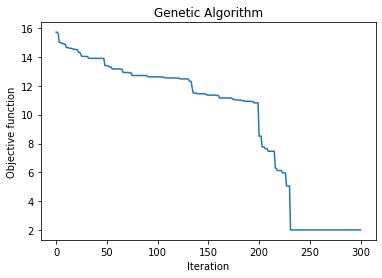

In [68]:
# 실제 모델 
# function: 머신러닝 모델과 연결하여 함수를 만듬 
# dimension: 몇차원의 문제를 푸는 것이냐? 12개의 미지수를 사용함. 
# variable_type: 유전알고리즘이 찾아주는 것을 무엇으로 할 것이냐 int
model_ga_median = geneticalgorithm(function=object_function_median,
                                   dimension=12,
                                   variable_type='int',
                                   variable_boundaries=varbound,
                                   algorithm_parameters=algorithm_param)

model_ga_median.run()

In [69]:
# 최종결과 보기 
# report: 300번 iteration동안 object의 output값
# output_dict: 최종 solution 있음  
convergence_median = model_ga_median.report
solution_median = model_ga_median.output_dict

print(convergence_median) #  
print(solution_median) # 유전알고리즘이 찾은 값
# like수=28178회, dislike=163회

[15.709630070933041, 15.709630070933041, 15.617534417634513, 15.010045111801508, 15.010045111801508, 14.971234009356015, 14.928189939505268, 14.928189939505268, 14.875450796269476, 14.875450796269476, 14.650252999343667, 14.650252999343667, 14.642291594649178, 14.59864491260113, 14.59864491260113, 14.59864491260113, 14.57439655464447, 14.529140771546817, 14.529140771546817, 14.529140771546817, 14.50256597133034, 14.50256597133034, 14.320059021518379, 14.320059021518379, 14.23372372978371, 14.042488747646054, 14.042488747646054, 14.042488747646054, 14.042488747646054, 14.027442291084633, 14.027442291084633, 14.027442291084633, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.89927111509339, 13.396205366213804, 13.396205366213804, 13.396205366213804, 13

In [70]:
ga_solution = input_conversion(solution_median['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)
print(ga_solution)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

[[3.22270000e+04 2.99000000e+02 7.34570000e+04 2.70000000e+01
  9.40000000e+01 1.07782609e+02 4.18800000e+03 2.20000000e+01
  1.38000000e+02 1.84000000e+02 2.90000000e+01 1.69880000e+04
  1.55396949e+06]]


,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,32227.0,299.0,73457.0,27.0,94.0,107.782609,4188.0,22.0,138.0,184.0,29.0,16988.0,1.553969e+06


In [71]:
# mean_encode값을 원래 값으로 원복
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
print(mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc']))
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'}) #허챠밍

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'}) # 10
ga_solution_df

channel_title
!t Live                  False
& 홍대 쏭카페창현 거리노래방         False
(MUTUBE)와꾸대장봉준           False
* eundaromi              False
- 欢迎订阅 -浙江卫视【奔跑吧】官方频道    False
                         ...  
흔한남매                     False
히스토리                     False
히죽HIZUK                  False
히히튜브                     False
힙합버스                     False
Name: views, Length: 1478, dtype: bool


,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,32227.0,299.0,73457.0,27.0,94.0,107.782609,4188.0,22.0,138.0,184.0,29.0,중고차크루,10


In [72]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'}) #Music 
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,32227.0,299.0,73457.0,27.0,94.0,107.782609,4188.0,22.0,138.0,184.0,29.0,중고차크루,Music


In [73]:
prediction = voting_clf.predict(scaler.transform(ga_solution)) # 왜 scaler.transform사용
print(ga_solution)
print(prediction)
ga_solution_df['Views'] = int(prediction[0])
ga_solution_median = ga_solution_df
ga_solution_median

[[3.22270000e+04 2.99000000e+02 7.34570000e+04 2.70000000e+01
  9.40000000e+01 1.07782609e+02 4.18800000e+03 2.20000000e+01
  1.38000000e+02 1.84000000e+02 2.90000000e+01 1.69880000e+04
  1.55396949e+06]]
[99162.09253684]


,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,32227.0,299.0,73457.0,27.0,94.0,107.782609,4188.0,22.0,138.0,184.0,29.0,중고차크루,Music,99162


#**9. 결과 검토 및 분석: 일반 YouTuber**

In [74]:
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6558.000000,6.558000e+03,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6.558000e+03
mean,21.148216,3.702816e+05,1.533824e+04,522.017993,2374.226593,94.588442,87.229643,85.689235,2.541476,1.586026e+04,21.616956,107.952186,7.277071e+03,50.902485,1085.683883,9.780098,432.711040,43.321134,3.702816e+05,3.702816e+05
std,6.779788,1.662346e+06,1.036956e+05,11337.747492,18748.472408,31.165412,29.405352,29.578320,12.456900,1.086795e+05,17.978007,419.561007,4.705238e+04,195.772203,7539.910674,48.145208,537.183225,19.539754,1.361084e+06,3.700064e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.455550e+04,6.780000e+02,20.000000,150.000000,74.000000,68.000000,66.000000,2.000000,7.352500e+02,8.000000,14.211516,3.325417e+02,6.400000,66.500000,2.795164,120.000000,28.000000,6.107850e+04,1.309392e+05
50%,24.000000,9.915450e+04,2.019500e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.137500e+03,17.000000,35.212064,9.958333e+02,16.478125,199.000000,5.143421,260.000000,41.000000,1.232558e+05,2.772646e+05
75%,25.000000,2.330775e+05,4.765000e+03,142.000000,1086.750000,116.000000,106.000000,105.000000,2.000000,4.921000e+03,30.000000,78.976690,2.398500e+03,37.797115,520.625000,9.075080,535.000000,55.000000,2.420690e+05,4.091292e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [75]:
# 일반적인 views를 찾는 모델은 만들었고
# comment_count가 바뀌면 views수가 어떻게 바뀌는지 궁금하다 
inf_input = copy.deepcopy(model_ga_median)

comment_count_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i # [2]가 comment_count자리이기 때문에 이자리에 숫자를 넣어준다.
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_median.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 906/906 [00:16<00:00, 53.72it/s]


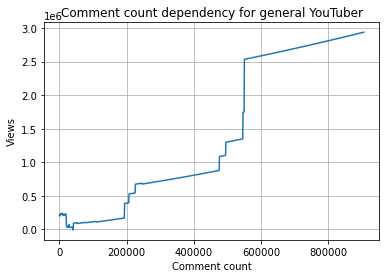

In [76]:
# comment_count가 늘어나면 views가 늘어날 것이다. 
# tree기반알고리즘은 경계에서 값이 튈수있다. 
comment_count_dep_median_df = pd.DataFrame(comment_count_dep_median, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_median_df['comment_count'], comment_count_dep_median_df['views'])

In [77]:
# Positive_ratio바뀌면 views가 어떻게 될지 확인 
# 전제가 total_sign(like수+dislike수의 합)은 변하지 않는다
# like수를 변화시키면 dislike수가 변화할 것이고 이때 Positive_ratio값이 변화하면 views변화를 본다

inf_input = copy.deepcopy(model_ga_median)

positive_ratio_dep_median = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_median.append([ratio, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:09<00:00, 54.36it/s]


<BarContainer object of 500 artists>

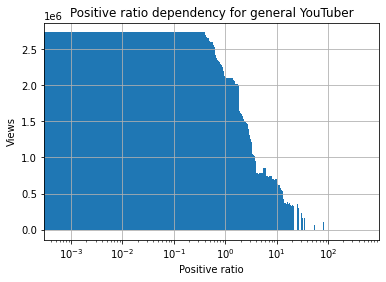

In [78]:
# positive ratio수가 줄어들어야 views수가 늘어난다
positive_ratio_dep_median_df = pd.DataFrame(positive_ratio_dep_median, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for general YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_median_df['positive_ratio'], positive_ratio_dep_median_df['views'])


In [79]:
# number_of_tag 변화에 따른 views수 변화 
# tag수가 적은것이 좋다고 함 10개이내로 좋다. 
inf_input = copy.deepcopy(model_ga_median)

number_of_tag_dep_median = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_median.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 54.56it/s]


<BarContainer object of 125 artists>

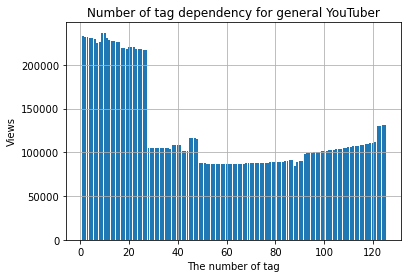

In [80]:
number_of_tag_dep_median_df = pd.DataFrame(number_of_tag_dep_median, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for general YouTuber')
plt.xlabel('The number of tag')
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_median_df['number_of_tag'], number_of_tag_dep_median_df['views'])

In [81]:
# 썸네일 변화 (MC시뮬레이션)
# RGB값의 최소최대값에서 랜덤하게 2000개뽑아서 봄 

inf_input = copy.deepcopy(model_ga_median)

random_image_dep_median = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_median.append([i, int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 52.91it/s]


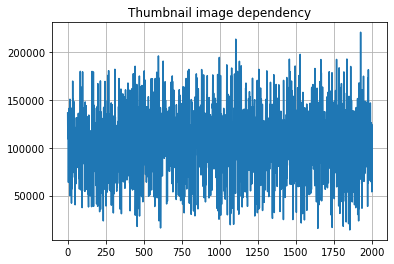

In [82]:
random_image_dep_median_df = pd.DataFrame(random_image_dep_median, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_median_df['Random_image'], random_image_dep_median_df['Views'])

Average views: 105224.4515
Median views: 107731.5
Standard deviation of views [count]: 34885.36066253184
Standard deviation of views     [%]: 33.15328344812693


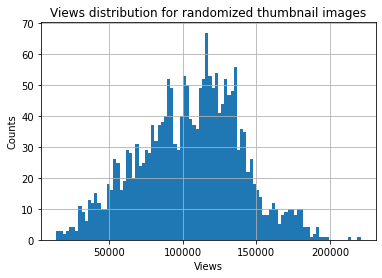

In [83]:
# 썸네일로 views수가 +-29%정도 흔들릴수있다
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_median_df['Views'], bins=96)

print('Average views:', random_image_dep_median_df['Views'].mean())
print('Median views:', random_image_dep_median_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_median_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_median_df['Views'].std()*100 / random_image_dep_median_df['Views'].mean())

In [84]:
# 채널타이틀 영향
inf_input = copy.deepcopy(model_ga_median)

channel_title_dep_median = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_median.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:27<00:00, 54.50it/s]


<BarContainer object of 1478 artists>

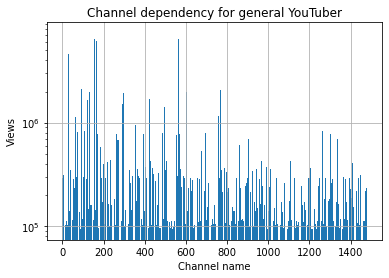

In [85]:
channel_title_dep_median_df = pd.DataFrame(channel_title_dep_median, columns=['channel_title', 'views'])

plt.title('Channel dependency for general YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_median_df['channel_title'])), channel_title_dep_median_df['views'])

In [86]:
channel_title_dep_median_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
624,YouTube Spotlight,7462138
178,FoxStarHindi,7044005
53,ArianaGrandeVevo,6761632
363,Marvel Entertainment,6651412
99,Bruno Mars,6644340
548,TaylorSwiftVEVO,6604256
123,ChildishGambinoVEVO,6569917
677,ibighit,6561920
159,Dude Perfect,6558686
57,AsapSCIENCE,6542270


Average views: 447788.17929634644
Median views: 210137.5
Standard deviation of views [count]: 948066.8597451833
Standard deviation of views     [%]: 211.7221721294595


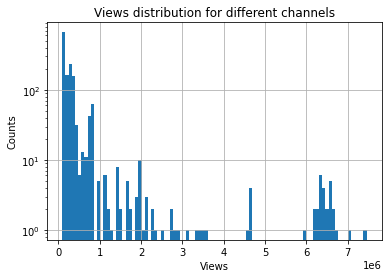

In [87]:
# 일반적인 유튜브영상에는 채널명이 중요하다 
# std가 상당히 크다. 
# 채널이 바뀌면, views수가 줄가능성이 넢다. 왜냐하면 counts수를 보면 더 많은 채널들이 적은 views를 가짐
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_median_df['views'], bins=96)

print('Average views:', channel_title_dep_median_df['views'].mean())
print('Median views:', channel_title_dep_median_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_median_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_median_df['views'].std()*100 / channel_title_dep_median_df['views'].mean())

#**10. 유전 알고리즘 - 최적 피쳐 탐색: Top YouTuber**

In [88]:
# 0: 'likes'
# 1: 'dislikes'
# 2: 'comment_count'
# 3: 'elapsed_day'
# 4: 'number_of_tag'
# 5: 'positive_ratio'
# 6: 'description_length'
# 7: 'title_length'
# 8: 'r_avg'
# 9: 'g_avg'
# 10: 'b_avg'
# 11: 'channel_title_mean_enc'
# 12: 'category_id_mean_enc'

# 변수범위를 넓혀준다
# like, dislike, comment_count 2배로 넓힌다. 
varbound = np.array([[df_rgb2['likes'].min(), df_rgb2['likes'].max()*2],
                     [df_rgb2['dislikes'].min() + 1, df_rgb2['dislikes'].max()*2],
                     [df_rgb2['comment_count'].min() + 1, df_rgb2['comment_count'].max()*2],
                     [df_rgb2['elapsed_day'].min(), df_rgb2['elapsed_day'].max()],
                     [df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max()],
                     [df_rgb2['description_length'].min(), df_rgb2['description_length'].max()],
                     [df_rgb2['title_length'].min(), df_rgb2['title_length'].max()*2],
                     [df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max()],
                     [df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max()],
                     [df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max()],
                     [0, len(mean_encode_channel) - 1],
                     # [0, len(mean_encode_category) - 1]],
                     [2, 2]])

In [89]:
def object_function_top(x_input, target_model=voting_clf):
    input_converted = input_conversion(x_input)
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = target_model.predict(input_scaled)        

    target = 70000000 # 7천만 리즈너블한 범위에서 줘야 잘 찾음 
    print('Predicted views:', int(prediction), 'Difference from target:', int(target - prediction))

    # return abs(int(prediction) - target)
    return math.log(abs(target - int(prediction))) 

In [90]:
# 그대로 값을 준다
algorithm_param = {'max_num_iteration': 300,
                   'population_size': 100,
                   'mutation_probability': 0.1,
                   'elit_ratio': 0.01,
                   'crossover_probability': 0.5,
                   'parents_portion': 0.3,
                   'crossover_type': 'uniform',
                   'max_iteration_without_improv': None}

Predicted views: 13841495 Difference from target: 56158504
Predicted views: 26080255 Difference from target: 43919744
Predicted views: 14932903 Difference from target: 55067096
Predicted views: 14808164 Difference from target: 55191835
Predicted views: 31922234 Difference from target: 38077765
Predicted views: 32754112 Difference from target: 37245887
Predicted views: 24005525 Difference from target: 45994474
Predicted views: 29939573 Difference from target: 40060426
Predicted views: 25595261 Difference from target: 44404738
Predicted views: 32175033 Difference from target: 37824966
Predicted views: 17613137 Difference from target: 52386862
Predicted views: 35742723 Difference from target: 34257276
Predicted views: 32076825 Difference from target: 37923174
Predicted views: 28542897 Difference from target: 41457102
Predicted views: 28387296 Difference from target: 41612703
Predicted views: 24930892 Difference from target: 45069107
Predicted views: 32635993 Difference from target: 373640

Predicted views: 17356897 Difference from target: 52643102
Predicted views: 11214484 Difference from target: 58785515
Predicted views: 23607698 Difference from target: 46392301
Predicted views: 27642488 Difference from target: 42357511
Predicted views: 16146627 Difference from target: 53853372
Predicted views: 38650523 Difference from target: 31349476
Predicted views: 32039822 Difference from target: 37960177
Predicted views: 29175808 Difference from target: 40824191
Predicted views: 25178833 Difference from target: 44821166
Predicted views: 25665769 Difference from target: 44334230
Predicted views: 35017908 Difference from target: 34982091
Predicted views: 24537483 Difference from target: 45462516
Predicted views: 26604021 Difference from target: 43395978
Predicted views: 22523193 Difference from target: 47476806
Predicted views: 28144740 Difference from target: 41855259
Predicted views: 28501082 Difference from target: 41498917
Predicted views: 34427284 Difference from target: 355727

Predicted views: 28907255 Difference from target: 41092744
Predicted views: 25139360 Difference from target: 44860639
Predicted views: 27791039 Difference from target: 42208960
Predicted views: 27813397 Difference from target: 42186602
Predicted views: 46356504 Difference from target: 23643495
Predicted views: 31761981 Difference from target: 38238018
Predicted views: 26509648 Difference from target: 43490351
Predicted views: 9758951 Difference from target: 60241048
Predicted views: 24910190 Difference from target: 45089809
Predicted views: 30113811 Difference from target: 39886188
Predicted views: 31852179 Difference from target: 38147820
Predicted views: 29312392 Difference from target: 40687607
Predicted views: 32815108 Difference from target: 37184891
Predicted views: 36050764 Difference from target: 33949235
Predicted views: 13264692 Difference from target: 56735307
Predicted views: 19834202 Difference from target: 50165797
Predicted views: 29357822 Difference from target: 4064217

Predicted views: 34317005 Difference from target: 35682994
Predicted views: 36713045 Difference from target: 33286954
Predicted views: 28982926 Difference from target: 41017073
Predicted views: 28317348 Difference from target: 41682651
Predicted views: 29302561 Difference from target: 40697438
Predicted views: 25988975 Difference from target: 44011024
Predicted views: 44435201 Difference from target: 25564798
Predicted views: 27594686 Difference from target: 42405313
Predicted views: 28016923 Difference from target: 41983076
Predicted views: 44589054 Difference from target: 25410945
Predicted views: 27976916 Difference from target: 42023083
Predicted views: 47176344 Difference from target: 22823655
Predicted views: 26330711 Difference from target: 43669288
Predicted views: 35418207 Difference from target: 34581792
Predicted views: 34047296 Difference from target: 35952703
Predicted views: 27848607 Difference from target: 42151392
Predicted views: 34670712 Difference from target: 353292

Predicted views: 39077691 Difference from target: 30922308
Predicted views: 33847048 Difference from target: 36152951
Predicted views: 38049666 Difference from target: 31950333
Predicted views: 34911407 Difference from target: 35088592
Predicted views: 29324937 Difference from target: 40675062
Predicted views: 46292861 Difference from target: 23707138
Predicted views: 34485300 Difference from target: 35514699
Predicted views: 35230438 Difference from target: 34769561
Predicted views: 8660951 Difference from target: 61339048
Predicted views: 33565716 Difference from target: 36434283
Predicted views: 35180293 Difference from target: 34819706
Predicted views: 46669706 Difference from target: 23330293
Predicted views: 29017655 Difference from target: 40982344
Predicted views: 39280914 Difference from target: 30719085
Predicted views: 43728021 Difference from target: 26271978
Predicted views: 50453666 Difference from target: 19546333
Predicted views: 33060614 Difference from target: 3693938

Predicted views: 31120509 Difference from target: 38879490
Predicted views: 37912447 Difference from target: 32087552
Predicted views: 38101126 Difference from target: 31898873
Predicted views: 40111898 Difference from target: 29888101
Predicted views: 37350913 Difference from target: 32649086
Predicted views: 49534913 Difference from target: 20465086
Predicted views: 28812417 Difference from target: 41187582
Predicted views: 50155208 Difference from target: 19844791
Predicted views: 29931596 Difference from target: 40068403
Predicted views: 38217165 Difference from target: 31782834
Predicted views: 38815243 Difference from target: 31184756
Predicted views: 28481745 Difference from target: 41518254
Predicted views: 39561968 Difference from target: 30438031
Predicted views: 31283129 Difference from target: 38716870
Predicted views: 33654670 Difference from target: 36345329
Predicted views: 33654670 Difference from target: 36345329
Predicted views: 49746305 Difference from target: 202536

Predicted views: 38685395 Difference from target: 31314604
Predicted views: 49856967 Difference from target: 20143032
Predicted views: 49005444 Difference from target: 20994555
Predicted views: 36468866 Difference from target: 33531133
Predicted views: 48975325 Difference from target: 21024674
Predicted views: 43921707 Difference from target: 26078292
Predicted views: 37659452 Difference from target: 32340547
Predicted views: 33189549 Difference from target: 36810450
Predicted views: 33799096 Difference from target: 36200903
Predicted views: 27242153 Difference from target: 42757846
Predicted views: 45351119 Difference from target: 24648880
Predicted views: 37656024 Difference from target: 32343975
Predicted views: 38325220 Difference from target: 31674779
Predicted views: 49573206 Difference from target: 20426793
Predicted views: 50501736 Difference from target: 19498263
Predicted views: 49072722 Difference from target: 20927277
Predicted views: 51119390 Difference from target: 188806

Predicted views: 45563826 Difference from target: 24436173
Predicted views: 38931202 Difference from target: 31068797
Predicted views: 44917384 Difference from target: 25082615
Predicted views: 49716222 Difference from target: 20283777
Predicted views: 37839092 Difference from target: 32160907
Predicted views: 44457186 Difference from target: 25542813
Predicted views: 49170379 Difference from target: 20829620
Predicted views: 39627676 Difference from target: 30372323
Predicted views: 34369662 Difference from target: 35630337
Predicted views: 34046499 Difference from target: 35953500
Predicted views: 28619916 Difference from target: 41380083
Predicted views: 34574464 Difference from target: 35425535
Predicted views: 49679547 Difference from target: 20320452
Predicted views: 37709774 Difference from target: 32290225
Predicted views: 50533556 Difference from target: 19466443
Predicted views: 35257959 Difference from target: 34742040
Predicted views: 36353448 Difference from target: 336465

Predicted views: 51816953 Difference from target: 18183046
Predicted views: 49520620 Difference from target: 20479379
Predicted views: 51570326 Difference from target: 18429673
Predicted views: 50551621 Difference from target: 19448378
Predicted views: 26716205 Difference from target: 43283794
Predicted views: 47103667 Difference from target: 22896332
Predicted views: 50782989 Difference from target: 19217010
Predicted views: 45494804 Difference from target: 24505195
Predicted views: 39996545 Difference from target: 30003454
Predicted views: 51680371 Difference from target: 18319628
Predicted views: 45622062 Difference from target: 24377937
Predicted views: 38068398 Difference from target: 31931601
Predicted views: 51702942 Difference from target: 18297057
Predicted views: 51731780 Difference from target: 18268219
Predicted views: 43601170 Difference from target: 26398829
Predicted views: 38727030 Difference from target: 31272969
Predicted views: 50983804 Difference from target: 190161

Predicted views: 39323748 Difference from target: 30676251
Predicted views: 38756018 Difference from target: 31243981
Predicted views: 39117120 Difference from target: 30882879
Predicted views: 51664969 Difference from target: 18335030
Predicted views: 39725850 Difference from target: 30274149
Predicted views: 51797278 Difference from target: 18202721
Predicted views: 50882518 Difference from target: 19117481
Predicted views: 38742868 Difference from target: 31257131
Predicted views: 50274450 Difference from target: 19725549
Predicted views: 39288035 Difference from target: 30711964
Predicted views: 39796318 Difference from target: 30203681
Predicted views: 51552836 Difference from target: 18447163
Predicted views: 50035815 Difference from target: 19964184
Predicted views: 48618516 Difference from target: 21381483
Predicted views: 50998039 Difference from target: 19001960
Predicted views: 52047394 Difference from target: 17952605
Predicted views: 40201051 Difference from target: 297989

Predicted views: 38689778 Difference from target: 31310221
Predicted views: 30653319 Difference from target: 39346680
Predicted views: 50799235 Difference from target: 19200764
Predicted views: 49812067 Difference from target: 20187932
Predicted views: 52451615 Difference from target: 17548384
Predicted views: 38528106 Difference from target: 31471893
Predicted views: 45647381 Difference from target: 24352618
Predicted views: 48757035 Difference from target: 21242964
Predicted views: 51181918 Difference from target: 18818081
Predicted views: 38893113 Difference from target: 31106886
Predicted views: 41039678 Difference from target: 28960321
Predicted views: 51920172 Difference from target: 18079827
Predicted views: 39975342 Difference from target: 30024657
Predicted views: 51776707 Difference from target: 18223292
Predicted views: 51576689 Difference from target: 18423310
Predicted views: 49462929 Difference from target: 20537070
Predicted views: 49825153 Difference from target: 201748

Predicted views: 39782183 Difference from target: 30217816
Predicted views: 38666927 Difference from target: 31333072
Predicted views: 49372102 Difference from target: 20627897
Predicted views: 51320744 Difference from target: 18679255
Predicted views: 50288676 Difference from target: 19711323
Predicted views: 50596512 Difference from target: 19403487
Predicted views: 45861959 Difference from target: 24138040
Predicted views: 49377616 Difference from target: 20622383
Predicted views: 51350309 Difference from target: 18649690
Predicted views: 49675558 Difference from target: 20324441
Predicted views: 37674047 Difference from target: 32325952
Predicted views: 40040650 Difference from target: 29959349
Predicted views: 50097368 Difference from target: 19902631
Predicted views: 38369637 Difference from target: 31630362
Predicted views: 39581173 Difference from target: 30418826
Predicted views: 51329560 Difference from target: 18670439
Predicted views: 50412951 Difference from target: 195870

Predicted views: 52922478 Difference from target: 17077521
Predicted views: 52385233 Difference from target: 17614766
Predicted views: 52892139 Difference from target: 17107860
Predicted views: 46298929 Difference from target: 23701070
Predicted views: 51859976 Difference from target: 18140023
Predicted views: 52837940 Difference from target: 17162059
Predicted views: 51132101 Difference from target: 18867898
Predicted views: 50134579 Difference from target: 19865420
Predicted views: 51478738 Difference from target: 18521261
Predicted views: 51404625 Difference from target: 18595374
Predicted views: 46115155 Difference from target: 23884844
Predicted views: 51101897 Difference from target: 18898102
Predicted views: 51910270 Difference from target: 18089729
Predicted views: 46970593 Difference from target: 23029406
Predicted views: 52838718 Difference from target: 17161281
Predicted views: 51614683 Difference from target: 18385316
Predicted views: 48413945 Difference from target: 215860

Predicted views: 50760688 Difference from target: 19239311
Predicted views: 51513006 Difference from target: 18486993
Predicted views: 41488028 Difference from target: 28511971
Predicted views: 45858017 Difference from target: 24141982
Predicted views: 51840282 Difference from target: 18159717
Predicted views: 51310632 Difference from target: 18689367
Predicted views: 38742905 Difference from target: 31257094
Predicted views: 40112817 Difference from target: 29887182
Predicted views: 46204095 Difference from target: 23795904
Predicted views: 17159449 Difference from target: 52840550
Predicted views: 23950540 Difference from target: 46049459
Predicted views: 51674956 Difference from target: 18325043
Predicted views: 37338247 Difference from target: 32661752
Predicted views: 39169772 Difference from target: 30830227
Predicted views: 39049898 Difference from target: 30950101
Predicted views: 48267713 Difference from target: 21732286
Predicted views: 38571944 Difference from target: 314280

Predicted views: 40224097 Difference from target: 29775902
Predicted views: 38668899 Difference from target: 31331100
Predicted views: 39039987 Difference from target: 30960012
Predicted views: 51056153 Difference from target: 18943846
Predicted views: 27430600 Difference from target: 42569399
Predicted views: 53547046 Difference from target: 16452953
Predicted views: 36879174 Difference from target: 33120825
Predicted views: 40217772 Difference from target: 29782227
Predicted views: 52871874 Difference from target: 17128125
Predicted views: 46024980 Difference from target: 23975019
Predicted views: 49369981 Difference from target: 20630018
Predicted views: 46502302 Difference from target: 23497697
Predicted views: 39669282 Difference from target: 30330717
Predicted views: 51475115 Difference from target: 18524884
Predicted views: 51103463 Difference from target: 18896536
Predicted views: 51652302 Difference from target: 18347697
Predicted views: 37672516 Difference from target: 323274

Predicted views: 51094306 Difference from target: 18905693
Predicted views: 52640268 Difference from target: 17359731
Predicted views: 53749402 Difference from target: 16250597
Predicted views: 45894750 Difference from target: 24105249
Predicted views: 38496617 Difference from target: 31503382
Predicted views: 36789315 Difference from target: 33210684
Predicted views: 36245095 Difference from target: 33754904
Predicted views: 52480115 Difference from target: 17519884
Predicted views: 51940166 Difference from target: 18059833
Predicted views: 45776748 Difference from target: 24223251
Predicted views: 40664514 Difference from target: 29335485
Predicted views: 52977701 Difference from target: 17022298
Predicted views: 53307796 Difference from target: 16692203
Predicted views: 41034603 Difference from target: 28965396
Predicted views: 40837368 Difference from target: 29162631
Predicted views: 49665239 Difference from target: 20334760
Predicted views: 47499074 Difference from target: 225009

Predicted views: 50810254 Difference from target: 19189745
Predicted views: 44422638 Difference from target: 25577361
Predicted views: 39259572 Difference from target: 30740427
Predicted views: 52786980 Difference from target: 17213019
Predicted views: 39984668 Difference from target: 30015331
Predicted views: 43794584 Difference from target: 26205415
Predicted views: 39622004 Difference from target: 30377995
Predicted views: 50843065 Difference from target: 19156934
Predicted views: 46874109 Difference from target: 23125890
Predicted views: 44313468 Difference from target: 25686531
Predicted views: 50461333 Difference from target: 19538666
Predicted views: 33657507 Difference from target: 36342492
Predicted views: 39654716 Difference from target: 30345283
Predicted views: 49499538 Difference from target: 20500461
Predicted views: 28187566 Difference from target: 41812433
Predicted views: 51341248 Difference from target: 18658751
Predicted views: 41225355 Difference from target: 287746

Predicted views: 52416384 Difference from target: 17583615
Predicted views: 51006287 Difference from target: 18993712
Predicted views: 41454071 Difference from target: 28545928
Predicted views: 51742757 Difference from target: 18257242
Predicted views: 50250446 Difference from target: 19749553
Predicted views: 52930907 Difference from target: 17069092
Predicted views: 46430171 Difference from target: 23569828
Predicted views: 52489424 Difference from target: 17510575
Predicted views: 40021841 Difference from target: 29978158
Predicted views: 51748846 Difference from target: 18251153
Predicted views: 41649069 Difference from target: 28350930
Predicted views: 50124281 Difference from target: 19875718
Predicted views: 29232554 Difference from target: 40767445
Predicted views: 49035753 Difference from target: 20964246
Predicted views: 50353733 Difference from target: 19646266
Predicted views: 53180417 Difference from target: 16819582
Predicted views: 49964090 Difference from target: 200359

Predicted views: 49861269 Difference from target: 20138730
Predicted views: 50299682 Difference from target: 19700317
Predicted views: 48918418 Difference from target: 21081581
Predicted views: 54348517 Difference from target: 15651482
Predicted views: 51033761 Difference from target: 18966238
Predicted views: 53292648 Difference from target: 16707351
Predicted views: 28343598 Difference from target: 41656401
Predicted views: 38654485 Difference from target: 31345514
Predicted views: 41060105 Difference from target: 28939894
Predicted views: 52253579 Difference from target: 17746420
Predicted views: 53802446 Difference from target: 16197553
Predicted views: 41679760 Difference from target: 28320239
Predicted views: 52423197 Difference from target: 17576802
Predicted views: 40065303 Difference from target: 29934696
Predicted views: 38168139 Difference from target: 31831860
Predicted views: 52386900 Difference from target: 17613099
Predicted views: 54045189 Difference from target: 159548

Predicted views: 50235200 Difference from target: 19764799
Predicted views: 38852339 Difference from target: 31147660
Predicted views: 25326975 Difference from target: 44673024
Predicted views: 38159114 Difference from target: 31840885
Predicted views: 33208886 Difference from target: 36791113
Predicted views: 50509771 Difference from target: 19490228
Predicted views: 49683737 Difference from target: 20316262
Predicted views: 47170836 Difference from target: 22829163
Predicted views: 30948111 Difference from target: 39051888
Predicted views: 50819107 Difference from target: 19180892
Predicted views: 51200269 Difference from target: 18799730
Predicted views: 51795318 Difference from target: 18204681
Predicted views: 54399199 Difference from target: 15600800
Predicted views: 52018170 Difference from target: 17981829
Predicted views: 53251238 Difference from target: 16748761
Predicted views: 51706868 Difference from target: 18293131
Predicted views: 49349009 Difference from target: 206509

||||||____________________________________________ 13.0% GA is running...Predicted views: 50208268 Difference from target: 19791731
Predicted views: 51386170 Difference from target: 18613829
Predicted views: 53151848 Difference from target: 16848151
Predicted views: 38724989 Difference from target: 31275010
Predicted views: 51051613 Difference from target: 18948386
Predicted views: 39719660 Difference from target: 30280339
Predicted views: 53255586 Difference from target: 16744413
Predicted views: 40378000 Difference from target: 29621999
Predicted views: 47493675 Difference from target: 22506324
Predicted views: 52541835 Difference from target: 17458164
Predicted views: 31063486 Difference from target: 38936513
Predicted views: 53105527 Difference from target: 16894472
Predicted views: 40842946 Difference from target: 29157053
Predicted views: 50864571 Difference from target: 19135428
Predicted views: 52786168 Difference from target: 17213831
Predicted views: 52257452 Difference from 

Predicted views: 52212802 Difference from target: 17787197
|||||||___________________________________________ 13.7% GA is running...Predicted views: 51643458 Difference from target: 18356541
Predicted views: 52424838 Difference from target: 17575161
Predicted views: 39900693 Difference from target: 30099306
Predicted views: 53030013 Difference from target: 16969986
Predicted views: 43670577 Difference from target: 26329422
Predicted views: 53399063 Difference from target: 16600936
Predicted views: 39925626 Difference from target: 30074373
Predicted views: 52792558 Difference from target: 17207441
Predicted views: 53070593 Difference from target: 16929406
Predicted views: 41700610 Difference from target: 28299389
Predicted views: 50667330 Difference from target: 19332669
Predicted views: 38985425 Difference from target: 31014574
Predicted views: 41619588 Difference from target: 28380411
Predicted views: 53814665 Difference from target: 16185334
Predicted views: 46507584 Difference from 

Predicted views: 52184791 Difference from target: 17815208
Predicted views: 52843951 Difference from target: 17156048
Predicted views: 33340523 Difference from target: 36659476
Predicted views: 51414409 Difference from target: 18585590
|||||||___________________________________________ 14.3% GA is running...Predicted views: 52568446 Difference from target: 17431553
Predicted views: 27958330 Difference from target: 42041669
Predicted views: 27454877 Difference from target: 42545122
Predicted views: 53687474 Difference from target: 16312525
Predicted views: 47209334 Difference from target: 22790665
Predicted views: 37923384 Difference from target: 32076615
Predicted views: 35746774 Difference from target: 34253225
Predicted views: 52173695 Difference from target: 17826304
Predicted views: 39598051 Difference from target: 30401948
Predicted views: 26477429 Difference from target: 43522570
Predicted views: 34583076 Difference from target: 35416923
Predicted views: 40025353 Difference from 

Predicted views: 50924301 Difference from target: 19075698
Predicted views: 52472460 Difference from target: 17527539
Predicted views: 47330354 Difference from target: 22669645
Predicted views: 48424763 Difference from target: 21575236
Predicted views: 51130072 Difference from target: 18869927
||||||||__________________________________________ 15.0% GA is running...Predicted views: 54372316 Difference from target: 15627683
Predicted views: 38986471 Difference from target: 31013528
Predicted views: 42061176 Difference from target: 27938823
Predicted views: 51488828 Difference from target: 18511171
Predicted views: 52158172 Difference from target: 17841827
Predicted views: 39467914 Difference from target: 30532085
Predicted views: 52330583 Difference from target: 17669416
Predicted views: 36079044 Difference from target: 33920955
Predicted views: 50160764 Difference from target: 19839235
Predicted views: 51578623 Difference from target: 18421376
Predicted views: 41548416 Difference from 

Predicted views: 36998580 Difference from target: 33001419
Predicted views: 48425343 Difference from target: 21574656
Predicted views: 48188794 Difference from target: 21811205
Predicted views: 41916618 Difference from target: 28083381
Predicted views: 36024199 Difference from target: 33975800
Predicted views: 52162446 Difference from target: 17837553
Predicted views: 35030382 Difference from target: 34969617
Predicted views: 50598644 Difference from target: 19401355
||||||||__________________________________________ 15.7% GA is running...Predicted views: 34635557 Difference from target: 35364442
Predicted views: 35976531 Difference from target: 34023468
Predicted views: 53036373 Difference from target: 16963626
Predicted views: 50865841 Difference from target: 19134158
Predicted views: 52791590 Difference from target: 17208409
Predicted views: 54172803 Difference from target: 15827196
Predicted views: 40106720 Difference from target: 29893279
Predicted views: 40354084 Difference from 

Predicted views: 25601595 Difference from target: 44398404
Predicted views: 39501742 Difference from target: 30498257
Predicted views: 40200250 Difference from target: 29799749
Predicted views: 16104788 Difference from target: 53895211
Predicted views: 40313587 Difference from target: 29686412
Predicted views: 35463892 Difference from target: 34536107
Predicted views: 47756231 Difference from target: 22243768
||||||||__________________________________________ 16.3% GA is running...Predicted views: 46991490 Difference from target: 23008509
Predicted views: 48828240 Difference from target: 21171759
Predicted views: 34907885 Difference from target: 35092114
Predicted views: 53117349 Difference from target: 16882650
Predicted views: 36831088 Difference from target: 33168911
Predicted views: 53377686 Difference from target: 16622313
Predicted views: 38797075 Difference from target: 31202924
Predicted views: 46250183 Difference from target: 23749816
Predicted views: 51741746 Difference from 

Predicted views: 52743045 Difference from target: 17256954
Predicted views: 46468564 Difference from target: 23531435
Predicted views: 47144624 Difference from target: 22855375
Predicted views: 51063926 Difference from target: 18936073
Predicted views: 40942262 Difference from target: 29057737
Predicted views: 52175823 Difference from target: 17824176
||||||||__________________________________________ 17.0% GA is running...Predicted views: 53045609 Difference from target: 16954390
Predicted views: 45190718 Difference from target: 24809281
Predicted views: 52986572 Difference from target: 17013427
Predicted views: 35374545 Difference from target: 34625454
Predicted views: 44713094 Difference from target: 25286905
Predicted views: 44958340 Difference from target: 25041659
Predicted views: 53000128 Difference from target: 16999871
Predicted views: 38654381 Difference from target: 31345618
Predicted views: 52491744 Difference from target: 17508255
Predicted views: 44918014 Difference from 

Predicted views: 49660789 Difference from target: 20339210
Predicted views: 54166382 Difference from target: 15833617
Predicted views: 40457582 Difference from target: 29542417
Predicted views: 31973707 Difference from target: 38026292
Predicted views: 51737140 Difference from target: 18262859
Predicted views: 52605335 Difference from target: 17394664
Predicted views: 51994363 Difference from target: 18005636
|||||||||_________________________________________ 17.7% GA is running...Predicted views: 52513200 Difference from target: 17486799
Predicted views: 40134953 Difference from target: 29865046
Predicted views: 46772810 Difference from target: 23227189
Predicted views: 52602936 Difference from target: 17397063
Predicted views: 46039173 Difference from target: 23960826
Predicted views: 52766722 Difference from target: 17233277
Predicted views: 39126970 Difference from target: 30873029
Predicted views: 40207277 Difference from target: 29792722
Predicted views: 48958813 Difference from 

Predicted views: 51891251 Difference from target: 18108748
Predicted views: 47876252 Difference from target: 22123747
Predicted views: 48171435 Difference from target: 21828564
Predicted views: 48477961 Difference from target: 21522038
Predicted views: 49309623 Difference from target: 20690376
Predicted views: 53570361 Difference from target: 16429638
Predicted views: 49031477 Difference from target: 20968522
|||||||||_________________________________________ 18.3% GA is running...Predicted views: 40126154 Difference from target: 29873845
Predicted views: 51743658 Difference from target: 18256341
Predicted views: 53273761 Difference from target: 16726238
Predicted views: 51983329 Difference from target: 18016670
Predicted views: 40849637 Difference from target: 29150362
Predicted views: 51650623 Difference from target: 18349376
Predicted views: 36623964 Difference from target: 33376035
Predicted views: 44294222 Difference from target: 25705777
Predicted views: 53850732 Difference from 

Predicted views: 51074409 Difference from target: 18925590
Predicted views: 53705349 Difference from target: 16294650
Predicted views: 39877180 Difference from target: 30122819
Predicted views: 53187612 Difference from target: 16812387
Predicted views: 40208711 Difference from target: 29791288
Predicted views: 54685106 Difference from target: 15314893
Predicted views: 40455293 Difference from target: 29544706
Predicted views: 48355163 Difference from target: 21644836
Predicted views: 53263604 Difference from target: 16736395
Predicted views: 53557371 Difference from target: 16442628
||||||||||________________________________________ 19.0% GA is running...Predicted views: 44936362 Difference from target: 25063637
Predicted views: 53176677 Difference from target: 16823322
Predicted views: 53111117 Difference from target: 16888882
Predicted views: 53200461 Difference from target: 16799538
Predicted views: 40171831 Difference from target: 29828168
Predicted views: 49056751 Difference from 

Predicted views: 41406374 Difference from target: 28593625
Predicted views: 54620524 Difference from target: 15379475
Predicted views: 29329405 Difference from target: 40670594
Predicted views: 30499985 Difference from target: 39500014
Predicted views: 40636860 Difference from target: 29363139
Predicted views: 39386363 Difference from target: 30613636
Predicted views: 29526189 Difference from target: 40473810
Predicted views: 37750328 Difference from target: 32249671
Predicted views: 40857171 Difference from target: 29142828
Predicted views: 39518449 Difference from target: 30481550
Predicted views: 40585389 Difference from target: 29414610
Predicted views: 52359528 Difference from target: 17640471
Predicted views: 41440276 Difference from target: 28559723
||||||||||________________________________________ 19.7% GA is running...Predicted views: 38679475 Difference from target: 31320524
Predicted views: 51664411 Difference from target: 18335588
Predicted views: 54556044 Difference from 

Predicted views: 39977446 Difference from target: 30022553
Predicted views: 52176495 Difference from target: 17823504
Predicted views: 40296365 Difference from target: 29703634
Predicted views: 53527346 Difference from target: 16472653
Predicted views: 53219953 Difference from target: 16780046
Predicted views: 39070264 Difference from target: 30929735
Predicted views: 41576988 Difference from target: 28423011
Predicted views: 38832559 Difference from target: 31167440
Predicted views: 53462501 Difference from target: 16537498
Predicted views: 54770309 Difference from target: 15229690
Predicted views: 53550494 Difference from target: 16449505
Predicted views: 41142086 Difference from target: 28857913
Predicted views: 34725377 Difference from target: 35274622
Predicted views: 54048663 Difference from target: 15951336
Predicted views: 53772215 Difference from target: 16227784
||||||||||________________________________________ 20.3% GA is running...Predicted views: 41933654 Difference from 

Predicted views: 53910147 Difference from target: 16089852
Predicted views: 54175599 Difference from target: 15824400
Predicted views: 52505287 Difference from target: 17494712
Predicted views: 53746762 Difference from target: 16253237
Predicted views: 49347005 Difference from target: 20652994
Predicted views: 53726876 Difference from target: 16273123
Predicted views: 54420336 Difference from target: 15579663
Predicted views: 42347072 Difference from target: 27652927
Predicted views: 52216405 Difference from target: 17783594
Predicted views: 48519526 Difference from target: 21480473
Predicted views: 54277461 Difference from target: 15722538
Predicted views: 38534330 Difference from target: 31465669
Predicted views: 41968583 Difference from target: 28031416
Predicted views: 51945850 Difference from target: 18054149
Predicted views: 42367719 Difference from target: 27632280
Predicted views: 41416635 Difference from target: 28583364
Predicted views: 52840943 Difference from target: 171590

Predicted views: 41910519 Difference from target: 28089480
Predicted views: 52715853 Difference from target: 17284146
Predicted views: 52318558 Difference from target: 17681441
Predicted views: 52870927 Difference from target: 17129072
Predicted views: 53650448 Difference from target: 16349551
Predicted views: 53460111 Difference from target: 16539888
Predicted views: 45836981 Difference from target: 24163018
Predicted views: 28507230 Difference from target: 41492769
Predicted views: 48109807 Difference from target: 21890192
Predicted views: 36004357 Difference from target: 33995642
Predicted views: 52963429 Difference from target: 17036570
Predicted views: 39179904 Difference from target: 30820095
Predicted views: 53373992 Difference from target: 16626007
Predicted views: 40637593 Difference from target: 29362406
Predicted views: 41006922 Difference from target: 28993077
Predicted views: 41820605 Difference from target: 28179394
|||||||||||_______________________________________ 21.7%

Predicted views: 47656494 Difference from target: 22343505
Predicted views: 35913142 Difference from target: 34086857
Predicted views: 53124302 Difference from target: 16875697
Predicted views: 39358381 Difference from target: 30641618
Predicted views: 54281296 Difference from target: 15718703
Predicted views: 42034643 Difference from target: 27965356
Predicted views: 40593255 Difference from target: 29406744
Predicted views: 41573899 Difference from target: 28426100
Predicted views: 52392507 Difference from target: 17607492
Predicted views: 48767244 Difference from target: 21232755
Predicted views: 37180720 Difference from target: 32819279
Predicted views: 40320963 Difference from target: 29679036
Predicted views: 53344569 Difference from target: 16655430
Predicted views: 52165402 Difference from target: 17834597
Predicted views: 41753783 Difference from target: 28246216
Predicted views: 53231460 Difference from target: 16768539
Predicted views: 54104327 Difference from target: 158956

Predicted views: 53649576 Difference from target: 16350423
Predicted views: 53515650 Difference from target: 16484349
Predicted views: 49100594 Difference from target: 20899405
Predicted views: 42149253 Difference from target: 27850746
Predicted views: 39718751 Difference from target: 30281248
Predicted views: 53836343 Difference from target: 16163656
Predicted views: 52854711 Difference from target: 17145288
Predicted views: 48164500 Difference from target: 21835499
Predicted views: 51242739 Difference from target: 18757260
Predicted views: 35783138 Difference from target: 34216861
Predicted views: 24142263 Difference from target: 45857736
Predicted views: 20617305 Difference from target: 49382694
Predicted views: 52558155 Difference from target: 17441844
Predicted views: 51869608 Difference from target: 18130391
Predicted views: 47906835 Difference from target: 22093164
Predicted views: 52444800 Difference from target: 17555199
Predicted views: 47685281 Difference from target: 223147

Predicted views: 48274694 Difference from target: 21725305
Predicted views: 46786003 Difference from target: 23213996
Predicted views: 52896445 Difference from target: 17103554
Predicted views: 50149153 Difference from target: 19850846
Predicted views: 35695480 Difference from target: 34304519
Predicted views: 53836599 Difference from target: 16163400
Predicted views: 53017162 Difference from target: 16982837
Predicted views: 46821176 Difference from target: 23178823
Predicted views: 44023616 Difference from target: 25976383
Predicted views: 52635102 Difference from target: 17364897
Predicted views: 41546877 Difference from target: 28453122
Predicted views: 52168619 Difference from target: 17831380
Predicted views: 48612392 Difference from target: 21387607
Predicted views: 52379783 Difference from target: 17620216
Predicted views: 52797317 Difference from target: 17202682
Predicted views: 41900940 Difference from target: 28099059
Predicted views: 35644412 Difference from target: 343555

Predicted views: 53813718 Difference from target: 16186281
Predicted views: 50364915 Difference from target: 19635084
Predicted views: 39673651 Difference from target: 30326348
Predicted views: 42350126 Difference from target: 27649873
Predicted views: 54449431 Difference from target: 15550568
Predicted views: 53836606 Difference from target: 16163393
Predicted views: 47284758 Difference from target: 22715241
Predicted views: 53015766 Difference from target: 16984233
Predicted views: 53258208 Difference from target: 16741791
Predicted views: 45037247 Difference from target: 24962752
Predicted views: 39686321 Difference from target: 30313678
Predicted views: 51773988 Difference from target: 18226011
Predicted views: 53341448 Difference from target: 16658551
Predicted views: 52513088 Difference from target: 17486911
Predicted views: 52486085 Difference from target: 17513914
Predicted views: 51902359 Difference from target: 18097640
Predicted views: 53793118 Difference from target: 162068

Predicted views: 53936398 Difference from target: 16063601
Predicted views: 39592026 Difference from target: 30407973
Predicted views: 53075845 Difference from target: 16924154
Predicted views: 53690546 Difference from target: 16309453
Predicted views: 53756484 Difference from target: 16243515
Predicted views: 54078877 Difference from target: 15921122
Predicted views: 54338734 Difference from target: 15661265
Predicted views: 51959429 Difference from target: 18040570
Predicted views: 51959429 Difference from target: 18040570
Predicted views: 37786352 Difference from target: 32213647
Predicted views: 44358907 Difference from target: 25641092
Predicted views: 49532983 Difference from target: 20467016
Predicted views: 54330805 Difference from target: 15669194
Predicted views: 48124926 Difference from target: 21875073
Predicted views: 52103488 Difference from target: 17896511
Predicted views: 40722192 Difference from target: 29277807
Predicted views: 51185951 Difference from target: 188140

Predicted views: 53715612 Difference from target: 16284387
Predicted views: 54282670 Difference from target: 15717329
Predicted views: 52019601 Difference from target: 17980398
Predicted views: 41229996 Difference from target: 28770003
Predicted views: 46108110 Difference from target: 23891889
Predicted views: 54330567 Difference from target: 15669432
Predicted views: 52213161 Difference from target: 17786838
Predicted views: 44988039 Difference from target: 25011960
Predicted views: 50768926 Difference from target: 19231073
Predicted views: 53463839 Difference from target: 16536160
Predicted views: 54451991 Difference from target: 15548008
Predicted views: 53979178 Difference from target: 16020821
Predicted views: 32597599 Difference from target: 37402400
Predicted views: 43467359 Difference from target: 26532640
Predicted views: 52506207 Difference from target: 17493792
Predicted views: 46863755 Difference from target: 23136244
Predicted views: 31716405 Difference from target: 382835

Predicted views: 48091200 Difference from target: 21908799
Predicted views: 51899285 Difference from target: 18100714
Predicted views: 52009505 Difference from target: 17990494
Predicted views: 52919685 Difference from target: 17080314
Predicted views: 45886515 Difference from target: 24113484
Predicted views: 51176931 Difference from target: 18823068
Predicted views: 50965298 Difference from target: 19034701
Predicted views: 53066364 Difference from target: 16933635
Predicted views: 45842641 Difference from target: 24157358
Predicted views: 39439862 Difference from target: 30560137
Predicted views: 48677248 Difference from target: 21322751
Predicted views: 48197659 Difference from target: 21802340
Predicted views: 52310620 Difference from target: 17689379
Predicted views: 46317804 Difference from target: 23682195
Predicted views: 53023192 Difference from target: 16976807
Predicted views: 53481808 Difference from target: 16518191
Predicted views: 48414727 Difference from target: 215852

Predicted views: 50998054 Difference from target: 19001945
Predicted views: 50162201 Difference from target: 19837798
Predicted views: 36605996 Difference from target: 33394003
Predicted views: 49695671 Difference from target: 20304328
Predicted views: 52209313 Difference from target: 17790686
Predicted views: 52812365 Difference from target: 17187634
Predicted views: 48309552 Difference from target: 21690447
Predicted views: 51380298 Difference from target: 18619701
Predicted views: 48892294 Difference from target: 21107705
Predicted views: 45439852 Difference from target: 24560147
Predicted views: 50118546 Difference from target: 19881453
Predicted views: 52805297 Difference from target: 17194702
Predicted views: 40526957 Difference from target: 29473042
Predicted views: 44798046 Difference from target: 25201953
Predicted views: 52707825 Difference from target: 17292174
Predicted views: 46400007 Difference from target: 23599992
Predicted views: 38145612 Difference from target: 318543

Predicted views: 53653782 Difference from target: 16346217
Predicted views: 47439538 Difference from target: 22560461
Predicted views: 39584953 Difference from target: 30415046
Predicted views: 43512731 Difference from target: 26487268
Predicted views: 38364189 Difference from target: 31635810
Predicted views: 51311808 Difference from target: 18688191
Predicted views: 43960442 Difference from target: 26039557
Predicted views: 51274455 Difference from target: 18725544
Predicted views: 54728837 Difference from target: 15271162
Predicted views: 51425941 Difference from target: 18574058
Predicted views: 51023597 Difference from target: 18976402
Predicted views: 51668247 Difference from target: 18331752
Predicted views: 54678312 Difference from target: 15321687
Predicted views: 50922189 Difference from target: 19077810
Predicted views: 52632738 Difference from target: 17367261
Predicted views: 52536089 Difference from target: 17463910
Predicted views: 47655514 Difference from target: 223444

Predicted views: 52408198 Difference from target: 17591801
Predicted views: 36819932 Difference from target: 33180067
Predicted views: 43842095 Difference from target: 26157904
Predicted views: 42293042 Difference from target: 27706957
Predicted views: 47015439 Difference from target: 22984560
Predicted views: 47903662 Difference from target: 22096337
Predicted views: 35197076 Difference from target: 34802923
Predicted views: 49745687 Difference from target: 20254312
Predicted views: 40420875 Difference from target: 29579124
Predicted views: 42955455 Difference from target: 27044544
Predicted views: 45993358 Difference from target: 24006641
Predicted views: 50506484 Difference from target: 19493515
Predicted views: 47205597 Difference from target: 22794402
Predicted views: 35262073 Difference from target: 34737926
Predicted views: 50198153 Difference from target: 19801846
Predicted views: 51875548 Difference from target: 18124451
Predicted views: 40700679 Difference from target: 292993

Predicted views: 51530205 Difference from target: 18469794
Predicted views: 49500787 Difference from target: 20499212
Predicted views: 42120379 Difference from target: 27879620
Predicted views: 40281311 Difference from target: 29718688
Predicted views: 38521357 Difference from target: 31478642
Predicted views: 53025223 Difference from target: 16974776
Predicted views: 50831925 Difference from target: 19168074
Predicted views: 39942300 Difference from target: 30057699
Predicted views: 41077580 Difference from target: 28922419
Predicted views: 52151131 Difference from target: 17848868
Predicted views: 47470401 Difference from target: 22529598
Predicted views: 49541488 Difference from target: 20458511
Predicted views: 51885828 Difference from target: 18114171
Predicted views: 45988761 Difference from target: 24011238
Predicted views: 47349846 Difference from target: 22650153
Predicted views: 53040365 Difference from target: 16959634
Predicted views: 24964699 Difference from target: 450353

Predicted views: 50883083 Difference from target: 19116916
Predicted views: 50479943 Difference from target: 19520056
Predicted views: 50609292 Difference from target: 19390707
Predicted views: 47795878 Difference from target: 22204121
Predicted views: 40361178 Difference from target: 29638821
Predicted views: 53071674 Difference from target: 16928325
Predicted views: 46328715 Difference from target: 23671284
Predicted views: 42869801 Difference from target: 27130198
Predicted views: 47196695 Difference from target: 22803304
Predicted views: 39351293 Difference from target: 30648706
Predicted views: 50655857 Difference from target: 19344142
Predicted views: 54794086 Difference from target: 15205913
Predicted views: 47768719 Difference from target: 22231280
Predicted views: 48874471 Difference from target: 21125528
Predicted views: 32147633 Difference from target: 37852366
Predicted views: 48398435 Difference from target: 21601564
Predicted views: 53277029 Difference from target: 167229

Predicted views: 53881374 Difference from target: 16118625
Predicted views: 46282072 Difference from target: 23717927
Predicted views: 52003693 Difference from target: 17996306
Predicted views: 24719413 Difference from target: 45280586
Predicted views: 52000367 Difference from target: 17999632
Predicted views: 54488835 Difference from target: 15511164
Predicted views: 52824465 Difference from target: 17175534
Predicted views: 50774907 Difference from target: 19225092
Predicted views: 46361623 Difference from target: 23638376
Predicted views: 52339037 Difference from target: 17660962
Predicted views: 52790826 Difference from target: 17209173
Predicted views: 53753510 Difference from target: 16246489
Predicted views: 51834098 Difference from target: 18165901
Predicted views: 45078509 Difference from target: 24921490
Predicted views: 52380025 Difference from target: 17619974
Predicted views: 45102785 Difference from target: 24897214
Predicted views: 39959201 Difference from target: 300407

Predicted views: 53129526 Difference from target: 16870473
Predicted views: 38372507 Difference from target: 31627492
Predicted views: 52049768 Difference from target: 17950231
Predicted views: 51889939 Difference from target: 18110060
Predicted views: 35991334 Difference from target: 34008665
Predicted views: 50675971 Difference from target: 19324028
Predicted views: 49756533 Difference from target: 20243466
Predicted views: 49493273 Difference from target: 20506726
Predicted views: 38650912 Difference from target: 31349087
Predicted views: 47067763 Difference from target: 22932236
Predicted views: 46698861 Difference from target: 23301138
Predicted views: 52876159 Difference from target: 17123840
Predicted views: 36820324 Difference from target: 33179675
Predicted views: 51910601 Difference from target: 18089398
Predicted views: 51889281 Difference from target: 18110718
Predicted views: 47558251 Difference from target: 22441748
Predicted views: 51002873 Difference from target: 189971

Predicted views: 47700780 Difference from target: 22299219
Predicted views: 53984840 Difference from target: 16015159
Predicted views: 53059947 Difference from target: 16940052
Predicted views: 52948832 Difference from target: 17051167
Predicted views: 51727688 Difference from target: 18272311
Predicted views: 51092837 Difference from target: 18907162
Predicted views: 45653767 Difference from target: 24346232
Predicted views: 53083015 Difference from target: 16916984
Predicted views: 52887520 Difference from target: 17112479
Predicted views: 50609209 Difference from target: 19390790
Predicted views: 50541301 Difference from target: 19458698
Predicted views: 37578712 Difference from target: 32421287
Predicted views: 52247080 Difference from target: 17752919
Predicted views: 51630860 Difference from target: 18369139
Predicted views: 50949955 Difference from target: 19050044
Predicted views: 46157787 Difference from target: 23842212
Predicted views: 45211125 Difference from target: 247888

Predicted views: 38895344 Difference from target: 31104655
Predicted views: 39331946 Difference from target: 30668053
Predicted views: 51986128 Difference from target: 18013871
Predicted views: 52835541 Difference from target: 17164458
Predicted views: 18051432 Difference from target: 51948567
Predicted views: 54849498 Difference from target: 15150501
Predicted views: 53607680 Difference from target: 16392319
Predicted views: 52526588 Difference from target: 17473411
Predicted views: 51913777 Difference from target: 18086222
Predicted views: 39626285 Difference from target: 30373714
Predicted views: 51151469 Difference from target: 18848530
Predicted views: 53563218 Difference from target: 16436781
Predicted views: 39425357 Difference from target: 30574642
Predicted views: 52923544 Difference from target: 17076455
Predicted views: 40500537 Difference from target: 29499462
Predicted views: 52752630 Difference from target: 17247369
Predicted views: 51852649 Difference from target: 181473

Predicted views: 40572964 Difference from target: 29427035
Predicted views: 44786249 Difference from target: 25213750
Predicted views: 52083289 Difference from target: 17916710
Predicted views: 52391135 Difference from target: 17608864
Predicted views: 31573517 Difference from target: 38426482
Predicted views: 51709870 Difference from target: 18290129
Predicted views: 51501361 Difference from target: 18498638
Predicted views: 53996193 Difference from target: 16003806
Predicted views: 46282976 Difference from target: 23717023
Predicted views: 53967263 Difference from target: 16032736
Predicted views: 44762419 Difference from target: 25237580
Predicted views: 37278768 Difference from target: 32721231
Predicted views: 51916759 Difference from target: 18083240
Predicted views: 47310745 Difference from target: 22689254
Predicted views: 52377594 Difference from target: 17622405
Predicted views: 50450890 Difference from target: 19549109
Predicted views: 41107313 Difference from target: 288926

Predicted views: 53225972 Difference from target: 16774027
Predicted views: 50451286 Difference from target: 19548713
Predicted views: 40116265 Difference from target: 29883734
Predicted views: 53728856 Difference from target: 16271143
Predicted views: 50773863 Difference from target: 19226136
Predicted views: 49598061 Difference from target: 20401938
Predicted views: 51766713 Difference from target: 18233286
Predicted views: 49195283 Difference from target: 20804716
Predicted views: 45918480 Difference from target: 24081519
Predicted views: 51128471 Difference from target: 18871528
Predicted views: 32782337 Difference from target: 37217662
Predicted views: 50130874 Difference from target: 19869125
Predicted views: 53731866 Difference from target: 16268133
Predicted views: 51352207 Difference from target: 18647792
Predicted views: 51393415 Difference from target: 18606584
Predicted views: 44131315 Difference from target: 25868684
Predicted views: 50693618 Difference from target: 193063

Predicted views: 40171406 Difference from target: 29828593
Predicted views: 51508824 Difference from target: 18491175
Predicted views: 38570904 Difference from target: 31429095
Predicted views: 40038512 Difference from target: 29961487
Predicted views: 7184501 Difference from target: 62815498
Predicted views: 49377691 Difference from target: 20622308
Predicted views: 50698822 Difference from target: 19301177
Predicted views: 44233786 Difference from target: 25766213
Predicted views: 39857662 Difference from target: 30142337
Predicted views: 45774416 Difference from target: 24225583
Predicted views: 50724430 Difference from target: 19275569
Predicted views: 47151039 Difference from target: 22848960
Predicted views: 52569412 Difference from target: 17430587
Predicted views: 11178191 Difference from target: 58821808
Predicted views: 51781987 Difference from target: 18218012
Predicted views: 51143290 Difference from target: 18856709
Predicted views: 51143290 Difference from target: 1885670

Predicted views: 38437097 Difference from target: 31562902
Predicted views: 51230235 Difference from target: 18769764
Predicted views: 31738859 Difference from target: 38261140
Predicted views: 36860834 Difference from target: 33139165
Predicted views: 39285614 Difference from target: 30714385
Predicted views: 49058064 Difference from target: 20941935
Predicted views: 40919675 Difference from target: 29080324
Predicted views: 48071533 Difference from target: 21928466
Predicted views: 49955192 Difference from target: 20044807
Predicted views: 27382367 Difference from target: 42617632
Predicted views: 47846138 Difference from target: 22153861
Predicted views: 51968121 Difference from target: 18031878
Predicted views: 25919051 Difference from target: 44080948
Predicted views: 41149353 Difference from target: 28850646
Predicted views: 51905357 Difference from target: 18094642
Predicted views: 51905357 Difference from target: 18094642
Predicted views: 45127864 Difference from target: 248721

Predicted views: 51298199 Difference from target: 18701800
Predicted views: 38463553 Difference from target: 31536446
Predicted views: 36853684 Difference from target: 33146315
Predicted views: 50073456 Difference from target: 19926543
Predicted views: 40806012 Difference from target: 29193987
Predicted views: 51738394 Difference from target: 18261605
Predicted views: 34961330 Difference from target: 35038669
Predicted views: 36925066 Difference from target: 33074933
Predicted views: 39206461 Difference from target: 30793538
Predicted views: 47883282 Difference from target: 22116717
Predicted views: 39535800 Difference from target: 30464199
Predicted views: 53119486 Difference from target: 16880513
Predicted views: 36061820 Difference from target: 33938179
Predicted views: 52564862 Difference from target: 17435137
Predicted views: 52823044 Difference from target: 17176955
Predicted views: 51734080 Difference from target: 18265919
Predicted views: 51154698 Difference from target: 188453

Predicted views: 51623009 Difference from target: 18376990
Predicted views: 53823508 Difference from target: 16176491
Predicted views: 38566803 Difference from target: 31433196
Predicted views: 38935473 Difference from target: 31064526
Predicted views: 52764203 Difference from target: 17235796
Predicted views: 51019732 Difference from target: 18980267
Predicted views: 49619679 Difference from target: 20380320
Predicted views: 37635721 Difference from target: 32364278
Predicted views: 39309299 Difference from target: 30690700
Predicted views: 38913827 Difference from target: 31086172
Predicted views: 48856918 Difference from target: 21143081
Predicted views: 54336353 Difference from target: 15663646
Predicted views: 53599701 Difference from target: 16400298
Predicted views: 37535897 Difference from target: 32464102
Predicted views: 52887513 Difference from target: 17112486
Predicted views: 48454929 Difference from target: 21545070
Predicted views: 50609104 Difference from target: 193908

Predicted views: 37655410 Difference from target: 32344589
Predicted views: 40187660 Difference from target: 29812339
Predicted views: 48257126 Difference from target: 21742873
Predicted views: 40894659 Difference from target: 29105340
Predicted views: 38744655 Difference from target: 31255344
Predicted views: 52088291 Difference from target: 17911708
Predicted views: 40093011 Difference from target: 29906988
Predicted views: 52620995 Difference from target: 17379004
Predicted views: 37648650 Difference from target: 32351349
Predicted views: 53862063 Difference from target: 16137936
Predicted views: 53079768 Difference from target: 16920231
Predicted views: 50259068 Difference from target: 19740931
Predicted views: 50588450 Difference from target: 19411549
Predicted views: 50505128 Difference from target: 19494871
Predicted views: 51457175 Difference from target: 18542824
Predicted views: 52849145 Difference from target: 17150854
Predicted views: 51426288 Difference from target: 185737

Predicted views: 51460775 Difference from target: 18539224
Predicted views: 53505249 Difference from target: 16494750
Predicted views: 50400939 Difference from target: 19599060
Predicted views: 51895662 Difference from target: 18104337
Predicted views: 53177351 Difference from target: 16822648
Predicted views: 51207315 Difference from target: 18792684
Predicted views: 50984436 Difference from target: 19015563
Predicted views: 28106521 Difference from target: 41893478
Predicted views: 51687917 Difference from target: 18312082
Predicted views: 45393791 Difference from target: 24606208
Predicted views: 49870552 Difference from target: 20129447
Predicted views: 52039202 Difference from target: 17960797
Predicted views: 51711479 Difference from target: 18288520
Predicted views: 49541630 Difference from target: 20458369
Predicted views: 49556578 Difference from target: 20443421
Predicted views: 51484253 Difference from target: 18515746
Predicted views: 43705468 Difference from target: 262945

Predicted views: 38549594 Difference from target: 31450405
Predicted views: 39308348 Difference from target: 30691651
Predicted views: 40376123 Difference from target: 29623876
Predicted views: 53525695 Difference from target: 16474304
Predicted views: 40600624 Difference from target: 29399375
Predicted views: 52110386 Difference from target: 17889613
Predicted views: 54093377 Difference from target: 15906622
Predicted views: 53437041 Difference from target: 16562958
Predicted views: 50591388 Difference from target: 19408611
Predicted views: 41043781 Difference from target: 28956218
Predicted views: 51598011 Difference from target: 18401988
Predicted views: 41314019 Difference from target: 28685980
Predicted views: 51632821 Difference from target: 18367178
Predicted views: 18346809 Difference from target: 51653190
Predicted views: 52222700 Difference from target: 17777299
Predicted views: 54585329 Difference from target: 15414670
Predicted views: 40442111 Difference from target: 295578

Predicted views: 48719408 Difference from target: 21280591
Predicted views: 49386990 Difference from target: 20613009
Predicted views: 48176825 Difference from target: 21823174
Predicted views: 51326968 Difference from target: 18673031
Predicted views: 52776323 Difference from target: 17223676
Predicted views: 51524553 Difference from target: 18475446
Predicted views: 40287565 Difference from target: 29712434
Predicted views: 47465286 Difference from target: 22534713
Predicted views: 52126950 Difference from target: 17873049
Predicted views: 43109496 Difference from target: 26890503
Predicted views: 40980965 Difference from target: 29019034
Predicted views: 53473637 Difference from target: 16526362
Predicted views: 51749032 Difference from target: 18250967
Predicted views: 52002858 Difference from target: 17997141
Predicted views: 51209114 Difference from target: 18790885
Predicted views: 51156390 Difference from target: 18843609
Predicted views: 51728757 Difference from target: 182712

Predicted views: 54784187 Difference from target: 15215812
Predicted views: 52722745 Difference from target: 17277254
Predicted views: 53466787 Difference from target: 16533212
Predicted views: 40488046 Difference from target: 29511953
Predicted views: 32460602 Difference from target: 37539397
Predicted views: 53628871 Difference from target: 16371128
Predicted views: 52425102 Difference from target: 17574897
Predicted views: 52469412 Difference from target: 17530587
Predicted views: 41660217 Difference from target: 28339782
Predicted views: 54217350 Difference from target: 15782649
Predicted views: 53290789 Difference from target: 16709210
Predicted views: 52720786 Difference from target: 17279213
Predicted views: 51184539 Difference from target: 18815460
Predicted views: 49163134 Difference from target: 20836865
Predicted views: 52251009 Difference from target: 17748990
Predicted views: 54151234 Difference from target: 15848765
Predicted views: 40394822 Difference from target: 296051

Predicted views: 41845088 Difference from target: 28154911
Predicted views: 51886868 Difference from target: 18113131
Predicted views: 54457394 Difference from target: 15542605
Predicted views: 41774564 Difference from target: 28225435
Predicted views: 53120716 Difference from target: 16879283
Predicted views: 53718424 Difference from target: 16281575
Predicted views: 40461487 Difference from target: 29538512
Predicted views: 52282902 Difference from target: 17717097
Predicted views: 52426303 Difference from target: 17573696
Predicted views: 53693071 Difference from target: 16306928
Predicted views: 53592162 Difference from target: 16407837
Predicted views: 40968704 Difference from target: 29031295
Predicted views: 54055978 Difference from target: 15944021
Predicted views: 53692791 Difference from target: 16307208
Predicted views: 53658408 Difference from target: 16341591
Predicted views: 42237499 Difference from target: 27762500
Predicted views: 42732337 Difference from target: 272676

Predicted views: 39953149 Difference from target: 30046850
Predicted views: 42961070 Difference from target: 27038929
Predicted views: 41294737 Difference from target: 28705262
Predicted views: 52446787 Difference from target: 17553212
Predicted views: 53576341 Difference from target: 16423658
Predicted views: 42411950 Difference from target: 27588049
Predicted views: 53741187 Difference from target: 16258812
Predicted views: 53852140 Difference from target: 16147859
Predicted views: 53193197 Difference from target: 16806802
Predicted views: 50682392 Difference from target: 19317607
Predicted views: 52287288 Difference from target: 17712711
Predicted views: 29596888 Difference from target: 40403111
Predicted views: 52898350 Difference from target: 17101649
Predicted views: 52238542 Difference from target: 17761457
Predicted views: 42101729 Difference from target: 27898270
Predicted views: 51427176 Difference from target: 18572823
Predicted views: 53743193 Difference from target: 162568

Predicted views: 53050609 Difference from target: 16949390
Predicted views: 51546784 Difference from target: 18453215
Predicted views: 39497755 Difference from target: 30502244
Predicted views: 54313239 Difference from target: 15686760
Predicted views: 52998030 Difference from target: 17001969
Predicted views: 53815404 Difference from target: 16184595
Predicted views: 50146683 Difference from target: 19853316
Predicted views: 33841483 Difference from target: 36158516
Predicted views: 35384786 Difference from target: 34615213
Predicted views: 54318448 Difference from target: 15681551
Predicted views: 54137804 Difference from target: 15862195
Predicted views: 30113922 Difference from target: 39886077
Predicted views: 51037152 Difference from target: 18962847
Predicted views: 53302199 Difference from target: 16697800
Predicted views: 52597551 Difference from target: 17402448
Predicted views: 42189778 Difference from target: 27810221
Predicted views: 46352897 Difference from target: 236471

|||||||||||||||||||||_____________________________ 42.0% GA is running...Predicted views: 42579756 Difference from target: 27420243
Predicted views: 47765959 Difference from target: 22234040
Predicted views: 52615780 Difference from target: 17384219
Predicted views: 30063754 Difference from target: 39936245
Predicted views: 33839532 Difference from target: 36160467
Predicted views: 42959083 Difference from target: 27040916
Predicted views: 50945158 Difference from target: 19054841
Predicted views: 53513145 Difference from target: 16486854
Predicted views: 51466492 Difference from target: 18533507
Predicted views: 51125279 Difference from target: 18874720
Predicted views: 40226607 Difference from target: 29773392
Predicted views: 39611043 Difference from target: 30388956
Predicted views: 51634379 Difference from target: 18365620
Predicted views: 29963535 Difference from target: 40036464
Predicted views: 35231516 Difference from target: 34768483
Predicted views: 53770871 Difference from 

|||||||||||||||||||||_____________________________ 42.7% GA is running...Predicted views: 51018777 Difference from target: 18981222
Predicted views: 40551313 Difference from target: 29448686
Predicted views: 38254429 Difference from target: 31745570
Predicted views: 53749253 Difference from target: 16250746
Predicted views: 45999143 Difference from target: 24000856
Predicted views: 51137136 Difference from target: 18862863
Predicted views: 51739008 Difference from target: 18260991
Predicted views: 39653894 Difference from target: 30346105
Predicted views: 51530357 Difference from target: 18469642
Predicted views: 52620133 Difference from target: 17379866
Predicted views: 52305763 Difference from target: 17694236
Predicted views: 53005337 Difference from target: 16994662
Predicted views: 49724226 Difference from target: 20275773
Predicted views: 52536597 Difference from target: 17463402
Predicted views: 50291160 Difference from target: 19708839
Predicted views: 40871561 Difference from 

Predicted views: 41407736 Difference from target: 28592263
Predicted views: 30259709 Difference from target: 39740290
||||||||||||||||||||||____________________________ 43.3% GA is running...Predicted views: 45469533 Difference from target: 24530466
Predicted views: 50878720 Difference from target: 19121279
Predicted views: 52203164 Difference from target: 17796835
Predicted views: 40310579 Difference from target: 29689420
Predicted views: 45453184 Difference from target: 24546815
Predicted views: 46715793 Difference from target: 23284206
Predicted views: 43144585 Difference from target: 26855414
Predicted views: 39876086 Difference from target: 30123913
Predicted views: 43703765 Difference from target: 26296234
Predicted views: 26105104 Difference from target: 43894895
Predicted views: 52246889 Difference from target: 17753110
Predicted views: 45459403 Difference from target: 24540596
Predicted views: 26422893 Difference from target: 43577106
Predicted views: 40698791 Difference from 

Predicted views: 39560928 Difference from target: 30439071
Predicted views: 36218229 Difference from target: 33781770
Predicted views: 51336553 Difference from target: 18663446
Predicted views: 39383366 Difference from target: 30616633
Predicted views: 40563795 Difference from target: 29436204
||||||||||||||||||||||____________________________ 44.0% GA is running...Predicted views: 47741544 Difference from target: 22258455
Predicted views: 44357630 Difference from target: 25642369
Predicted views: 50862568 Difference from target: 19137431
Predicted views: 51286896 Difference from target: 18713103
Predicted views: 46372783 Difference from target: 23627216
Predicted views: 39467139 Difference from target: 30532860
Predicted views: 47207316 Difference from target: 22792683
Predicted views: 51651764 Difference from target: 18348235
Predicted views: 41272473 Difference from target: 28727526
Predicted views: 43088118 Difference from target: 26911881
Predicted views: 50824427 Difference from 

Predicted views: 51383186 Difference from target: 18616813
Predicted views: 52660586 Difference from target: 17339413
Predicted views: 36189460 Difference from target: 33810539
Predicted views: 30568025 Difference from target: 39431974
Predicted views: 52264051 Difference from target: 17735948
Predicted views: 52194358 Difference from target: 17805641
Predicted views: 19965168 Difference from target: 50034831
Predicted views: 51945145 Difference from target: 18054854
||||||||||||||||||||||____________________________ 44.7% GA is running...Predicted views: 52135673 Difference from target: 17864326
Predicted views: 52048919 Difference from target: 17951080
Predicted views: 41425689 Difference from target: 28574310
Predicted views: 40231403 Difference from target: 29768596
Predicted views: 51470860 Difference from target: 18529139
Predicted views: 41075120 Difference from target: 28924879
Predicted views: 40865673 Difference from target: 29134326
Predicted views: 39245795 Difference from 

Predicted views: 36072329 Difference from target: 33927670
Predicted views: 53101695 Difference from target: 16898304
Predicted views: 51263925 Difference from target: 18736074
Predicted views: 52727918 Difference from target: 17272081
Predicted views: 46688712 Difference from target: 23311287
Predicted views: 43879681 Difference from target: 26120318
Predicted views: 25259008 Difference from target: 44740991
Predicted views: 42537004 Difference from target: 27462995
|||||||||||||||||||||||___________________________ 45.3% GA is running...Predicted views: 34549774 Difference from target: 35450225
Predicted views: 46200039 Difference from target: 23799960
Predicted views: 40988185 Difference from target: 29011814
Predicted views: 45462330 Difference from target: 24537669
Predicted views: 32521918 Difference from target: 37478081
Predicted views: 50863429 Difference from target: 19136570
Predicted views: 50923082 Difference from target: 19076917
Predicted views: 42212971 Difference from 

Predicted views: 38106212 Difference from target: 31893787
Predicted views: 49095584 Difference from target: 20904415
Predicted views: 25662152 Difference from target: 44337847
Predicted views: 50658647 Difference from target: 19341352
Predicted views: 32748341 Difference from target: 37251658
Predicted views: 51074968 Difference from target: 18925031
Predicted views: 42922000 Difference from target: 27077999
Predicted views: 50609877 Difference from target: 19390122
Predicted views: 41795581 Difference from target: 28204418
Predicted views: 53005291 Difference from target: 16994708
Predicted views: 30310599 Difference from target: 39689400
|||||||||||||||||||||||___________________________ 46.0% GA is running...Predicted views: 46025777 Difference from target: 23974222
Predicted views: 51376314 Difference from target: 18623685
Predicted views: 46217741 Difference from target: 23782258
Predicted views: 40079430 Difference from target: 29920569
Predicted views: 49819469 Difference from 

Predicted views: 40465098 Difference from target: 29534901
Predicted views: 52148115 Difference from target: 17851884
Predicted views: 52418627 Difference from target: 17581372
Predicted views: 48963465 Difference from target: 21036534
Predicted views: 38621838 Difference from target: 31378161
Predicted views: 38821393 Difference from target: 31178606
Predicted views: 39402094 Difference from target: 30597905
Predicted views: 34107332 Difference from target: 35892667
Predicted views: 52020776 Difference from target: 17979223
Predicted views: 52497954 Difference from target: 17502045
Predicted views: 51369583 Difference from target: 18630416
Predicted views: 51128040 Difference from target: 18871959
Predicted views: 40529563 Difference from target: 29470436
|||||||||||||||||||||||___________________________ 46.7% GA is running...Predicted views: 39110437 Difference from target: 30889562
Predicted views: 39110437 Difference from target: 30889562
Predicted views: 51971977 Difference from 

Predicted views: 51994140 Difference from target: 18005859
Predicted views: 41933084 Difference from target: 28066915
Predicted views: 44994738 Difference from target: 25005261
Predicted views: 38134492 Difference from target: 31865507
Predicted views: 50926073 Difference from target: 19073926
Predicted views: 34975276 Difference from target: 35024723
Predicted views: 29446551 Difference from target: 40553448
Predicted views: 37862236 Difference from target: 32137763
Predicted views: 39670857 Difference from target: 30329142
Predicted views: 37782283 Difference from target: 32217716
Predicted views: 51094174 Difference from target: 18905825
Predicted views: 45852122 Difference from target: 24147877
Predicted views: 52907200 Difference from target: 17092799
Predicted views: 42533913 Difference from target: 27466086
Predicted views: 39791686 Difference from target: 30208313
||||||||||||||||||||||||__________________________ 47.3% GA is running...Predicted views: 52535733 Difference from 

Predicted views: 50966383 Difference from target: 19033616
Predicted views: 51278688 Difference from target: 18721311
Predicted views: 39079191 Difference from target: 30920808
Predicted views: 39264726 Difference from target: 30735273
Predicted views: 48512454 Difference from target: 21487545
Predicted views: 22079993 Difference from target: 47920006
Predicted views: 46153040 Difference from target: 23846959
Predicted views: 47450824 Difference from target: 22549175
Predicted views: 51749070 Difference from target: 18250929
Predicted views: 43171032 Difference from target: 26828967
Predicted views: 34249957 Difference from target: 35750042
Predicted views: 41243100 Difference from target: 28756899
Predicted views: 29840250 Difference from target: 40159749
Predicted views: 32624565 Difference from target: 37375434
Predicted views: 46141605 Difference from target: 23858394
||||||||||||||||||||||||__________________________ 48.0% GA is running...Predicted views: 50484399 Difference from 

Predicted views: 54021947 Difference from target: 15978052
Predicted views: 48316529 Difference from target: 21683470
Predicted views: 50807468 Difference from target: 19192531
Predicted views: 52437893 Difference from target: 17562106
Predicted views: 49729116 Difference from target: 20270883
Predicted views: 37416953 Difference from target: 32583046
Predicted views: 51243565 Difference from target: 18756434
Predicted views: 52325066 Difference from target: 17674933
Predicted views: 53500066 Difference from target: 16499933
Predicted views: 41907127 Difference from target: 28092872
Predicted views: 47140053 Difference from target: 22859946
Predicted views: 38576887 Difference from target: 31423112
Predicted views: 41166215 Difference from target: 28833784
Predicted views: 35289881 Difference from target: 34710118
Predicted views: 52404194 Difference from target: 17595805
Predicted views: 51749207 Difference from target: 18250792
||||||||||||||||||||||||__________________________ 48.7%

Predicted views: 46308423 Difference from target: 23691576
Predicted views: 37791804 Difference from target: 32208195
Predicted views: 42655080 Difference from target: 27344919
Predicted views: 41320160 Difference from target: 28679839
Predicted views: 53574412 Difference from target: 16425587
Predicted views: 47929553 Difference from target: 22070446
Predicted views: 54095031 Difference from target: 15904968
Predicted views: 46328218 Difference from target: 23671781
Predicted views: 41343136 Difference from target: 28656863
Predicted views: 51012410 Difference from target: 18987589
Predicted views: 43063297 Difference from target: 26936702
Predicted views: 53079768 Difference from target: 16920231
Predicted views: 54838484 Difference from target: 15161515
Predicted views: 53813375 Difference from target: 16186624
Predicted views: 49529965 Difference from target: 20470034
Predicted views: 51151659 Difference from target: 18848340
Predicted views: 42066399 Difference from target: 279336

Predicted views: 53180077 Difference from target: 16819922
Predicted views: 53103601 Difference from target: 16896398
Predicted views: 51816420 Difference from target: 18183579
Predicted views: 53322617 Difference from target: 16677382
Predicted views: 53500428 Difference from target: 16499571
Predicted views: 47500898 Difference from target: 22499101
Predicted views: 53888952 Difference from target: 16111047
Predicted views: 48825914 Difference from target: 21174085
Predicted views: 47876941 Difference from target: 22123058
Predicted views: 37198678 Difference from target: 32801321
Predicted views: 53231042 Difference from target: 16768957
Predicted views: 50643199 Difference from target: 19356800
Predicted views: 49217731 Difference from target: 20782268
Predicted views: 48195031 Difference from target: 21804968
Predicted views: 48183840 Difference from target: 21816159
Predicted views: 48183840 Difference from target: 21816159
Predicted views: 52870529 Difference from target: 171294

Predicted views: 43337161 Difference from target: 26662838
Predicted views: 52052496 Difference from target: 17947503
Predicted views: 51958390 Difference from target: 18041609
Predicted views: 53835946 Difference from target: 16164053
Predicted views: 52019488 Difference from target: 17980511
Predicted views: 51423055 Difference from target: 18576944
Predicted views: 52039084 Difference from target: 17960915
Predicted views: 50645195 Difference from target: 19354804
Predicted views: 40045564 Difference from target: 29954435
Predicted views: 48525088 Difference from target: 21474911
Predicted views: 46938544 Difference from target: 23061455
Predicted views: 52595003 Difference from target: 17404996
Predicted views: 49903824 Difference from target: 20096175
Predicted views: 52516042 Difference from target: 17483957
Predicted views: 52781322 Difference from target: 17218677
Predicted views: 51552038 Difference from target: 18447961
Predicted views: 54433993 Difference from target: 155660

Predicted views: 47483644 Difference from target: 22516355
Predicted views: 40439237 Difference from target: 29560762
Predicted views: 40454624 Difference from target: 29545375
Predicted views: 52628642 Difference from target: 17371357
Predicted views: 53186397 Difference from target: 16813602
Predicted views: 52221611 Difference from target: 17778388
Predicted views: 27770423 Difference from target: 42229576
Predicted views: 50091534 Difference from target: 19908465
Predicted views: 51570243 Difference from target: 18429756
Predicted views: 53716669 Difference from target: 16283330
Predicted views: 51392305 Difference from target: 18607694
Predicted views: 53146462 Difference from target: 16853537
Predicted views: 50823884 Difference from target: 19176115
Predicted views: 52836677 Difference from target: 17163322
Predicted views: 38716969 Difference from target: 31283030
Predicted views: 49527187 Difference from target: 20472812
Predicted views: 46359493 Difference from target: 236405

Predicted views: 40687994 Difference from target: 29312005
Predicted views: 54277383 Difference from target: 15722616
Predicted views: 53269552 Difference from target: 16730447
Predicted views: 49932059 Difference from target: 20067940
Predicted views: 39450824 Difference from target: 30549175
Predicted views: 40501355 Difference from target: 29498644
Predicted views: 52055737 Difference from target: 17944262
Predicted views: 46275928 Difference from target: 23724071
Predicted views: 37939410 Difference from target: 32060589
Predicted views: 32878226 Difference from target: 37121773
Predicted views: 53979290 Difference from target: 16020709
Predicted views: 32397695 Difference from target: 37602304
Predicted views: 49078647 Difference from target: 20921352
Predicted views: 38953384 Difference from target: 31046615
Predicted views: 52088267 Difference from target: 17911732
Predicted views: 49957597 Difference from target: 20042402
Predicted views: 50502370 Difference from target: 194976

Predicted views: 40197184 Difference from target: 29802815
Predicted views: 41053805 Difference from target: 28946194
Predicted views: 53382653 Difference from target: 16617346
Predicted views: 52809786 Difference from target: 17190213
Predicted views: 52294679 Difference from target: 17705320
Predicted views: 53441304 Difference from target: 16558695
Predicted views: 50490976 Difference from target: 19509023
Predicted views: 39777421 Difference from target: 30222578
Predicted views: 32165639 Difference from target: 37834360
Predicted views: 53307559 Difference from target: 16692440
Predicted views: 14154105 Difference from target: 55845894
Predicted views: 29103722 Difference from target: 40896277
Predicted views: 44123296 Difference from target: 25876703
Predicted views: 39909633 Difference from target: 30090366
Predicted views: 52320737 Difference from target: 17679262
Predicted views: 31872398 Difference from target: 38127601
Predicted views: 50838170 Difference from target: 191618

Predicted views: 30948241 Difference from target: 39051758
Predicted views: 51817684 Difference from target: 18182315
Predicted views: 52667373 Difference from target: 17332626
Predicted views: 32748121 Difference from target: 37251878
Predicted views: 38976516 Difference from target: 31023483
Predicted views: 41944965 Difference from target: 28055034
Predicted views: 47472901 Difference from target: 22527098
Predicted views: 38662482 Difference from target: 31337517
Predicted views: 29951739 Difference from target: 40048260
Predicted views: 52992221 Difference from target: 17007778
Predicted views: 51122851 Difference from target: 18877148
Predicted views: 46868616 Difference from target: 23131383
Predicted views: 54313832 Difference from target: 15686167
Predicted views: 51392437 Difference from target: 18607562
Predicted views: 40875132 Difference from target: 29124867
Predicted views: 53785740 Difference from target: 16214259
Predicted views: 44209139 Difference from target: 257908

Predicted views: 53584247 Difference from target: 16415752
Predicted views: 24102606 Difference from target: 45897393
Predicted views: 50235270 Difference from target: 19764729
Predicted views: 44225902 Difference from target: 25774097
Predicted views: 38982645 Difference from target: 31017354
Predicted views: 52382219 Difference from target: 17617780
Predicted views: 54691241 Difference from target: 15308758
Predicted views: 51157662 Difference from target: 18842337
Predicted views: 52103090 Difference from target: 17896909
Predicted views: 39824877 Difference from target: 30175122
Predicted views: 35091342 Difference from target: 34908657
Predicted views: 29621961 Difference from target: 40378038
Predicted views: 40715102 Difference from target: 29284897
Predicted views: 37434037 Difference from target: 32565962
Predicted views: 31633503 Difference from target: 38366496
Predicted views: 28674532 Difference from target: 41325467
Predicted views: 47664438 Difference from target: 223355

Predicted views: 46384209 Difference from target: 23615790
Predicted views: 39490972 Difference from target: 30509027
Predicted views: 40697339 Difference from target: 29302660
Predicted views: 41338255 Difference from target: 28661744
Predicted views: 50174343 Difference from target: 19825656
Predicted views: 29788045 Difference from target: 40211954
Predicted views: 39790380 Difference from target: 30209619
Predicted views: 41474765 Difference from target: 28525234
Predicted views: 53149711 Difference from target: 16850288
Predicted views: 54489839 Difference from target: 15510160
Predicted views: 40184880 Difference from target: 29815119
Predicted views: 53585578 Difference from target: 16414421
Predicted views: 39878602 Difference from target: 30121397
Predicted views: 45173306 Difference from target: 24826693
Predicted views: 54785122 Difference from target: 15214877
Predicted views: 54240456 Difference from target: 15759543
Predicted views: 38113538 Difference from target: 318864

Predicted views: 54992691 Difference from target: 15007308
Predicted views: 41796151 Difference from target: 28203848
Predicted views: 53688280 Difference from target: 16311719
Predicted views: 52628378 Difference from target: 17371621
Predicted views: 53949106 Difference from target: 16050893
Predicted views: 54140238 Difference from target: 15859761
Predicted views: 41706521 Difference from target: 28293478
Predicted views: 18072098 Difference from target: 51927901
Predicted views: 26892889 Difference from target: 43107110
Predicted views: 40881451 Difference from target: 29118548
Predicted views: 40547583 Difference from target: 29452416
Predicted views: 41202728 Difference from target: 28797271
Predicted views: 53797707 Difference from target: 16202292
Predicted views: 37799340 Difference from target: 32200659
Predicted views: 20810265 Difference from target: 49189734
Predicted views: 28947947 Difference from target: 41052052
Predicted views: 38587283 Difference from target: 314127

Predicted views: 40486681 Difference from target: 29513318
Predicted views: 37570407 Difference from target: 32429592
Predicted views: 43124432 Difference from target: 26875567
Predicted views: 52588425 Difference from target: 17411574
Predicted views: 52588425 Difference from target: 17411574
Predicted views: 29476283 Difference from target: 40523716
Predicted views: 28523537 Difference from target: 41476462
Predicted views: 54400702 Difference from target: 15599297
Predicted views: 53137713 Difference from target: 16862286
Predicted views: 53939280 Difference from target: 16060719
Predicted views: 42773582 Difference from target: 27226417
Predicted views: 38026144 Difference from target: 31973855
Predicted views: 42624709 Difference from target: 27375290
Predicted views: 41133175 Difference from target: 28866824
Predicted views: 54086063 Difference from target: 15913936
Predicted views: 45836804 Difference from target: 24163195
Predicted views: 42300432 Difference from target: 276995

Predicted views: 42582577 Difference from target: 27417422
Predicted views: 42809717 Difference from target: 27190282
Predicted views: 42579873 Difference from target: 27420126
Predicted views: 52978052 Difference from target: 17021947
Predicted views: 42095337 Difference from target: 27904662
Predicted views: 52066383 Difference from target: 17933616
Predicted views: 37578813 Difference from target: 32421186
Predicted views: 54787013 Difference from target: 15212986
Predicted views: 39536735 Difference from target: 30463264
Predicted views: 47737707 Difference from target: 22262292
Predicted views: 42637712 Difference from target: 27362287
Predicted views: 51828084 Difference from target: 18171915
Predicted views: 52582243 Difference from target: 17417756
Predicted views: 42767433 Difference from target: 27232566
Predicted views: 51776770 Difference from target: 18223229
Predicted views: 54371034 Difference from target: 15628965
Predicted views: 53464155 Difference from target: 165358

Predicted views: 41462527 Difference from target: 28537472
Predicted views: 43586553 Difference from target: 26413446
Predicted views: 48951882 Difference from target: 21048117
Predicted views: 28534453 Difference from target: 41465546
Predicted views: 54156988 Difference from target: 15843011
Predicted views: 42676024 Difference from target: 27323975
Predicted views: 52345432 Difference from target: 17654567
Predicted views: 39935782 Difference from target: 30064217
Predicted views: 42056317 Difference from target: 27943682
Predicted views: 35180604 Difference from target: 34819395
Predicted views: 39624463 Difference from target: 30375536
Predicted views: 54004418 Difference from target: 15995581
Predicted views: 39993081 Difference from target: 30006918
Predicted views: 31293960 Difference from target: 38706039
Predicted views: 38933937 Difference from target: 31066062
Predicted views: 27723967 Difference from target: 42276032
Predicted views: 44461325 Difference from target: 255386

Predicted views: 37219513 Difference from target: 32780486
Predicted views: 49315152 Difference from target: 20684847
Predicted views: 49896437 Difference from target: 20103562
Predicted views: 36193757 Difference from target: 33806242
Predicted views: 41707347 Difference from target: 28292652
Predicted views: 50201271 Difference from target: 19798728
Predicted views: 54800482 Difference from target: 15199517
Predicted views: 34819726 Difference from target: 35180273
Predicted views: 50474298 Difference from target: 19525701
Predicted views: 47863832 Difference from target: 22136167
Predicted views: 41314020 Difference from target: 28685979
Predicted views: 53534256 Difference from target: 16465743
Predicted views: 55030878 Difference from target: 14969121
Predicted views: 55030878 Difference from target: 14969121
Predicted views: 51777463 Difference from target: 18222536
Predicted views: 42773253 Difference from target: 27226746
Predicted views: 46339382 Difference from target: 236606

Predicted views: 50127625 Difference from target: 19872374
Predicted views: 41162636 Difference from target: 28837363
Predicted views: 52635870 Difference from target: 17364129
Predicted views: 42277855 Difference from target: 27722144
Predicted views: 49489866 Difference from target: 20510133
Predicted views: 44801526 Difference from target: 25198473
Predicted views: 42001298 Difference from target: 27998701
Predicted views: 36024911 Difference from target: 33975088
Predicted views: 54598266 Difference from target: 15401733
Predicted views: 53467488 Difference from target: 16532511
Predicted views: 47258165 Difference from target: 22741834
Predicted views: 43734020 Difference from target: 26265979
Predicted views: 37305367 Difference from target: 32694632
Predicted views: 50108028 Difference from target: 19891971
Predicted views: 39897986 Difference from target: 30102013
Predicted views: 50018174 Difference from target: 19981825
Predicted views: 41018786 Difference from target: 289812

Predicted views: 53674328 Difference from target: 16325671
Predicted views: 53051900 Difference from target: 16948099
Predicted views: 45760125 Difference from target: 24239874
Predicted views: 34906163 Difference from target: 35093836
Predicted views: 35538819 Difference from target: 34461180
Predicted views: 53664536 Difference from target: 16335463
Predicted views: 53779569 Difference from target: 16220430
Predicted views: 42373065 Difference from target: 27626934
Predicted views: 36383671 Difference from target: 33616328
Predicted views: 53264140 Difference from target: 16735859
Predicted views: 30270816 Difference from target: 39729183
Predicted views: 36902911 Difference from target: 33097088
Predicted views: 53044693 Difference from target: 16955306
Predicted views: 48565097 Difference from target: 21434902
Predicted views: 35706965 Difference from target: 34293034
Predicted views: 46627456 Difference from target: 23372543
Predicted views: 51892015 Difference from target: 181079

Predicted views: 48128010 Difference from target: 21871989
Predicted views: 49969147 Difference from target: 20030852
Predicted views: 48054094 Difference from target: 21945905
Predicted views: 50106179 Difference from target: 19893820
Predicted views: 51993084 Difference from target: 18006915
Predicted views: 49856501 Difference from target: 20143498
Predicted views: 53217994 Difference from target: 16782005
Predicted views: 52879253 Difference from target: 17120746
Predicted views: 35451437 Difference from target: 34548562
Predicted views: 46217139 Difference from target: 23782860
Predicted views: 46985021 Difference from target: 23014978
Predicted views: 51986597 Difference from target: 18013402
Predicted views: 48732449 Difference from target: 21267550
Predicted views: 43688938 Difference from target: 26311061
Predicted views: 47872230 Difference from target: 22127769
Predicted views: 51392885 Difference from target: 18607114
Predicted views: 53081454 Difference from target: 169185

Predicted views: 49477545 Difference from target: 20522454
Predicted views: 48311148 Difference from target: 21688851
Predicted views: 45331638 Difference from target: 24668361
Predicted views: 39660889 Difference from target: 30339110
Predicted views: 47531583 Difference from target: 22468416
Predicted views: 42671870 Difference from target: 27328129
Predicted views: 40566083 Difference from target: 29433916
Predicted views: 48172287 Difference from target: 21827712
Predicted views: 47933744 Difference from target: 22066255
Predicted views: 50377655 Difference from target: 19622344
Predicted views: 51934860 Difference from target: 18065139
Predicted views: 49419381 Difference from target: 20580618
Predicted views: 50013376 Difference from target: 19986623
Predicted views: 41544817 Difference from target: 28455182
Predicted views: 49756879 Difference from target: 20243120
Predicted views: 26910805 Difference from target: 43089194
Predicted views: 48273140 Difference from target: 217268

Predicted views: 49626451 Difference from target: 20373548
Predicted views: 49754248 Difference from target: 20245751
Predicted views: 43126930 Difference from target: 26873069
Predicted views: 30411737 Difference from target: 39588262
Predicted views: 41686289 Difference from target: 28313710
Predicted views: 49455963 Difference from target: 20544036
Predicted views: 49753962 Difference from target: 20246037
Predicted views: 50402857 Difference from target: 19597142
Predicted views: 53438861 Difference from target: 16561138
Predicted views: 41145235 Difference from target: 28854764
Predicted views: 49938833 Difference from target: 20061166
Predicted views: 49965979 Difference from target: 20034020
Predicted views: 49939415 Difference from target: 20060584
Predicted views: 50655617 Difference from target: 19344382
Predicted views: 27076461 Difference from target: 42923538
Predicted views: 54241020 Difference from target: 15758979
Predicted views: 53468136 Difference from target: 165318

Predicted views: 42813420 Difference from target: 27186579
Predicted views: 41628500 Difference from target: 28371499
Predicted views: 36567615 Difference from target: 33432384
Predicted views: 54097731 Difference from target: 15902268
Predicted views: 42139161 Difference from target: 27860838
Predicted views: 36719534 Difference from target: 33280465
Predicted views: 30200138 Difference from target: 39799861
Predicted views: 42343767 Difference from target: 27656232
Predicted views: 30177403 Difference from target: 39822596
Predicted views: 41872918 Difference from target: 28127081
Predicted views: 33232980 Difference from target: 36767019
Predicted views: 42719716 Difference from target: 27280283
Predicted views: 41740341 Difference from target: 28259658
Predicted views: 42967411 Difference from target: 27032588
Predicted views: 55018990 Difference from target: 14981009
Predicted views: 42184521 Difference from target: 27815478
Predicted views: 29690378 Difference from target: 403096

Predicted views: 32871479 Difference from target: 37128520
Predicted views: 50413611 Difference from target: 19586388
Predicted views: 45569314 Difference from target: 24430685
Predicted views: 48472771 Difference from target: 21527228
Predicted views: 53403152 Difference from target: 16596847
Predicted views: 40946805 Difference from target: 29053194
Predicted views: 45953162 Difference from target: 24046837
Predicted views: 50424238 Difference from target: 19575761
Predicted views: 49525451 Difference from target: 20474548
Predicted views: 31975229 Difference from target: 38024770
Predicted views: 49811922 Difference from target: 20188077
Predicted views: 49212214 Difference from target: 20787785
Predicted views: 52702870 Difference from target: 17297129
Predicted views: 52935373 Difference from target: 17064626
Predicted views: 50602276 Difference from target: 19397723
Predicted views: 45971408 Difference from target: 24028591
Predicted views: 42406025 Difference from target: 275939

Predicted views: 46766796 Difference from target: 23233203
Predicted views: 48802395 Difference from target: 21197604
Predicted views: 46532735 Difference from target: 23467264
Predicted views: 53337632 Difference from target: 16662367
Predicted views: 47941606 Difference from target: 22058393
Predicted views: 48527032 Difference from target: 21472967
Predicted views: 19143545 Difference from target: 50856454
Predicted views: 52178853 Difference from target: 17821146
Predicted views: 48365680 Difference from target: 21634319
Predicted views: 39620629 Difference from target: 30379370
Predicted views: 48632065 Difference from target: 21367934
Predicted views: 48561307 Difference from target: 21438692
Predicted views: 39470906 Difference from target: 30529093
Predicted views: 50891877 Difference from target: 19108122
Predicted views: 48708301 Difference from target: 21291698
Predicted views: 24240050 Difference from target: 45759949
Predicted views: 36461043 Difference from target: 335389

Predicted views: 47364046 Difference from target: 22635953
Predicted views: 48425539 Difference from target: 21574460
Predicted views: 44800182 Difference from target: 25199817
Predicted views: 49048634 Difference from target: 20951365
Predicted views: 49077090 Difference from target: 20922909
Predicted views: 53346910 Difference from target: 16653089
Predicted views: 48659052 Difference from target: 21340947
Predicted views: 48614382 Difference from target: 21385617
Predicted views: 48862875 Difference from target: 21137124
Predicted views: 52848988 Difference from target: 17151011
Predicted views: 48264950 Difference from target: 21735049
Predicted views: 50614874 Difference from target: 19385125
Predicted views: 48630172 Difference from target: 21369827
Predicted views: 47051850 Difference from target: 22948149
Predicted views: 47961304 Difference from target: 22038695
Predicted views: 52148907 Difference from target: 17851092
Predicted views: 45860566 Difference from target: 241394

Predicted views: 47046073 Difference from target: 22953926
Predicted views: 53854124 Difference from target: 16145875
Predicted views: 40299344 Difference from target: 29700655
Predicted views: 45688941 Difference from target: 24311058
Predicted views: 39680962 Difference from target: 30319037
Predicted views: 47363864 Difference from target: 22636135
Predicted views: 47667345 Difference from target: 22332654
Predicted views: 52192123 Difference from target: 17807876
Predicted views: 50950439 Difference from target: 19049560
Predicted views: 35761847 Difference from target: 34238152
Predicted views: 52556856 Difference from target: 17443143
Predicted views: 52014468 Difference from target: 17985531
Predicted views: 37578671 Difference from target: 32421328
Predicted views: 49065640 Difference from target: 20934359
Predicted views: 44316516 Difference from target: 25683483
Predicted views: 36552069 Difference from target: 33447930
Predicted views: 39394604 Difference from target: 306053

Predicted views: 45110672 Difference from target: 24889327
Predicted views: 35852233 Difference from target: 34147766
Predicted views: 39056446 Difference from target: 30943553
Predicted views: 51897551 Difference from target: 18102448
Predicted views: 51856291 Difference from target: 18143708
Predicted views: 54595380 Difference from target: 15404619
Predicted views: 52913410 Difference from target: 17086589
Predicted views: 41546070 Difference from target: 28453929
Predicted views: 43192078 Difference from target: 26807921
Predicted views: 46805211 Difference from target: 23194788
Predicted views: 36882547 Difference from target: 33117452
Predicted views: 52621866 Difference from target: 17378133
Predicted views: 54653367 Difference from target: 15346632
Predicted views: 40387491 Difference from target: 29612508
Predicted views: 32900392 Difference from target: 37099607
Predicted views: 48772786 Difference from target: 21227213
Predicted views: 39441309 Difference from target: 305586

Predicted views: 48996435 Difference from target: 21003564
Predicted views: 47838865 Difference from target: 22161134
Predicted views: 53016324 Difference from target: 16983675
Predicted views: 46110088 Difference from target: 23889911
Predicted views: 47162362 Difference from target: 22837637
Predicted views: 52426081 Difference from target: 17573918
Predicted views: 49016011 Difference from target: 20983988
Predicted views: 50660295 Difference from target: 19339704
Predicted views: 50455912 Difference from target: 19544087
Predicted views: 50638449 Difference from target: 19361550
Predicted views: 53194257 Difference from target: 16805742
Predicted views: 47216571 Difference from target: 22783428
Predicted views: 43475007 Difference from target: 26524992
Predicted views: 38272226 Difference from target: 31727773
Predicted views: 49616723 Difference from target: 20383276
Predicted views: 38283963 Difference from target: 31716036
Predicted views: 51548251 Difference from target: 184517

Predicted views: 36302326 Difference from target: 33697673
Predicted views: 28860549 Difference from target: 41139450
Predicted views: 46633850 Difference from target: 23366149
Predicted views: 53558826 Difference from target: 16441173
Predicted views: 53859134 Difference from target: 16140865
Predicted views: 51706718 Difference from target: 18293281
Predicted views: 39849996 Difference from target: 30150003
Predicted views: 52514352 Difference from target: 17485647
Predicted views: 43227544 Difference from target: 26772455
Predicted views: 53294856 Difference from target: 16705143
Predicted views: 51641861 Difference from target: 18358138
Predicted views: 52965495 Difference from target: 17034504
Predicted views: 52388191 Difference from target: 17611808
Predicted views: 36048220 Difference from target: 33951779
Predicted views: 50470455 Difference from target: 19529544
Predicted views: 49451870 Difference from target: 20548129
Predicted views: 50529573 Difference from target: 194704

Predicted views: 29343505 Difference from target: 40656494
Predicted views: 49543871 Difference from target: 20456128
Predicted views: 43204338 Difference from target: 26795661
Predicted views: 38498692 Difference from target: 31501307
Predicted views: 39399365 Difference from target: 30600634
Predicted views: 52567854 Difference from target: 17432145
Predicted views: 52475324 Difference from target: 17524675
Predicted views: 50228298 Difference from target: 19771701
Predicted views: 51465399 Difference from target: 18534600
Predicted views: 45306303 Difference from target: 24693696
Predicted views: 44366964 Difference from target: 25633035
Predicted views: 30998327 Difference from target: 39001672
Predicted views: 51473016 Difference from target: 18526983
Predicted views: 53335499 Difference from target: 16664500
Predicted views: 28249996 Difference from target: 41750003
Predicted views: 53080370 Difference from target: 16919629
Predicted views: 38102858 Difference from target: 318971

Predicted views: 54434620 Difference from target: 15565379
Predicted views: 54901599 Difference from target: 15098400
Predicted views: 50378975 Difference from target: 19621024
Predicted views: 41707559 Difference from target: 28292440
Predicted views: 40548821 Difference from target: 29451178
Predicted views: 49459242 Difference from target: 20540757
Predicted views: 53963974 Difference from target: 16036025
Predicted views: 51861613 Difference from target: 18138386
Predicted views: 51692903 Difference from target: 18307096
Predicted views: 47434582 Difference from target: 22565417
Predicted views: 49737268 Difference from target: 20262731
Predicted views: 54535205 Difference from target: 15464794
Predicted views: 52488034 Difference from target: 17511965
Predicted views: 55071128 Difference from target: 14928871
Predicted views: 51208352 Difference from target: 18791647
Predicted views: 53707059 Difference from target: 16292940
Predicted views: 50257452 Difference from target: 197425

Predicted views: 41038853 Difference from target: 28961146
Predicted views: 54070149 Difference from target: 15929850
Predicted views: 52241929 Difference from target: 17758070
Predicted views: 40986262 Difference from target: 29013737
Predicted views: 54079754 Difference from target: 15920245
Predicted views: 54987744 Difference from target: 15012255
Predicted views: 52064374 Difference from target: 17935625
Predicted views: 52513053 Difference from target: 17486946
Predicted views: 54315695 Difference from target: 15684304
Predicted views: 52607524 Difference from target: 17392475
Predicted views: 54297050 Difference from target: 15702949
Predicted views: 50878445 Difference from target: 19121554
Predicted views: 53087048 Difference from target: 16912951
Predicted views: 44805103 Difference from target: 25194896
Predicted views: 44791157 Difference from target: 25208842
Predicted views: 52769151 Difference from target: 17230848
Predicted views: 40760785 Difference from target: 292392

Predicted views: 35608596 Difference from target: 34391403
Predicted views: 49861051 Difference from target: 20138948
Predicted views: 53236873 Difference from target: 16763126
Predicted views: 39937993 Difference from target: 30062006
Predicted views: 50905331 Difference from target: 19094668
Predicted views: 28484228 Difference from target: 41515771
Predicted views: 41930299 Difference from target: 28069700
Predicted views: 31728815 Difference from target: 38271184
Predicted views: 51905019 Difference from target: 18094980
Predicted views: 53740342 Difference from target: 16259657
Predicted views: 52539708 Difference from target: 17460291
Predicted views: 40972651 Difference from target: 29027348
Predicted views: 41634997 Difference from target: 28365002
Predicted views: 52467758 Difference from target: 17532241
Predicted views: 53902577 Difference from target: 16097422
Predicted views: 53479379 Difference from target: 16520620
Predicted views: 53652855 Difference from target: 163471

Predicted views: 52902038 Difference from target: 17097961
Predicted views: 50130649 Difference from target: 19869350
Predicted views: 51279047 Difference from target: 18720952
Predicted views: 39645455 Difference from target: 30354544
Predicted views: 51522210 Difference from target: 18477789
Predicted views: 52264293 Difference from target: 17735706
Predicted views: 49528613 Difference from target: 20471386
Predicted views: 50631700 Difference from target: 19368299
Predicted views: 54544479 Difference from target: 15455520
Predicted views: 52514991 Difference from target: 17485008
Predicted views: 52782000 Difference from target: 17217999
Predicted views: 52500577 Difference from target: 17499422
Predicted views: 45824402 Difference from target: 24175597
Predicted views: 53193644 Difference from target: 16806355
Predicted views: 52408234 Difference from target: 17591765
Predicted views: 47122517 Difference from target: 22877482
Predicted views: 52059771 Difference from target: 179402

Predicted views: 24299140 Difference from target: 45700859
Predicted views: 54861378 Difference from target: 15138621
Predicted views: 36739933 Difference from target: 33260066
Predicted views: 47508501 Difference from target: 22491498
Predicted views: 48856879 Difference from target: 21143120
Predicted views: 42127805 Difference from target: 27872194
Predicted views: 43072575 Difference from target: 26927424
Predicted views: 53391316 Difference from target: 16608683
Predicted views: 44042598 Difference from target: 25957401
Predicted views: 47111480 Difference from target: 22888519
Predicted views: 46164856 Difference from target: 23835143
Predicted views: 49078432 Difference from target: 20921567
Predicted views: 52150638 Difference from target: 17849361
Predicted views: 54074347 Difference from target: 15925652
Predicted views: 39720622 Difference from target: 30279377
Predicted views: 49295898 Difference from target: 20704101
Predicted views: 49933716 Difference from target: 200662

Predicted views: 41926220 Difference from target: 28073779
Predicted views: 43320452 Difference from target: 26679547
Predicted views: 34292242 Difference from target: 35707757
Predicted views: 53710570 Difference from target: 16289429
Predicted views: 54408190 Difference from target: 15591809
Predicted views: 42341233 Difference from target: 27658766
Predicted views: 49756021 Difference from target: 20243978
Predicted views: 52432832 Difference from target: 17567167
Predicted views: 53869545 Difference from target: 16130454
Predicted views: 54861408 Difference from target: 15138591
Predicted views: 51990620 Difference from target: 18009379
Predicted views: 42733031 Difference from target: 27266968
Predicted views: 52535614 Difference from target: 17464385
Predicted views: 53750615 Difference from target: 16249384
Predicted views: 52866356 Difference from target: 17133643
Predicted views: 46603294 Difference from target: 23396705
Predicted views: 55090603 Difference from target: 149093

Predicted views: 36799022 Difference from target: 33200977
Predicted views: 49501657 Difference from target: 20498342
Predicted views: 51961480 Difference from target: 18038519
||||||||||||||||||||||||||||||||||||______________ 72.3% GA is running...Predicted views: 46365740 Difference from target: 23634259
Predicted views: 26074680 Difference from target: 43925319
Predicted views: 40447594 Difference from target: 29552405
Predicted views: 24987887 Difference from target: 45012112
Predicted views: 48441243 Difference from target: 21558756
Predicted views: 52560739 Difference from target: 17439260
Predicted views: 42123738 Difference from target: 27876261
Predicted views: 34241396 Difference from target: 35758603
Predicted views: 47181523 Difference from target: 22818476
Predicted views: 52149728 Difference from target: 17850271
Predicted views: 23815614 Difference from target: 46184385
Predicted views: 24478764 Difference from target: 45521235
Predicted views: 53441219 Difference from 

Predicted views: 40767995 Difference from target: 29232004
Predicted views: 47160937 Difference from target: 22839062
Predicted views: 51394402 Difference from target: 18605597
Predicted views: 54227719 Difference from target: 15772280
Predicted views: 35991667 Difference from target: 34008332
Predicted views: 50452499 Difference from target: 19547500
||||||||||||||||||||||||||||||||||||______________ 73.0% GA is running...Predicted views: 53071640 Difference from target: 16928359
Predicted views: 53327445 Difference from target: 16672554
Predicted views: 33401703 Difference from target: 36598296
Predicted views: 51289212 Difference from target: 18710787
Predicted views: 49091484 Difference from target: 20908515
Predicted views: 33931650 Difference from target: 36068349
Predicted views: 45874543 Difference from target: 24125456
Predicted views: 51851567 Difference from target: 18148432
Predicted views: 53111533 Difference from target: 16888466
Predicted views: 17383383 Difference from 

Predicted views: 50199701 Difference from target: 19800298
Predicted views: 47836862 Difference from target: 22163137
Predicted views: 39111400 Difference from target: 30888599
Predicted views: 25831431 Difference from target: 44168568
Predicted views: 26155014 Difference from target: 43844985
Predicted views: 30962070 Difference from target: 39037929
Predicted views: 54777454 Difference from target: 15222545
Predicted views: 48478280 Difference from target: 21521719
Predicted views: 26130923 Difference from target: 43869076
|||||||||||||||||||||||||||||||||||||_____________ 73.7% GA is running...Predicted views: 52210832 Difference from target: 17789167
Predicted views: 41148335 Difference from target: 28851664
Predicted views: 27325903 Difference from target: 42674096
Predicted views: 41441800 Difference from target: 28558199
Predicted views: 39913257 Difference from target: 30086742
Predicted views: 39049928 Difference from target: 30950071
Predicted views: 50400031 Difference from 

Predicted views: 49831651 Difference from target: 20168348
Predicted views: 42443975 Difference from target: 27556024
Predicted views: 44782260 Difference from target: 25217739
Predicted views: 53139768 Difference from target: 16860231
Predicted views: 50528827 Difference from target: 19471172
Predicted views: 49158380 Difference from target: 20841619
Predicted views: 46065039 Difference from target: 23934960
Predicted views: 45620799 Difference from target: 24379200
Predicted views: 53450175 Difference from target: 16549824
Predicted views: 42181582 Difference from target: 27818417
Predicted views: 45549827 Difference from target: 24450172
Predicted views: 45549827 Difference from target: 24450172
|||||||||||||||||||||||||||||||||||||_____________ 74.3% GA is running...Predicted views: 52217521 Difference from target: 17782478
Predicted views: 39716208 Difference from target: 30283791
Predicted views: 51875731 Difference from target: 18124268
Predicted views: 51875731 Difference from 

Predicted views: 53362364 Difference from target: 16637635
Predicted views: 38220924 Difference from target: 31779075
Predicted views: 53454099 Difference from target: 16545900
Predicted views: 25750094 Difference from target: 44249905
Predicted views: 38442951 Difference from target: 31557048
Predicted views: 54649660 Difference from target: 15350339
Predicted views: 38009819 Difference from target: 31990180
Predicted views: 53063991 Difference from target: 16936008
Predicted views: 47247208 Difference from target: 22752791
Predicted views: 53094257 Difference from target: 16905742
||||||||||||||||||||||||||||||||||||||____________ 75.0% GA is running...Predicted views: 54544323 Difference from target: 15455676
Predicted views: 30928405 Difference from target: 39071594
Predicted views: 52369974 Difference from target: 17630025
Predicted views: 50981428 Difference from target: 19018571
Predicted views: 54188267 Difference from target: 15811732
Predicted views: 41792774 Difference from 

Predicted views: 53912531 Difference from target: 16087468
Predicted views: 52996710 Difference from target: 17003289
Predicted views: 54393741 Difference from target: 15606258
Predicted views: 38060289 Difference from target: 31939710
Predicted views: 53165920 Difference from target: 16834079
Predicted views: 44417550 Difference from target: 25582449
Predicted views: 40766760 Difference from target: 29233239
Predicted views: 53450004 Difference from target: 16549995
Predicted views: 39805686 Difference from target: 30194313
Predicted views: 52697304 Difference from target: 17302695
Predicted views: 54209961 Difference from target: 15790038
Predicted views: 36801272 Difference from target: 33198727
Predicted views: 52402525 Difference from target: 17597474
||||||||||||||||||||||||||||||||||||||____________ 75.7% GA is running...Predicted views: 52489692 Difference from target: 17510307
Predicted views: 54574806 Difference from target: 15425193
Predicted views: 40807001 Difference from 

Predicted views: 42441163 Difference from target: 27558836
Predicted views: 38913110 Difference from target: 31086889
Predicted views: 42494315 Difference from target: 27505684
Predicted views: 30596060 Difference from target: 39403939
Predicted views: 45260407 Difference from target: 24739592
Predicted views: 38024954 Difference from target: 31975045
Predicted views: 53176114 Difference from target: 16823885
Predicted views: 52868099 Difference from target: 17131900
Predicted views: 54436174 Difference from target: 15563825
Predicted views: 37499943 Difference from target: 32500056
Predicted views: 41561890 Difference from target: 28438109
Predicted views: 49846810 Difference from target: 20153189
Predicted views: 42675482 Difference from target: 27324517
||||||||||||||||||||||||||||||||||||||____________ 76.3% GA is running...Predicted views: 41348049 Difference from target: 28651950
Predicted views: 43937673 Difference from target: 26062326
Predicted views: 45273399 Difference from 

Predicted views: 54219637 Difference from target: 15780362
Predicted views: 41447537 Difference from target: 28552462
Predicted views: 40072039 Difference from target: 29927960
Predicted views: 54355780 Difference from target: 15644219
Predicted views: 39374005 Difference from target: 30625994
Predicted views: 52271648 Difference from target: 17728351
Predicted views: 42731782 Difference from target: 27268217
Predicted views: 45856117 Difference from target: 24143882
Predicted views: 53888590 Difference from target: 16111409
Predicted views: 54227377 Difference from target: 15772622
Predicted views: 46969019 Difference from target: 23030980
Predicted views: 51517354 Difference from target: 18482645
Predicted views: 45680957 Difference from target: 24319042
Predicted views: 51502593 Difference from target: 18497406
Predicted views: 47855046 Difference from target: 22144953
Predicted views: 50910801 Difference from target: 19089198
||||||||||||||||||||||||||||||||||||||____________ 77.0%

Predicted views: 45193283 Difference from target: 24806716
Predicted views: 50382567 Difference from target: 19617432
Predicted views: 53191181 Difference from target: 16808818
Predicted views: 53993102 Difference from target: 16006897
Predicted views: 52552573 Difference from target: 17447426
Predicted views: 34494270 Difference from target: 35505729
Predicted views: 38298360 Difference from target: 31701639
Predicted views: 46498901 Difference from target: 23501098
Predicted views: 51881329 Difference from target: 18118670
Predicted views: 40352897 Difference from target: 29647102
Predicted views: 40874994 Difference from target: 29125005
Predicted views: 54003273 Difference from target: 15996726
Predicted views: 54723377 Difference from target: 15276622
Predicted views: 52514253 Difference from target: 17485746
Predicted views: 40225520 Difference from target: 29774479
Predicted views: 52724927 Difference from target: 17275072
Predicted views: 44986856 Difference from target: 250131

Predicted views: 47048532 Difference from target: 22951467
Predicted views: 40016986 Difference from target: 29983013
Predicted views: 43353483 Difference from target: 26646516
Predicted views: 39851962 Difference from target: 30148037
Predicted views: 31370200 Difference from target: 38629799
Predicted views: 50757503 Difference from target: 19242496
Predicted views: 50685868 Difference from target: 19314131
Predicted views: 46042285 Difference from target: 23957714
Predicted views: 46484228 Difference from target: 23515771
Predicted views: 42644052 Difference from target: 27355947
Predicted views: 46698131 Difference from target: 23301868
Predicted views: 54708983 Difference from target: 15291016
Predicted views: 45572505 Difference from target: 24427494
Predicted views: 47142735 Difference from target: 22857264
Predicted views: 44555120 Difference from target: 25444879
Predicted views: 54970323 Difference from target: 15029676
Predicted views: 35398150 Difference from target: 346018

Predicted views: 39035558 Difference from target: 30964441
Predicted views: 39925078 Difference from target: 30074921
Predicted views: 52504673 Difference from target: 17495326
Predicted views: 53603804 Difference from target: 16396195
Predicted views: 41734912 Difference from target: 28265087
Predicted views: 50414366 Difference from target: 19585633
Predicted views: 53328617 Difference from target: 16671382
Predicted views: 52691429 Difference from target: 17308570
Predicted views: 37799133 Difference from target: 32200866
Predicted views: 52167623 Difference from target: 17832376
Predicted views: 53681932 Difference from target: 16318067
Predicted views: 38244463 Difference from target: 31755536
Predicted views: 52084780 Difference from target: 17915219
Predicted views: 52084780 Difference from target: 17915219
Predicted views: 29983856 Difference from target: 40016143
Predicted views: 53614816 Difference from target: 16385183
Predicted views: 51777371 Difference from target: 182226

Predicted views: 51896086 Difference from target: 18103913
Predicted views: 17104619 Difference from target: 52895380
Predicted views: 51176857 Difference from target: 18823142
Predicted views: 40907563 Difference from target: 29092436
Predicted views: 52463987 Difference from target: 17536012
Predicted views: 40464246 Difference from target: 29535753
Predicted views: 40860874 Difference from target: 29139125
Predicted views: 41530255 Difference from target: 28469744
Predicted views: 51602689 Difference from target: 18397310
Predicted views: 53340598 Difference from target: 16659401
Predicted views: 53914509 Difference from target: 16085490
Predicted views: 39471266 Difference from target: 30528733
Predicted views: 39471266 Difference from target: 30528733
Predicted views: 37837734 Difference from target: 32162265
Predicted views: 53251945 Difference from target: 16748054
Predicted views: 40826869 Difference from target: 29173130
Predicted views: 53901820 Difference from target: 160981

Predicted views: 49112716 Difference from target: 20887283
Predicted views: 52977079 Difference from target: 17022920
Predicted views: 54498179 Difference from target: 15501820
Predicted views: 45276809 Difference from target: 24723190
Predicted views: 52605926 Difference from target: 17394073
Predicted views: 52905309 Difference from target: 17094690
Predicted views: 52968182 Difference from target: 17031817
Predicted views: 54051858 Difference from target: 15948141
Predicted views: 51764350 Difference from target: 18235649
Predicted views: 40677479 Difference from target: 29322520
Predicted views: 49422048 Difference from target: 20577951
Predicted views: 53405299 Difference from target: 16594700
Predicted views: 53394094 Difference from target: 16605905
Predicted views: 41651219 Difference from target: 28348780
Predicted views: 51820649 Difference from target: 18179350
Predicted views: 53799240 Difference from target: 16200759
Predicted views: 53046879 Difference from target: 169531

Predicted views: 54072701 Difference from target: 15927298
Predicted views: 52094840 Difference from target: 17905159
Predicted views: 53447359 Difference from target: 16552640
Predicted views: 52164685 Difference from target: 17835314
Predicted views: 30261353 Difference from target: 39738646
Predicted views: 54142954 Difference from target: 15857045
Predicted views: 53599632 Difference from target: 16400367
Predicted views: 14642765 Difference from target: 55357234
Predicted views: 40274809 Difference from target: 29725190
Predicted views: 40447967 Difference from target: 29552032
Predicted views: 48704756 Difference from target: 21295243
Predicted views: 52946690 Difference from target: 17053309
Predicted views: 35924059 Difference from target: 34075940
Predicted views: 53923542 Difference from target: 16076457
Predicted views: 12987565 Difference from target: 57012434
Predicted views: 40247029 Difference from target: 29752970
Predicted views: 54218682 Difference from target: 157813

Predicted views: 54233044 Difference from target: 15766955
Predicted views: 46352653 Difference from target: 23647346
Predicted views: 52918019 Difference from target: 17081980
Predicted views: 53387230 Difference from target: 16612769
Predicted views: 40796263 Difference from target: 29203736
Predicted views: 47677348 Difference from target: 22322651
Predicted views: 50727113 Difference from target: 19272886
Predicted views: 52716360 Difference from target: 17283639
Predicted views: 43139647 Difference from target: 26860352
Predicted views: 31504617 Difference from target: 38495382
Predicted views: 52869820 Difference from target: 17130179
Predicted views: 51873143 Difference from target: 18126856
Predicted views: 54184563 Difference from target: 15815436
Predicted views: 30831969 Difference from target: 39168030
Predicted views: 42515289 Difference from target: 27484710
Predicted views: 49856417 Difference from target: 20143582
Predicted views: 49582133 Difference from target: 204178

Predicted views: 47080399 Difference from target: 22919600
Predicted views: 36741192 Difference from target: 33258807
Predicted views: 51605080 Difference from target: 18394919
Predicted views: 53942558 Difference from target: 16057441
Predicted views: 50859409 Difference from target: 19140590
Predicted views: 40576190 Difference from target: 29423809
Predicted views: 42936569 Difference from target: 27063430
Predicted views: 41716801 Difference from target: 28283198
Predicted views: 49537880 Difference from target: 20462119
Predicted views: 40795726 Difference from target: 29204273
Predicted views: 39484678 Difference from target: 30515321
Predicted views: 51913770 Difference from target: 18086229
Predicted views: 39720273 Difference from target: 30279726
Predicted views: 36597440 Difference from target: 33402559
Predicted views: 41807388 Difference from target: 28192611
Predicted views: 53086014 Difference from target: 16913985
Predicted views: 37896659 Difference from target: 321033

Predicted views: 26378432 Difference from target: 43621567
Predicted views: 51761246 Difference from target: 18238753
Predicted views: 54797493 Difference from target: 15202506
Predicted views: 50692385 Difference from target: 19307614
Predicted views: 48713830 Difference from target: 21286169
Predicted views: 40495465 Difference from target: 29504534
Predicted views: 31983069 Difference from target: 38016930
Predicted views: 50593509 Difference from target: 19406490
Predicted views: 54046815 Difference from target: 15953184
Predicted views: 38016691 Difference from target: 31983308
Predicted views: 52980124 Difference from target: 17019875
Predicted views: 47904187 Difference from target: 22095812
Predicted views: 50838244 Difference from target: 19161755
Predicted views: 53995697 Difference from target: 16004302
Predicted views: 53873499 Difference from target: 16126500
Predicted views: 48488845 Difference from target: 21511154
Predicted views: 39959614 Difference from target: 300403

Predicted views: 40376009 Difference from target: 29623990
Predicted views: 53032103 Difference from target: 16967896
Predicted views: 49332708 Difference from target: 20667291
Predicted views: 34858152 Difference from target: 35141847
Predicted views: 50423991 Difference from target: 19576008
Predicted views: 53211156 Difference from target: 16788843
Predicted views: 54493261 Difference from target: 15506738
Predicted views: 50085411 Difference from target: 19914588
Predicted views: 51693143 Difference from target: 18306856
Predicted views: 50998388 Difference from target: 19001611
Predicted views: 53423572 Difference from target: 16576427
Predicted views: 53714505 Difference from target: 16285494
Predicted views: 53593187 Difference from target: 16406812
Predicted views: 51393576 Difference from target: 18606423
Predicted views: 38477783 Difference from target: 31522216
Predicted views: 44190488 Difference from target: 25809511
Predicted views: 41192934 Difference from target: 288070

Predicted views: 40362278 Difference from target: 29637721
Predicted views: 54469381 Difference from target: 15530618
Predicted views: 53610431 Difference from target: 16389568
Predicted views: 52610395 Difference from target: 17389604
Predicted views: 51507746 Difference from target: 18492253
Predicted views: 41486349 Difference from target: 28513650
Predicted views: 53727074 Difference from target: 16272925
Predicted views: 42776024 Difference from target: 27223975
Predicted views: 53610431 Difference from target: 16389568
Predicted views: 52312794 Difference from target: 17687205
Predicted views: 41528728 Difference from target: 28471271
Predicted views: 54915809 Difference from target: 15084190
Predicted views: 39539696 Difference from target: 30460303
Predicted views: 41510560 Difference from target: 28489439
Predicted views: 29198192 Difference from target: 40801807
Predicted views: 52871921 Difference from target: 17128078
Predicted views: 53038916 Difference from target: 169610

Predicted views: 50719026 Difference from target: 19280973
Predicted views: 54727637 Difference from target: 15272362
Predicted views: 51107337 Difference from target: 18892662
Predicted views: 47974411 Difference from target: 22025588
Predicted views: 51727448 Difference from target: 18272551
Predicted views: 31044473 Difference from target: 38955526
Predicted views: 49154095 Difference from target: 20845904
Predicted views: 54011529 Difference from target: 15988470
Predicted views: 42187332 Difference from target: 27812667
Predicted views: 50135351 Difference from target: 19864648
Predicted views: 55070067 Difference from target: 14929932
Predicted views: 41813394 Difference from target: 28186605
Predicted views: 54844615 Difference from target: 15155384
Predicted views: 42694035 Difference from target: 27305964
Predicted views: 53875863 Difference from target: 16124136
Predicted views: 53806383 Difference from target: 16193616
Predicted views: 40169582 Difference from target: 298304

Predicted views: 39656556 Difference from target: 30343443
Predicted views: 41261421 Difference from target: 28738578
Predicted views: 53766011 Difference from target: 16233988
Predicted views: 54883283 Difference from target: 15116716
Predicted views: 54427646 Difference from target: 15572353
Predicted views: 53904882 Difference from target: 16095117
Predicted views: 53960373 Difference from target: 16039626
Predicted views: 53413237 Difference from target: 16586762
Predicted views: 47786036 Difference from target: 22213963
Predicted views: 53621359 Difference from target: 16378640
Predicted views: 54018815 Difference from target: 15981184
Predicted views: 39968331 Difference from target: 30031668
Predicted views: 54732998 Difference from target: 15267001
Predicted views: 54080845 Difference from target: 15919154
Predicted views: 52851750 Difference from target: 17148249
Predicted views: 51858648 Difference from target: 18141351
Predicted views: 53480900 Difference from target: 165190

Predicted views: 53897631 Difference from target: 16102368
Predicted views: 53267018 Difference from target: 16732981
Predicted views: 41332697 Difference from target: 28667302
Predicted views: 55272723 Difference from target: 14727276
Predicted views: 41046749 Difference from target: 28953250
Predicted views: 54004715 Difference from target: 15995284
Predicted views: 53909929 Difference from target: 16090070
Predicted views: 47234639 Difference from target: 22765360
Predicted views: 50766113 Difference from target: 19233886
Predicted views: 53046474 Difference from target: 16953525
Predicted views: 52593183 Difference from target: 17406816
Predicted views: 51039142 Difference from target: 18960857
Predicted views: 52787164 Difference from target: 17212835
Predicted views: 43961350 Difference from target: 26038649
Predicted views: 33622004 Difference from target: 36377995
Predicted views: 54931659 Difference from target: 15068340
Predicted views: 53177377 Difference from target: 168226

Predicted views: 53460988 Difference from target: 16539011
Predicted views: 54423503 Difference from target: 15576496
Predicted views: 54083579 Difference from target: 15916420
Predicted views: 54956034 Difference from target: 15043965
Predicted views: 53616289 Difference from target: 16383710
Predicted views: 52496187 Difference from target: 17503812
Predicted views: 40193238 Difference from target: 29806761
Predicted views: 50578088 Difference from target: 19421911
Predicted views: 53557744 Difference from target: 16442255
Predicted views: 52791640 Difference from target: 17208359
Predicted views: 52523000 Difference from target: 17476999
Predicted views: 52869329 Difference from target: 17130670
Predicted views: 52494239 Difference from target: 17505760
Predicted views: 47310821 Difference from target: 22689178
Predicted views: 54253054 Difference from target: 15746945
Predicted views: 54743716 Difference from target: 15256283
Predicted views: 51964900 Difference from target: 180350

Predicted views: 48416051 Difference from target: 21583948
Predicted views: 53474548 Difference from target: 16525451
Predicted views: 33905460 Difference from target: 36094539
Predicted views: 36274633 Difference from target: 33725366
Predicted views: 52378471 Difference from target: 17621528
Predicted views: 40296547 Difference from target: 29703452
Predicted views: 40520402 Difference from target: 29479597
Predicted views: 53693987 Difference from target: 16306012
Predicted views: 53293018 Difference from target: 16706981
Predicted views: 41206409 Difference from target: 28793590
Predicted views: 38086519 Difference from target: 31913480
Predicted views: 52337273 Difference from target: 17662726
Predicted views: 37823431 Difference from target: 32176568
Predicted views: 53585848 Difference from target: 16414151
Predicted views: 46056711 Difference from target: 23943288
Predicted views: 52836752 Difference from target: 17163247
Predicted views: 39388488 Difference from target: 306115

Predicted views: 41343504 Difference from target: 28656495
Predicted views: 52715942 Difference from target: 17284057
Predicted views: 39795525 Difference from target: 30204474
Predicted views: 53746114 Difference from target: 16253885
Predicted views: 54014552 Difference from target: 15985447
Predicted views: 35774624 Difference from target: 34225375
Predicted views: 42350591 Difference from target: 27649408
Predicted views: 47466257 Difference from target: 22533742
Predicted views: 41001018 Difference from target: 28998981
Predicted views: 41374866 Difference from target: 28625133
Predicted views: 53048341 Difference from target: 16951658
Predicted views: 53990259 Difference from target: 16009740
Predicted views: 53519905 Difference from target: 16480094
Predicted views: 41702615 Difference from target: 28297384
Predicted views: 41485019 Difference from target: 28514980
Predicted views: 41485019 Difference from target: 28514980
Predicted views: 41495315 Difference from target: 285046

Predicted views: 39764643 Difference from target: 30235356
Predicted views: 53454759 Difference from target: 16545240
Predicted views: 54319852 Difference from target: 15680147
Predicted views: 52494237 Difference from target: 17505762
Predicted views: 53083765 Difference from target: 16916234
Predicted views: 43554229 Difference from target: 26445770
Predicted views: 22832838 Difference from target: 47167161
Predicted views: 54958903 Difference from target: 15041096
Predicted views: 52554258 Difference from target: 17445741
Predicted views: 51242057 Difference from target: 18757942
Predicted views: 41152865 Difference from target: 28847134
Predicted views: 22617892 Difference from target: 47382107
Predicted views: 22590683 Difference from target: 47409316
Predicted views: 38586914 Difference from target: 31413085
Predicted views: 48357287 Difference from target: 21642712
Predicted views: 39476700 Difference from target: 30523299
Predicted views: 53814895 Difference from target: 161851

Predicted views: 24514647 Difference from target: 45485352
Predicted views: 38289771 Difference from target: 31710228
Predicted views: 36181386 Difference from target: 33818613
Predicted views: 37732749 Difference from target: 32267250
Predicted views: 37025449 Difference from target: 32974550
Predicted views: 42020889 Difference from target: 27979110
Predicted views: 37456148 Difference from target: 32543851
Predicted views: 54539808 Difference from target: 15460191
Predicted views: 25439412 Difference from target: 44560587
Predicted views: 54473765 Difference from target: 15526234
Predicted views: 43401622 Difference from target: 26598377
Predicted views: 51281030 Difference from target: 18718969
Predicted views: 55272723 Difference from target: 14727276
Predicted views: 42538834 Difference from target: 27461165
Predicted views: 37388561 Difference from target: 32611438
Predicted views: 52303595 Difference from target: 17696404
Predicted views: 55236886 Difference from target: 147631

Predicted views: 40282299 Difference from target: 29717700
Predicted views: 52308617 Difference from target: 17691382
Predicted views: 52600847 Difference from target: 17399152
Predicted views: 54021954 Difference from target: 15978045
Predicted views: 48498470 Difference from target: 21501529
Predicted views: 54983529 Difference from target: 15016470
Predicted views: 51932005 Difference from target: 18067994
Predicted views: 50603254 Difference from target: 19396745
Predicted views: 53369800 Difference from target: 16630199
Predicted views: 54368740 Difference from target: 15631259
Predicted views: 44254949 Difference from target: 25745050
Predicted views: 43536988 Difference from target: 26463011
Predicted views: 52889658 Difference from target: 17110341
Predicted views: 51035026 Difference from target: 18964973
Predicted views: 53429272 Difference from target: 16570727
Predicted views: 52927543 Difference from target: 17072456
Predicted views: 35270268 Difference from target: 347297

Predicted views: 41211644 Difference from target: 28788355
Predicted views: 52216776 Difference from target: 17783223
Predicted views: 51934904 Difference from target: 18065095
Predicted views: 47309256 Difference from target: 22690743
Predicted views: 38412020 Difference from target: 31587979
Predicted views: 52375133 Difference from target: 17624866
Predicted views: 45291364 Difference from target: 24708635
Predicted views: 52350909 Difference from target: 17649090
Predicted views: 54429721 Difference from target: 15570278
Predicted views: 40611720 Difference from target: 29388279
Predicted views: 53102992 Difference from target: 16897007
Predicted views: 51737783 Difference from target: 18262216
Predicted views: 52738306 Difference from target: 17261693
Predicted views: 40332468 Difference from target: 29667531
Predicted views: 51837837 Difference from target: 18162162
Predicted views: 40423912 Difference from target: 29576087
Predicted views: 40423912 Difference from target: 295760

Predicted views: 49865442 Difference from target: 20134557
Predicted views: 49290889 Difference from target: 20709110
Predicted views: 50059249 Difference from target: 19940750
Predicted views: 49680062 Difference from target: 20319937
Predicted views: 41789241 Difference from target: 28210758
Predicted views: 53425732 Difference from target: 16574267
Predicted views: 43709291 Difference from target: 26290708
Predicted views: 49769056 Difference from target: 20230943
Predicted views: 51790670 Difference from target: 18209329
Predicted views: 29944907 Difference from target: 40055092
Predicted views: 37058042 Difference from target: 32941957
Predicted views: 53865569 Difference from target: 16134430
Predicted views: 51016188 Difference from target: 18983811
Predicted views: 53294471 Difference from target: 16705528
Predicted views: 37603593 Difference from target: 32396406
Predicted views: 52097079 Difference from target: 17902920
Predicted views: 38596104 Difference from target: 314038

Predicted views: 41930839 Difference from target: 28069160
Predicted views: 52009827 Difference from target: 17990172
Predicted views: 33434521 Difference from target: 36565478
Predicted views: 54378479 Difference from target: 15621520
Predicted views: 30036033 Difference from target: 39963966
Predicted views: 50227533 Difference from target: 19772466
Predicted views: 50342236 Difference from target: 19657763
Predicted views: 52816785 Difference from target: 17183214
Predicted views: 54270787 Difference from target: 15729212
Predicted views: 40193792 Difference from target: 29806207
Predicted views: 40811600 Difference from target: 29188399
Predicted views: 50808769 Difference from target: 19191230
Predicted views: 38293143 Difference from target: 31706856
Predicted views: 54004492 Difference from target: 15995507
Predicted views: 51784633 Difference from target: 18215366
Predicted views: 47117882 Difference from target: 22882117
Predicted views: 49866163 Difference from target: 201338

Predicted views: 37946232 Difference from target: 32053767
Predicted views: 38620082 Difference from target: 31379917
Predicted views: 51500233 Difference from target: 18499766
Predicted views: 51678216 Difference from target: 18321783
Predicted views: 36425097 Difference from target: 33574902
Predicted views: 51333504 Difference from target: 18666495
Predicted views: 50481356 Difference from target: 19518643
Predicted views: 50901707 Difference from target: 19098292
Predicted views: 38307730 Difference from target: 31692269
Predicted views: 38199048 Difference from target: 31800951
Predicted views: 50885276 Difference from target: 19114723
Predicted views: 39866761 Difference from target: 30133238
Predicted views: 50514685 Difference from target: 19485314
Predicted views: 51028614 Difference from target: 18971385
Predicted views: 40413857 Difference from target: 29586142
Predicted views: 50245482 Difference from target: 19754517
Predicted views: 52422978 Difference from target: 175770

Predicted views: 53107479 Difference from target: 16892520
Predicted views: 51338714 Difference from target: 18661285
Predicted views: 39147943 Difference from target: 30852056
Predicted views: 50193029 Difference from target: 19806970
Predicted views: 35026526 Difference from target: 34973473
Predicted views: 39014454 Difference from target: 30985545
Predicted views: 39122207 Difference from target: 30877792
Predicted views: 51371177 Difference from target: 18628822
Predicted views: 49548223 Difference from target: 20451776
Predicted views: 51228436 Difference from target: 18771563
Predicted views: 52762676 Difference from target: 17237323
Predicted views: 40195681 Difference from target: 29804318
Predicted views: 40195681 Difference from target: 29804318
Predicted views: 37085159 Difference from target: 32914840
Predicted views: 28779685 Difference from target: 41220314
Predicted views: 50019738 Difference from target: 19980261
Predicted views: 52488129 Difference from target: 175118

Predicted views: 31925786 Difference from target: 38074213
Predicted views: 51480777 Difference from target: 18519222
Predicted views: 45176364 Difference from target: 24823635
Predicted views: 51384033 Difference from target: 18615966
Predicted views: 39170859 Difference from target: 30829140
Predicted views: 51020587 Difference from target: 18979412
Predicted views: 52778332 Difference from target: 17221667
Predicted views: 49644560 Difference from target: 20355439
Predicted views: 52909321 Difference from target: 17090678
Predicted views: 37987999 Difference from target: 32012000
Predicted views: 53684455 Difference from target: 16315544
Predicted views: 50651395 Difference from target: 19348604
Predicted views: 47850553 Difference from target: 22149446
Predicted views: 52756043 Difference from target: 17243956
Predicted views: 51699875 Difference from target: 18300124
Predicted views: 50407472 Difference from target: 19592527
Predicted views: 50395508 Difference from target: 196044

Predicted views: 49677748 Difference from target: 20322251
Predicted views: 49405912 Difference from target: 20594087
Predicted views: 49846096 Difference from target: 20153903
Predicted views: 52888832 Difference from target: 17111167
Predicted views: 51867739 Difference from target: 18132260
Predicted views: 47391260 Difference from target: 22608739
Predicted views: 52238546 Difference from target: 17761453
Predicted views: 52177362 Difference from target: 17822637
Predicted views: 52247721 Difference from target: 17752278
Predicted views: 51602531 Difference from target: 18397468
Predicted views: 40387659 Difference from target: 29612340
Predicted views: 49914202 Difference from target: 20085797
Predicted views: 50558141 Difference from target: 19441858
Predicted views: 50324014 Difference from target: 19675985
Predicted views: 51334893 Difference from target: 18665106
Predicted views: 51041145 Difference from target: 18958854
Predicted views: 51508674 Difference from target: 184913

Predicted views: 52189460 Difference from target: 17810539
Predicted views: 52784489 Difference from target: 17215510
Predicted views: 51247899 Difference from target: 18752100
Predicted views: 34205579 Difference from target: 35794420
Predicted views: 39394775 Difference from target: 30605224
Predicted views: 51722178 Difference from target: 18277821
Predicted views: 45910035 Difference from target: 24089964
Predicted views: 49895194 Difference from target: 20104805
Predicted views: 50628659 Difference from target: 19371340
Predicted views: 40645977 Difference from target: 29354022
Predicted views: 53144192 Difference from target: 16855807
Predicted views: 51572880 Difference from target: 18427119
Predicted views: 45468057 Difference from target: 24531942
Predicted views: 51122792 Difference from target: 18877207
Predicted views: 51983103 Difference from target: 18016896
Predicted views: 25522524 Difference from target: 44477475
Predicted views: 53298874 Difference from target: 167011

Predicted views: 53807496 Difference from target: 16192503
Predicted views: 40768899 Difference from target: 29231100
Predicted views: 54475448 Difference from target: 15524551
Predicted views: 51138188 Difference from target: 18861811
Predicted views: 45465501 Difference from target: 24534498
Predicted views: 41256677 Difference from target: 28743322
Predicted views: 51662188 Difference from target: 18337811
Predicted views: 52820379 Difference from target: 17179620
Predicted views: 33396420 Difference from target: 36603579
Predicted views: 40897728 Difference from target: 29102271
Predicted views: 40747856 Difference from target: 29252143
Predicted views: 50628630 Difference from target: 19371369
Predicted views: 39185889 Difference from target: 30814110
Predicted views: 55234301 Difference from target: 14765698
Predicted views: 42589235 Difference from target: 27410764
Predicted views: 39440624 Difference from target: 30559375
Predicted views: 40081696 Difference from target: 299183

Predicted views: 54034971 Difference from target: 15965028
Predicted views: 40008766 Difference from target: 29991233
Predicted views: 52859913 Difference from target: 17140086
Predicted views: 39596977 Difference from target: 30403022
Predicted views: 40934261 Difference from target: 29065738
Predicted views: 40531601 Difference from target: 29468398
Predicted views: 51711042 Difference from target: 18288957
Predicted views: 52870676 Difference from target: 17129323
Predicted views: 52091995 Difference from target: 17908004
Predicted views: 38856985 Difference from target: 31143014
Predicted views: 51751890 Difference from target: 18248109
Predicted views: 52383533 Difference from target: 17616466
Predicted views: 40863349 Difference from target: 29136650
Predicted views: 39726384 Difference from target: 30273615
Predicted views: 54425271 Difference from target: 15574728
Predicted views: 51090312 Difference from target: 18909687
Predicted views: 40373791 Difference from target: 296262

Predicted views: 38854597 Difference from target: 31145402
Predicted views: 44353748 Difference from target: 25646251
Predicted views: 54804025 Difference from target: 15195974
Predicted views: 39627257 Difference from target: 30372742
Predicted views: 39203388 Difference from target: 30796611
Predicted views: 40231041 Difference from target: 29768958
Predicted views: 52918544 Difference from target: 17081455
Predicted views: 53471403 Difference from target: 16528596
Predicted views: 51070366 Difference from target: 18929633
Predicted views: 53501824 Difference from target: 16498175
Predicted views: 41672966 Difference from target: 28327033
Predicted views: 46467599 Difference from target: 23532400
Predicted views: 52222896 Difference from target: 17777103
Predicted views: 54236173 Difference from target: 15763826
Predicted views: 27655144 Difference from target: 42344855
Predicted views: 38934869 Difference from target: 31065130
Predicted views: 42089038 Difference from target: 279109

Predicted views: 51862146 Difference from target: 18137853
Predicted views: 53503469 Difference from target: 16496530
Predicted views: 53347438 Difference from target: 16652561
Predicted views: 51278819 Difference from target: 18721180
Predicted views: 48663000 Difference from target: 21336999
Predicted views: 53814325 Difference from target: 16185674
Predicted views: 52892454 Difference from target: 17107545
Predicted views: 53125548 Difference from target: 16874451
Predicted views: 49321032 Difference from target: 20678967
Predicted views: 52642438 Difference from target: 17357561
Predicted views: 39029890 Difference from target: 30970109
Predicted views: 52588621 Difference from target: 17411378
Predicted views: 53046583 Difference from target: 16953416
Predicted views: 49214090 Difference from target: 20785909
Predicted views: 50944003 Difference from target: 19055996
Predicted views: 54639754 Difference from target: 15360245
Predicted views: 39726641 Difference from target: 302733

Predicted views: 49673112 Difference from target: 20326887
Predicted views: 52786019 Difference from target: 17213980
Predicted views: 27344172 Difference from target: 42655827
Predicted views: 54375304 Difference from target: 15624695
Predicted views: 53527913 Difference from target: 16472086
Predicted views: 51356549 Difference from target: 18643450
Predicted views: 39921004 Difference from target: 30078995
Predicted views: 51168364 Difference from target: 18831635
Predicted views: 51186128 Difference from target: 18813871
Predicted views: 49550457 Difference from target: 20449542
Predicted views: 52721689 Difference from target: 17278310
Predicted views: 53686637 Difference from target: 16313362
Predicted views: 42072960 Difference from target: 27927039
Predicted views: 51706824 Difference from target: 18293175
Predicted views: 44284891 Difference from target: 25715108
Predicted views: 54216809 Difference from target: 15783190
Predicted views: 42271156 Difference from target: 277288

Predicted views: 55114630 Difference from target: 14885369
Predicted views: 52233346 Difference from target: 17766653
Predicted views: 50853419 Difference from target: 19146580
Predicted views: 48399246 Difference from target: 21600753
Predicted views: 51067001 Difference from target: 18932998
Predicted views: 44242524 Difference from target: 25757475
Predicted views: 51506336 Difference from target: 18493663
Predicted views: 45194275 Difference from target: 24805724
Predicted views: 39003988 Difference from target: 30996011
Predicted views: 44859384 Difference from target: 25140615
Predicted views: 45539432 Difference from target: 24460567
Predicted views: 45045751 Difference from target: 24954248
Predicted views: 47816844 Difference from target: 22183155
Predicted views: 50550224 Difference from target: 19449775
Predicted views: 52800715 Difference from target: 17199284
Predicted views: 54671153 Difference from target: 15328846
Predicted views: 51326607 Difference from target: 186733

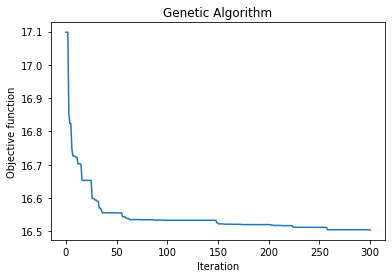

In [91]:
# 코드는 그대로
model_ga_top = geneticalgorithm(function=object_function_top,
                                dimension=12,
                                variable_type='int',
                                variable_boundaries=varbound,
                                algorithm_parameters=algorithm_param)

model_ga_top.run()
# 실행결과 
# 300번 이터레이션에서 최저점에 도달 

In [92]:
convergence_top = model_ga_top.report
solution_top = model_ga_top.output_dict

print(convergence_top)
print(solution_top)

[17.09788577676433, 17.09788577676433, 17.09788577676433, 16.854291066126105, 16.82406606134537, 16.82406606134537, 16.748769696002626, 16.72658323238447, 16.72658323238447, 16.72658323238447, 16.722573571909493, 16.722573571909493, 16.702799123258767, 16.702799123258767, 16.702799123258767, 16.70126065240786, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.653273653832077, 16.598661057748956, 16.598661057748956, 16.59806489559388, 16.593966969097597, 16.593966969097597, 16.59054073492653, 16.59054073492653, 16.570119419409206, 16.570119419409206, 16.564540821093413, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.55597760911797, 16.555585256844896, 16.55

#### 솔루션을 원복시킨다

In [93]:
ga_solution = input_conversion(solution_top['variable'])
ga_solution = np.array(ga_solution).reshape(1, -1)

ga_solution_df = pd.DataFrame(ga_solution, columns=features)
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title_mean_enc,category_id_mean_enc
0,7577574.0,254205.0,827342.0,64.0,17.0,29.80891,684.0,39.0,116.0,131.0,143.0,15873773.0,1.553969e+06


In [94]:
channel_title = mean_encode_channel[mean_encode_channel.isin(ga_solution_df['channel_title_mean_enc'])].index[0]
ga_solution_df['channel_title_mean_enc'] = channel_title
ga_solution_df = ga_solution_df.rename(columns={'channel_title_mean_enc': 'channel_title'})

category_id = mean_encode_category[mean_encode_category.isin(ga_solution_df['category_id_mean_enc'])].index[0]
ga_solution_df['category_id_mean_enc'] = category_id
ga_solution_df = ga_solution_df.rename(columns={'category_id_mean_enc': 'category_id'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category_id
0,7577574.0,254205.0,827342.0,64.0,17.0,29.80891,684.0,39.0,116.0,131.0,143.0,ArianaGrandeVevo,10


In [95]:
ga_solution_df['category_id'] = category_id_code[str(ga_solution_df['category_id'][0])]
ga_solution_df = ga_solution_df.rename(columns={'category_id': 'category'})
ga_solution_df

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category
0,7577574.0,254205.0,827342.0,64.0,17.0,29.80891,684.0,39.0,116.0,131.0,143.0,ArianaGrandeVevo,Music


In [96]:
# 위의 환경에서 조회수을 예측함 
prediction = voting_clf.predict(scaler.transform(ga_solution))
ga_solution_df['Views'] = int(prediction[0])
ga_solution_top = ga_solution_df
ga_solution_top

,likes,dislikes,comment_count,elapsed_day,number_of_tag,positive_ratio,description_length,title_length,r_avg,g_avg,b_avg,channel_title,category,Views
0,7577574.0,254205.0,827342.0,64.0,17.0,29.80891,684.0,39.0,116.0,131.0,143.0,ArianaGrandeVevo,Music,55281433


#**11. 결과 검토 및 분석: Top YouTuber**

In [97]:
# 뷰 최고값이 6279만 (딱 한개있는 값)
df_rgb2.describe()

,category_id,views,likes,dislikes,comment_count,r_avg,g_avg,b_avg,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
count,6558.000000,6.558000e+03,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6.558000e+03,6558.000000,6558.000000,6558.000000,6558.000000,6558.000000,6.558000e+03,6.558000e+03
mean,21.148216,3.702816e+05,1.533824e+04,522.017993,2374.226593,94.588442,87.229643,85.689235,2.541476,1.586026e+04,21.616956,107.952186,7.277071e+03,50.902485,1085.683883,9.780098,432.711040,43.321134,3.702816e+05,3.702816e+05
std,6.779788,1.662346e+06,1.036956e+05,11337.747492,18748.472408,31.165412,29.405352,29.578320,12.456900,1.086795e+05,17.978007,419.561007,4.705238e+04,195.772203,7539.910674,48.145208,537.183225,19.539754,1.361084e+06,3.700064e+05
min,1.000000,2.623000e+03,2.000000e+00,0.000000,0.000000,6.000000,6.000000,4.000000,1.000000,2.000000e+00,1.000000,0.161180,3.703704e-02,0.012151,0.000000,0.185734,1.000000,4.000000,2.623000e+03,2.332710e+04
25%,20.000000,4.455550e+04,6.780000e+02,20.000000,150.000000,74.000000,68.000000,66.000000,2.000000,7.352500e+02,8.000000,14.211516,3.325417e+02,6.400000,66.500000,2.795164,120.000000,28.000000,6.107850e+04,1.309392e+05
50%,24.000000,9.915450e+04,2.019500e+03,54.000000,429.000000,95.000000,87.000000,84.000000,2.000000,2.137500e+03,17.000000,35.212064,9.958333e+02,16.478125,199.000000,5.143421,260.000000,41.000000,1.232558e+05,2.772646e+05
75%,25.000000,2.330775e+05,4.765000e+03,142.000000,1086.750000,116.000000,106.000000,105.000000,2.000000,4.921000e+03,30.000000,78.976690,2.398500e+03,37.797115,520.625000,9.075080,535.000000,55.000000,2.420690e+05,4.091292e+05
max,43.000000,6.279639e+07,4.470923e+06,884965.000000,905925.000000,201.000000,188.000000,188.000000,706.000000,4.589976e+06,126.000000,5325.750000,1.529992e+06,2662.875000,301975.000000,1071.000000,5235.000000,100.000000,5.261173e+07,1.678646e+06


In [98]:
# comment_count를 좌우로 움직여본다 
# 다른 조건들은 그대로 
# -> comment_count가 82만-> 0이되어도 조회수는 -12%정도 줄것으로 예상된다. 
inf_input = copy.deepcopy(model_ga_top)

comment_count_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['comment_count'].min(), df_rgb2['comment_count'].max(), 1000)):    
    inf_input.output_dict['variable'][2] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    comment_count_dep_top.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 906/906 [00:15<00:00, 58.96it/s]


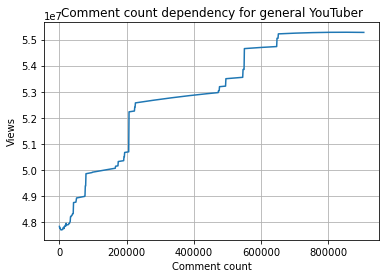

In [99]:
comment_count_dep_top_df = pd.DataFrame(comment_count_dep_top, columns=['comment_count', 'views'])

plt.title('Comment count dependency for general YouTuber')
plt.xlabel('Comment count')
# plt.ylim(0,5.5e7)
plt.ylabel('Views')
plt.grid()
plt.plot(comment_count_dep_top_df['comment_count'], comment_count_dep_top_df['views'])

In [100]:
# positive_ratio를 좌우로 변화시킴 
# -> 기존 29에서는 왼쪽으로 내려가면 조회수감소 
# -> 기존 29에서는 오른쪽으로 가도 조회수가 감소(데이터가 많지 않아서 정확히 보기 힘듬)
# -> positive ratio가 적정한 레벨에 있었다. 

inf_input = copy.deepcopy(model_ga_top)

positive_ratio_dep_top = []

total_sign = inf_input.output_dict['variable'][0] + inf_input.output_dict['variable'][1]
calculation_plot = 500
step = total_sign / calculation_plot

for i in tqdm.tqdm(np.arange(1, total_sign, step)):    
    inf_input.output_dict['variable'][0] = int(i)
    inf_input.output_dict['variable'][1] = total_sign - int(i)
    ratio = inf_input.output_dict['variable'][0] / inf_input.output_dict['variable'][1]

    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    positive_ratio_dep_top.append([ratio, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:08<00:00, 57.82it/s]


<BarContainer object of 500 artists>

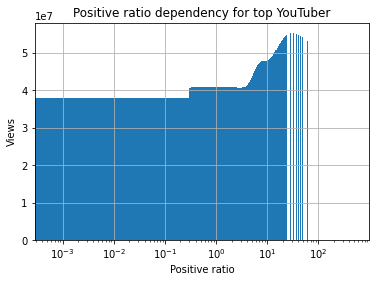

In [101]:
positive_ratio_dep_top_df = pd.DataFrame(positive_ratio_dep_top, columns=['positive_ratio', 'views'])

plt.title('Positive ratio dependency for top YouTuber')
plt.xlabel('Positive ratio')
plt.ylabel('Views')
plt.xscale('log')
plt.grid()
plt.bar(positive_ratio_dep_top_df['positive_ratio'], positive_ratio_dep_top_df['views'])

In [102]:
# number_of_tag_
# -> 큰 영향이 없다 

inf_input = copy.deepcopy(model_ga_top)

number_of_tag_dep_top = []

for i in tqdm.tqdm(range(df_rgb2['number_of_tag'].min(), df_rgb2['number_of_tag'].max())):    
    inf_input.output_dict['variable'][4] = i
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)   
    number_of_tag_dep_top.append([i, int(prediction)])

100%|████████████████████████████████████████████████████████████████████████████████| 125/125 [00:02<00:00, 59.05it/s]


<BarContainer object of 125 artists>

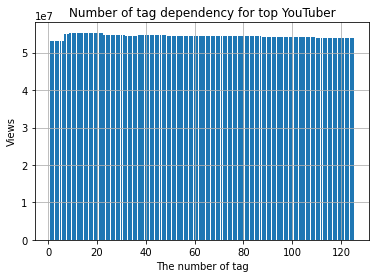

In [103]:
number_of_tag_dep_top_df = pd.DataFrame(number_of_tag_dep_top, columns=['number_of_tag', 'views'])

plt.title('Number of tag dependency for top YouTuber')
plt.xlabel('The number of tag')
# plt.ylim(5e7, 6e7)
plt.ylabel('Views')
plt.grid()
plt.bar(number_of_tag_dep_top_df['number_of_tag'], number_of_tag_dep_top_df['views'])

In [104]:
# random_image(썸네일)
# -> std가 0.83이기때문에 썸네일의 영향을 거의 받지 않는다 (통계적인 영향력)

inf_input = copy.deepcopy(model_ga_top)

random_image_dep_top = []

for i in tqdm.tqdm(range(2000)):    
    inf_input.output_dict['variable'][7] = randint(df_rgb2['r_avg'].min(), df_rgb2['r_avg'].max())
    inf_input.output_dict['variable'][8] = randint(df_rgb2['g_avg'].min(), df_rgb2['g_avg'].max())
    inf_input.output_dict['variable'][9] = randint(df_rgb2['b_avg'].min(), df_rgb2['b_avg'].max())
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    random_image_dep_top.append([i, int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:37<00:00, 53.67it/s]


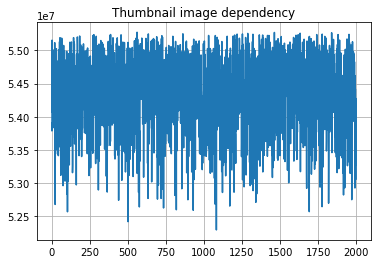

In [105]:
random_image_dep_top_df = pd.DataFrame(random_image_dep_top, columns=['Random_image', 'Views'])

plt.grid()
plt.title('Thumbnail image dependency')
plt.plot(random_image_dep_top_df['Random_image'], random_image_dep_top_df['Views'])

Average views: 54318323.2325
Median views: 54336872.0
Standard deviation of views [count]: 573830.1036052591
Standard deviation of views     [%]: 1.0564208713679921


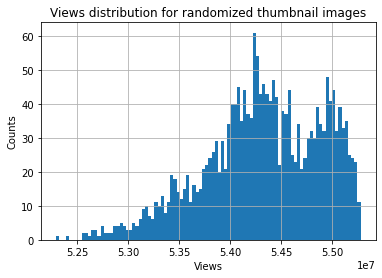

In [106]:
plt.grid()
plt.title('Views distribution for randomized thumbnail images')
plt.xlabel('Views')
plt.ylabel('Counts')
plt.hist(random_image_dep_top_df['Views'], bins=96)

print('Average views:', random_image_dep_top_df['Views'].mean())
print('Median views:', random_image_dep_top_df['Views'].median())
print('Standard deviation of views [count]:', random_image_dep_top_df['Views'].std())
print('Standard deviation of views     [%]:', random_image_dep_top_df['Views'].std()*100 / random_image_dep_top_df['Views'].mean())

In [107]:
# channel_title
# -> 특정채널만 높은 값은 가지고 있다 
# -> 일반유튜버 영상에서는 채널의 영향이 많이 컸다. std 100%넘었는데 
# -> top유뷰버 영상에서는 채널타이틀의 영향이 적다. std 4%정도 임. (분포는 큰얘기안함)

inf_input = copy.deepcopy(model_ga_top)

channel_title_dep_top = []

for i in tqdm.tqdm(range(len(mean_encode_channel))):
    inf_input.output_dict['variable'][10] = i 
    
    input_converted = input_conversion(inf_input.output_dict['variable'])
    input_converted = np.array(input_converted).reshape(1, -1)

    input_scaled = scaler.transform(input_converted)
    prediction = voting_clf.predict(input_scaled)    
    channel_title_dep_top.append([mean_encode_channel.index[i], int(prediction)])

100%|██████████████████████████████████████████████████████████████████████████████| 1478/1478 [00:25<00:00, 58.61it/s]


<BarContainer object of 1478 artists>

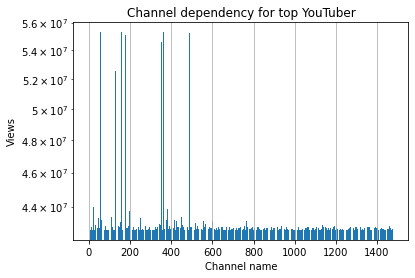

In [108]:
channel_title_dep_top_df = pd.DataFrame(channel_title_dep_top, columns=['channel_title', 'views'])

plt.title('Channel dependency for top YouTuber')
plt.xlabel('Channel name')
plt.ylabel('Views')
plt.yscale('log')
plt.grid()
plt.bar(range(len(channel_title_dep_top_df['channel_title'])), channel_title_dep_top_df['views'])

In [109]:
channel_title_dep_top_df.sort_values(by='views', ascending=False).head(10)

,channel_title,views
502,Sony Pictures Entertainment,55304865
159,Dude Perfect,55304053
123,ChildishGambinoVEVO,55303273
363,Marvel Entertainment,55303224
99,Bruno Mars,55302696
548,TaylorSwiftVEVO,55300073
57,AsapSCIENCE,55290450
677,ibighit,55286590
489,SelenaGomezVEVO,55285159
53,ArianaGrandeVevo,55281433


Average views: 43056846.49729364
Median views: 42750470.5
Standard deviation of views [count]: 1727628.9130418915
Standard deviation of views     [%]: 4.012437169894647


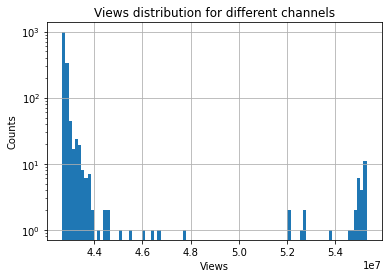

In [110]:
plt.grid()
plt.title('Views distribution for different channels')
plt.xlabel('Views')
# plt.xlim(0, 5.5e7) 
plt.ylabel('Counts')
plt.yscale('log')
plt.hist(channel_title_dep_top_df['views'], bins=96)

print('Average views:', channel_title_dep_top_df['views'].mean())
print('Median views:', channel_title_dep_top_df['views'].median())
print('Standard deviation of views [count]:', channel_title_dep_top_df['views'].std())
print('Standard deviation of views     [%]:', channel_title_dep_top_df['views'].std()*100 / channel_title_dep_top_df['views'].mean())

In [111]:
# 뷰기준으로 정렬함. 
df_rgb2.sort_values(by='views', ascending=False).head(10)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,r_avg,g_avg,b_avg,publish_time2,publish_date,elapsed_day,total_number_of_sign,number_of_tag,positive_ratio,sign_per_day,positive_ratio_per_day,comment_per_day,total_sign_comment_ratio,description_length,title_length,channel_title_mean_enc,category_id_mean_enc
5568,7C2z4GqqS5E,2018-05-20,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,10,2018-05-18T09:00:02.000Z,"BIGHIT|""빅히트""|""방탄소년단""|""BTS""|""BANGTAN""|""방탄""|""FAK...",62796390,4470923,119053,905925,https://i.ytimg.com/vi/7C2z4GqqS5E/default.jpg,False,False,False,BTS (방탄소년단) 'FAKE LOVE' Official MVDirector : ...,96,121,122,2018-05-18,2018-05-18,3,4589976,8,37.554056,1.529992e+06,12.518019,301975.000000,5.066618,784,35,1.517593e+07,1.553969e+06
812,FlsCjmMhFmw,2017-12-08,YouTube Rewind: The Shape of 2017 | #YouTubeRe...,YouTube Spotlight,24,2017-12-06T17:58:51.000Z,"Rewind|""Rewind 2017""|""youtube rewind 2017""|""#Y...",52611730,1891832,884965,702790,https://i.ytimg.com/vi/FlsCjmMhFmw/default.jpg,False,False,False,"YouTube Rewind 2017. Celebrating the videos, p...",73,76,75,2017-12-06,2017-12-06,3,2776797,37,2.137748,9.255990e+05,0.712583,234263.333333,3.951105,710,50,5.261173e+07,4.091292e+05
4361,i0p1bmr0EmE,2018-04-14,TWICE What is Love? M/V,jypentertainment,10,2018-04-09T08:59:51.000Z,"TWICE What is Love|""TWICE What is Love?""|""TWIC...",38840787,1111599,96407,206639,https://i.ytimg.com/vi/i0p1bmr0EmE/default.jpg,False,False,False,TWICE(트와이스) What is Love? M/V\n\nSpotify https...,94,92,97,2018-04-09,2018-04-09,6,1208006,35,11.530273,2.013343e+05,1.921712,34439.833333,5.845973,498,23,6.841438e+06,1.553969e+06
555,6ZfuNTqbHE8,2017-11-30,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",37736281,1735938,21972,241242,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,False,False,False,There was an idea… Avengers: Infinity War. In ...,74,64,49,2017-11-29,2017-11-29,2,1757910,11,79.006827,8.789550e+05,39.503413,120621.000000,7.286915,448,55,1.293744e+07,4.091292e+05
4723,u9Mv98Gr5pY,2018-04-25,VENOM - Official Trailer (HD),Sony Pictures Entertainment,24,2018-04-24T03:45:03.000Z,"Venom|""Venom Movie""|""Venom (2018)""|""Marvel""|""M...",27973210,850377,26543,96767,https://i.ytimg.com/vi/u9Mv98Gr5pY/default.jpg,False,False,False,We Are #Venom. 10.5.18\n\nOne of Marvel's most...,44,39,27,2018-04-24,2018-04-24,2,876920,24,32.037712,4.384600e+05,16.018856,48383.500000,9.062180,493,29,1.315249e+07,4.091292e+05
3642,QwievZ1Tx-8,2018-03-17,Marvel Studios' Avengers: Infinity War - Offic...,Marvel Entertainment,24,2018-03-16T13:02:41.000Z,"marvel|""comics""|""comic books""|""nerd""|""geek""|""s...",19716689,975760,9120,127045,https://i.ytimg.com/vi/QwievZ1Tx-8/default.jpg,False,False,False,In theaters April 27. Get your tickets now: ht...,103,94,86,2018-03-16,2018-03-16,2,984880,16,106.991228,4.924400e+05,53.495614,63522.500000,7.752214,474,57,1.293744e+07,4.091292e+05
4758,rRr1qiJRsXk,2018-04-25,Sanju | Official Teaser | Ranbir Kapoor | Rajk...,FoxStarHindi,24,2018-04-24T07:58:08.000Z,"Sanju Teaser|""Official Teaser""|""Sanju Official...",18639195,511785,15607,32435,https://i.ytimg.com/vi/rRr1qiJRsXk/default.jpg,False,False,False,Few lives in our times are as dramatic and eni...,105,111,121,2018-04-24,2018-04-24,2,527392,23,32.792016,2.636960e+05,16.396008,16217.500000,16.259966,1414,57,1.863920e+07,4.091292e+05
844,vn9mMeWcgoM,2017-12-09,Jurassic World: Fallen Kingdom - Official Trai...,Universal Pictures,24,2017-12-08T01:44:25.000Z,"Jurassic World|""Fallen Kingdom""|""Jurassic Park...",18184886,399208,17473,58902,https://i.ytimg.com/vi/vn9mMeWcgoM/default.jpg,False,False,False,Jurassic World: Fallen Kingdom\nIn Theaters Ju...,52,60,62,2017-12-08,2017-12-08,2,416681,22,22.847136,2.083405e+05,

In [1]:
# 유튜브관련 데이터가 상위유튜부 부분에서는 부족했다. 